In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.rc("figure", dpi=200)
import hdbscan
from pathlib import Path
import torch
from sklearn.decomposition import PCA
import matplotlib
from spike_psvae import cluster, merge_split_cleaned, cluster_viz_index, denoise, cluster_utils, triage, cluster_viz
from spike_psvae.cluster_utils import read_waveforms, compare_two_sorters, make_sorting_from_labels_frames
from spike_psvae.cluster_viz import plot_agreement_venn, plot_unit_similarities
from spike_psvae.cluster_utils import get_closest_clusters_kilosort_hdbscan
from spike_psvae.cluster_viz import plot_single_unit_summary
from spike_psvae.cluster_viz import cluster_scatter, plot_waveforms_geom, plot_venn_agreement #plot_raw_waveforms_unit_geom
from spike_psvae.cluster_viz import array_scatter, plot_self_agreement, plot_single_unit_summary, plot_agreement_venn, plot_isi_distribution, plot_unit_similarities, plot_waveforms_geom_unit
# plot_array_scatter, plot_waveforms_unit_geom
from spike_psvae.cluster_viz import plot_unit_similarity_heatmaps
from spike_psvae.cluster_utils import make_sorting_from_labels_frames, compute_cluster_centers, relabel_by_depth, remove_duplicate_units
# run_weighted_triage
from spike_psvae.triage import run_weighted_triage
from spike_psvae.cluster_utils import get_agreement_indices, compute_spiketrain_agreement, get_unit_similarities, compute_shifted_similarity, read_waveforms
from spike_psvae.cluster_utils import get_closest_clusters_hdbscan, get_closest_clusters_kilosort, get_closest_clusters_hdbscan_kilosort, get_closest_clusters_kilosort_hdbscan

In [3]:
np.random.seed(0) #for reproducibility (templates use random waveforms)

In [4]:
data_path = '/media/cat/data/'
data_name = 'CSH_ZAD_026_1800_1860'
data_dir = data_path + data_name + '/'
raw_bin = data_dir + '1min_standardized.bin'
residual_bin = data_dir + 'residual_1min_standardized_t_0_None.bin'
sub_h5 = data_dir + "subtraction_1min_standardized_t_0_None.h5"

output_dir = Path("/outputs")

In [5]:
results_localization = np.load(data_dir+'localization_results.npy')
ptps_localized = np.load(data_dir+'ptps.npy')
z_abs = z_reg = np.load(data_dir+'z_reg.npy')

In [6]:
results_localization[0]

array([ 49.38306617, 592.12148097,   2.10195243, 153.95340688,
        12.30730247,  36.        ,  56.        ])

In [7]:
firstchans = results_localization[:, 5]
x, z, y, alpha = results_localization[:, :4].T
maxptps = results_localization[:, 4]


In [8]:
#load features
offset_min = 30 #30 minutes into the recording
with h5py.File(sub_h5, "r") as h5:
    print(h5.keys())
    spike_index = h5["spike_index"][:]
    geom = h5["geom"][:]
    end_sample = h5["end_sample"][()]
    start_sample = h5["start_sample"][()]
    start_sample += offset_min * 60 * 30000
    end_sample += offset_min * 60 * 30000
#     channel_index = h5["channel_index"][:]
    tpca_mean = h5["tpca_mean"][:]
    tpca_components = h5["tpca_components"][:]
    print("Loading TPCA from h5")
    tpca = PCA(tpca_components.shape[0])
    tpca.mean_ = tpca_mean
    tpca.components_ = tpca_components
    
num_spikes = spike_index.shape[0]
end_time = end_sample / 30000
start_time = start_sample / 30000
recording_duration = end_time - start_time
h5 = h5py.File(sub_h5)
wfs_subtracted = h5["subtracted_waveforms"]
wfs_full_denoise = h5["cleaned_waveforms"]
print(f"duration of recording: {recording_duration} s")

<KeysViewHDF5 ['cleaned_waveforms', 'end_sample', 'first_channels', 'geom', 'spike_index', 'start_sample', 'subtracted_waveforms', 'tpca_components', 'tpca_mean']>
Loading TPCA from h5
duration of recording: 60.0 s


In [ ]:
# CHANNEL INDEX MISSING

In [13]:
kilo_spike_frames

array([      5,       7,      11, ..., 8999971, 8999976, 8999998],
      dtype=uint64)

In [9]:
#load kilosort results
data_path = '/media/cat/data/'
data_name = 'CSH_ZAD_026_5min'
data_dir = data_path + data_name + '/'
offset_min = 30

kilo_spike_samples = np.load(data_dir + 'kilosort_spk_samples.npy')
kilo_spike_frames = (kilo_spike_samples - offset_min*60*30000) #to match our detection alignment
kilo_spike_clusters = np.load(data_dir + 'kilosort_spk_clusters.npy')
kilo_spike_depths = np.load(data_dir + 'kilosort_spk_depths.npy')
kilo_cluster_depth_means = {}
kilo_cluster_locations= {}
kilo_cluster_templates = {}
kilo_cluster_maxptps = {}
#create kilosort SpikeInterface sorting
sorting_kilo = cluster_utils.make_sorting_from_labels_frames(kilo_spike_clusters, kilo_spike_frames)

from spike_psvae.localization import localize_ptp
for cluster_id in np.unique(kilo_spike_clusters):
    kilo_cluster_depth_means[cluster_id] = np.mean(kilo_spike_depths[kilo_spike_clusters==cluster_id])
    waveforms = read_waveforms(np.random.choice(sorting_kilo.get_unit_spike_train(cluster_id), 250), raw_bin, geom, n_times=121)[0]
    template = np.mean(waveforms, axis=0)
    kilo_cluster_templates[cluster_id] = template
    max_chan = np.argmin(np.abs((kilo_cluster_depth_means[cluster_id] - geom[:,1])))
    first_chan = max(max_chan-20, 0)
    channels = list(range(first_chan, first_chan+40))
    template_x, _, template_z_rel, template_z_abs, _, _ = localize_ptp(kilo_cluster_templates[cluster_id].ptp(0)[channels], first_chan, max_chan, geom)
    kilo_cluster_locations[cluster_id] = (template_x, template_z_abs)
    kilo_cluster_maxptps[cluster_id] = np.max(waveforms.ptp(1),1)
    
    
good_kilo_sort_clusters_all = np.array([  0,  17,  19,  25,  30,  33,  36,  38,  41,  47,  48,  53,  64,
        70,  78,  82,  83,  85,  88,  90,  97, 103, 109, 112, 114, 115,
       117, 119, 120, 131, 132, 133, 141, 142, 153, 158, 169, 172, 185,
       187, 189, 193, 197, 199, 205, 208, 211, 215, 217, 224, 237, 244,
       247, 269, 272, 274, 280, 283, 289, 291, 292, 296, 300, 303, 304,
       308, 309, 320, 328, 331, 336, 341, 349, 350, 380, 382, 386, 400,
       409, 411, 414, 435, 438, 439, 464, 474, 476, 478, 485, 487, 488,
       496, 503, 509, 512, 521, 522, 523, 529, 533, 534, 535, 536, 537,
       539, 544, 545, 547, 548, 551, 552, 555, 557, 570, 583, 596, 598,
       621, 629, 633, 637, 648, 655, 660, 670, 671, 677, 678, 681, 682,
       683, 699, 700, 702, 708, 709])

#remove empty clusters
good_kilo_sort_clusters = []
for good_cluster in good_kilo_sort_clusters_all:
    if good_cluster in sorting_kilo.get_unit_ids():
        good_kilo_sort_clusters.append(good_cluster) 

skipped (0, 6693804)
skipped (1, 8314172)
skipped (2, 4205904)
skipped (3, 5417316)
skipped (5, 4685586)
skipped (6, 6970083)
skipped (7, 2839065)
skipped (8, 6072182)
skipped (9, 7082148)
skipped (10, 5570609)
skipped (11, 5019188)
skipped (12, 6098725)
skipped (13, 6679831)
skipped (14, 3206525)
skipped (15, 4065446)
skipped (16, 7082148)
skipped (17, 6568988)
skipped (18, 2873660)
skipped (19, 3665450)
skipped (20, 5783275)
skipped (21, 5823175)
skipped (22, 3509960)
skipped (23, 4078565)
skipped (24, 3928239)
skipped (25, 5683077)
skipped (26, 4825424)
skipped (27, 4647358)
skipped (28, 8497219)
skipped (29, 6604444)
skipped (30, 6603822)
skipped (31, 4520268)
skipped (32, 3931821)
skipped (33, 6229315)
skipped (34, 5936334)
skipped (35, 4138616)
skipped (37, 3741117)
skipped (38, 3741117)
skipped (39, 2651268)
skipped (40, 6679416)
skipped (41, 6127792)
skipped (42, 4664492)
skipped (43, 5284718)
skipped (44, 5544817)
skipped (45, 7787556)
skipped (46, 1934412)
skipped (47, 580571

skipped (0, 3351410)
skipped (1, 3177140)
skipped (2, 5357666)
skipped (3, 4530805)
skipped (5, 6979395)
skipped (7, 8583826)
skipped (8, 8986842)
skipped (9, 3151202)
skipped (10, 2957784)
skipped (11, 5858145)
skipped (12, 7519706)
skipped (13, 6076354)
skipped (14, 2764609)
skipped (15, 4591064)
skipped (16, 3574709)
skipped (17, 7600290)
skipped (18, 8723946)
skipped (19, 4816425)
skipped (20, 3151202)
skipped (21, 3955663)
skipped (22, 7686173)
skipped (23, 8793003)
skipped (24, 6367843)
skipped (25, 3386411)
skipped (26, 4683390)
skipped (27, 8681655)
skipped (28, 6553756)
skipped (29, 6179156)
skipped (30, 5277478)
skipped (32, 4235582)
skipped (33, 8950980)
skipped (34, 2456636)
skipped (35, 4022752)
skipped (36, 7827861)
skipped (39, 8256130)
skipped (40, 5850555)
skipped (41, 3994762)
skipped (42, 8941707)
skipped (43, 7687933)
skipped (44, 5377107)
skipped (45, 5380244)
skipped (46, 6909810)
skipped (47, 5495098)
skipped (48, 2491071)
skipped (49, 4847011)
skipped (50, 76878

skipped (211, 7951487)
skipped (212, 5229910)
skipped (213, 4417866)
skipped (214, 4499214)
skipped (215, 8267984)
skipped (216, 6280937)
skipped (217, 2848225)
skipped (219, 8803173)
skipped (220, 4875584)
skipped (221, 5985429)
skipped (222, 6978791)
skipped (223, 2833573)
skipped (224, 5251787)
skipped (225, 8518274)
skipped (228, 6177790)
skipped (229, 6403008)
skipped (230, 5448671)
skipped (231, 8118912)
skipped (232, 6560811)
skipped (233, 8584793)
skipped (235, 8984181)
skipped (236, 6615722)
skipped (237, 3363875)
skipped (238, 7941576)
skipped (239, 3992596)
skipped (240, 3049091)
skipped (241, 5555603)
skipped (242, 6883819)
skipped (244, 2746021)
skipped (245, 6435070)
skipped (247, 2269433)
skipped (249, 1951464)
skipped (0, 5004589)
skipped (3, 5471580)
skipped (6, 8483304)
skipped (7, 1930952)
skipped (8, 2263758)
skipped (9, 4233355)
skipped (10, 2863112)
skipped (12, 3953113)
skipped (14, 6601138)
skipped (16, 4224052)
skipped (18, 4965075)
skipped (19, 3956894)
skippe

skipped (205, 3937963)
skipped (206, 3557329)
skipped (208, 8794170)
skipped (209, 5312420)
skipped (210, 7908826)
skipped (211, 3557329)
skipped (214, 5651003)
skipped (215, 5213661)
skipped (216, 4911985)
skipped (218, 6604285)
skipped (219, 7753061)
skipped (220, 5625112)
skipped (221, 5312420)
skipped (222, 3333469)
skipped (223, 3935870)
skipped (224, 5312420)
skipped (225, 8794170)
skipped (226, 4605402)
skipped (227, 6284102)
skipped (228, 5471978)
skipped (229, 7955477)
skipped (230, 7049442)
skipped (231, 6604285)
skipped (233, 5780435)
skipped (234, 8794170)
skipped (236, 3557329)
skipped (237, 3372251)
skipped (239, 3916265)
skipped (240, 7753061)
skipped (241, 7955477)
skipped (242, 4667249)
skipped (243, 5780435)
skipped (244, 8794170)
skipped (245, 3916658)
skipped (246, 3756284)
skipped (248, 8584023)
skipped (249, 7908826)
skipped (0, 2760049)
skipped (1, 6622938)
skipped (2, 7352476)
skipped (3, 7037740)
skipped (4, 8745400)
skipped (6, 2760049)
skipped (7, 3295812)
sk

skipped (156, 3553405)
skipped (157, 4452311)
skipped (158, 8734794)
skipped (159, 8117810)
skipped (161, 4558796)
skipped (162, 3877660)
skipped (163, 2900278)
skipped (164, 3175845)
skipped (165, 3483669)
skipped (166, 8540017)
skipped (167, 6502216)
skipped (168, 7501927)
skipped (169, 3665936)
skipped (171, 5118986)
skipped (172, 5102850)
skipped (173, 2371557)
skipped (174, 8554367)
skipped (175, 6771977)
skipped (176, 6472848)
skipped (177, 5308222)
skipped (178, 6818612)
skipped (179, 5461495)
skipped (180, 4855954)
skipped (181, 6177698)
skipped (183, 6249936)
skipped (184, 6264846)
skipped (185, 6712211)
skipped (186, 4688973)
skipped (187, 6469725)
skipped (188, 8311675)
skipped (189, 6710988)
skipped (190, 8263262)
skipped (191, 5072188)
skipped (192, 7749410)
skipped (193, 5465834)
skipped (195, 2343801)
skipped (196, 7630901)
skipped (198, 6788207)
skipped (199, 3825459)
skipped (200, 3360129)
skipped (202, 5006681)
skipped (203, 5821785)
skipped (204, 5884399)
skipped (20

skipped (106, 1908058)
skipped (107, 2830209)
skipped (108, 3362943)
skipped (109, 3457945)
skipped (110, 7280535)
skipped (111, 3491314)
skipped (112, 2854862)
skipped (113, 6200435)
skipped (114, 2643620)
skipped (115, 8484074)
skipped (116, 7187119)
skipped (117, 5097946)
skipped (118, 7944618)
skipped (119, 5055672)
skipped (120, 6192127)
skipped (121, 6396444)
skipped (122, 3668438)
skipped (123, 7956109)
skipped (124, 5705715)
skipped (125, 6196860)
skipped (126, 3757222)
skipped (127, 5559215)
skipped (128, 5434587)
skipped (129, 8976781)
skipped (130, 5821636)
skipped (131, 6359162)
skipped (132, 7388057)
skipped (133, 3623573)
skipped (134, 2879480)
skipped (135, 6565358)
skipped (136, 4960417)
skipped (138, 8583398)
skipped (139, 7654608)
skipped (140, 2607030)
skipped (141, 4963821)
skipped (142, 8523732)
skipped (143, 6989635)
skipped (144, 2054484)
skipped (145, 6565358)
skipped (146, 4047443)
skipped (147, 5312968)
skipped (148, 5568486)
skipped (150, 2033570)
skipped (15

skipped (130, 5600243)
skipped (131, 2819479)
skipped (132, 6880266)
skipped (133, 5882681)
skipped (134, 5806421)
skipped (135, 5340784)
skipped (136, 5300715)
skipped (137, 5286122)
skipped (138, 3174048)
skipped (139, 6336001)
skipped (140, 6074671)
skipped (141, 5300715)
skipped (143, 2896010)
skipped (144, 4109729)
skipped (145, 5745314)
skipped (146, 5284856)
skipped (147, 2748032)
skipped (149, 5857192)
skipped (150, 8843771)
skipped (151, 7645314)
skipped (152, 5340784)
skipped (154, 3949590)
skipped (155, 7367064)
skipped (156, 6257127)
skipped (157, 2153467)
skipped (158, 3962118)
skipped (161, 5584633)
skipped (164, 8031250)
skipped (168, 7644909)
skipped (169, 5340784)
skipped (170, 6599795)
skipped (171, 5344844)
skipped (172, 8581322)
skipped (173, 6151552)
skipped (174, 4600971)
skipped (175, 8475638)
skipped (176, 8483769)
skipped (178, 5664327)
skipped (179, 6121634)
skipped (180, 2748680)
skipped (181, 3174048)
skipped (182, 5344844)
skipped (183, 1928469)
skipped (18

skipped (169, 3937912)
skipped (170, 4917324)
skipped (171, 6200883)
skipped (172, 1825910)
skipped (174, 6513289)
skipped (175, 3937912)
skipped (176, 1825910)
skipped (177, 6513289)
skipped (178, 7781695)
skipped (179, 8741143)
skipped (181, 4591879)
skipped (182, 8515730)
skipped (183, 6874211)
skipped (184, 4249115)
skipped (185, 4760190)
skipped (187, 4342153)
skipped (188, 4960933)
skipped (189, 2566942)
skipped (190, 3663150)
skipped (191, 1825910)
skipped (192, 5938296)
skipped (193, 4760190)
skipped (194, 4127338)
skipped (195, 2232671)
skipped (196, 6081744)
skipped (198, 4249115)
skipped (199, 4128768)
skipped (200, 4917324)
skipped (201, 6200883)
skipped (202, 2827410)
skipped (203, 2053836)
skipped (204, 5938296)
skipped (206, 5828291)
skipped (207, 3937912)
skipped (208, 4128768)
skipped (209, 5756139)
skipped (210, 6261425)
skipped (211, 5589695)
skipped (212, 5050511)
skipped (213, 2037173)
skipped (214, 7781695)
skipped (215, 6081744)
skipped (216, 2827410)
skipped (21

skipped (222, 2444000)
skipped (223, 5531933)
skipped (224, 7489555)
skipped (225, 4786537)
skipped (226, 2448754)
skipped (228, 4523372)
skipped (229, 4254389)
skipped (230, 4677120)
skipped (231, 6155723)
skipped (232, 6493974)
skipped (233, 6414890)
skipped (234, 4367700)
skipped (235, 6374034)
skipped (236, 5530076)
skipped (237, 4672792)
skipped (238, 5979366)
skipped (240, 6251896)
skipped (241, 5463473)
skipped (242, 8637440)
skipped (243, 3199057)
skipped (244, 2452488)
skipped (245, 2831712)
skipped (246, 6877273)
skipped (247, 4073224)
skipped (248, 6804159)
skipped (0, 8889889)
skipped (2, 7964069)
skipped (3, 7964069)
skipped (4, 7839246)
skipped (5, 4089231)
skipped (7, 6628671)
skipped (8, 5564656)
skipped (9, 8794201)
skipped (10, 7846520)
skipped (11, 5564506)
skipped (12, 6084479)
skipped (15, 7634525)
skipped (17, 8595513)
skipped (18, 5922970)
skipped (20, 2360318)
skipped (21, 2493738)
skipped (23, 8153048)
skipped (24, 6628671)
skipped (25, 6628671)
skipped (26, 66

skipped (214, 4035036)
skipped (215, 2370467)
skipped (216, 3362221)
skipped (217, 2760462)
skipped (218, 3295496)
skipped (219, 8260548)
skipped (221, 4582994)
skipped (222, 8744800)
skipped (223, 7436011)
skipped (224, 6538987)
skipped (225, 6268246)
skipped (226, 5844231)
skipped (227, 2487239)
skipped (228, 5789624)
skipped (229, 6726704)
skipped (231, 6465143)
skipped (232, 2942031)
skipped (234, 3162070)
skipped (235, 6689568)
skipped (236, 7500107)
skipped (237, 8220189)
skipped (238, 6481031)
skipped (239, 1890776)
skipped (242, 8667540)
skipped (245, 5645644)
skipped (246, 8620864)
skipped (247, 5861723)
skipped (248, 7486288)
skipped (249, 5123681)
skipped (0, 6172625)
skipped (1, 6622518)
skipped (3, 3317979)
skipped (4, 8198113)
skipped (5, 6940305)
skipped (7, 5342222)
skipped (9, 6309225)
skipped (10, 4919868)
skipped (11, 7741681)
skipped (14, 8737579)
skipped (15, 4211505)
skipped (16, 3333499)
skipped (17, 2028320)
skipped (19, 6335130)
skipped (20, 8090209)
skipped (2

skipped (3, 2465478)
skipped (4, 7754082)
skipped (5, 8258951)
skipped (6, 8569237)
skipped (7, 7365127)
skipped (8, 4983095)
skipped (9, 4090405)
skipped (10, 3987868)
skipped (11, 6787836)
skipped (12, 3431620)
skipped (14, 4960790)
skipped (15, 5698781)
skipped (16, 3774448)
skipped (17, 3873060)
skipped (18, 3792909)
skipped (19, 8295421)
skipped (20, 5358111)
skipped (21, 8368679)
skipped (22, 2763836)
skipped (23, 3134451)
skipped (24, 5586135)
skipped (25, 4684703)
skipped (26, 8098514)
skipped (27, 5363504)
skipped (28, 2217790)
skipped (29, 6235927)
skipped (30, 5468778)
skipped (31, 8505546)
skipped (32, 8353552)
skipped (33, 6897947)
skipped (34, 7639368)
skipped (35, 5780592)
skipped (37, 1922385)
skipped (40, 6827871)
skipped (41, 3539481)
skipped (42, 3394870)
skipped (43, 7753571)
skipped (45, 4448739)
skipped (46, 5938833)
skipped (47, 6572829)
skipped (48, 3207475)
skipped (49, 3741887)
skipped (50, 6600733)
skipped (51, 6592260)
skipped (52, 4828697)
skipped (54, 6649

skipped (1, 4480987)
skipped (2, 1995117)
skipped (3, 4608724)
skipped (4, 8170352)
skipped (7, 8773676)
skipped (8, 3181217)
skipped (9, 4590219)
skipped (10, 2882717)
skipped (11, 5670076)
skipped (12, 7955485)
skipped (13, 7327516)
skipped (15, 5341681)
skipped (16, 5126247)
skipped (17, 4087052)
skipped (19, 4912183)
skipped (20, 2036942)
skipped (21, 4288378)
skipped (22, 2646708)
skipped (23, 7603682)
skipped (25, 4945773)
skipped (27, 3556848)
skipped (28, 5380111)
skipped (29, 5666939)
skipped (32, 3398351)
skipped (33, 5081521)
skipped (34, 5355767)
skipped (35, 8006453)
skipped (36, 8344584)
skipped (37, 4288378)
skipped (38, 3987623)
skipped (39, 3186264)
skipped (40, 7273166)
skipped (41, 6881810)
skipped (42, 8670001)
skipped (43, 4866727)
skipped (44, 7493385)
skipped (45, 8579285)
skipped (46, 2725207)
skipped (48, 5412046)
skipped (49, 1941133)
skipped (50, 4151537)
skipped (51, 2388233)
skipped (52, 3506124)
skipped (55, 6394200)
skipped (56, 4431796)
skipped (57, 7400

skipped (28, 8310658)
skipped (29, 7799903)
skipped (30, 2552315)
skipped (32, 7809385)
skipped (33, 4089421)
skipped (34, 3107691)
skipped (35, 8610049)
skipped (36, 4783612)
skipped (37, 2364737)
skipped (38, 7649269)
skipped (40, 6873199)
skipped (41, 1850806)
skipped (42, 3217097)
skipped (43, 7733534)
skipped (44, 7523498)
skipped (45, 3988318)
skipped (46, 5638234)
skipped (47, 6967685)
skipped (48, 3266500)
skipped (49, 2489536)
skipped (50, 6952474)
skipped (51, 2636265)
skipped (52, 6450574)
skipped (53, 2447973)
skipped (54, 8370056)
skipped (55, 8707854)
skipped (56, 3176949)
skipped (57, 2732785)
skipped (59, 8458331)
skipped (60, 7829419)
skipped (61, 7286155)
skipped (62, 5673829)
skipped (64, 5705606)
skipped (65, 3243436)
skipped (66, 8615629)
skipped (67, 4998435)
skipped (68, 2803788)
skipped (69, 2760717)
skipped (71, 5526446)
skipped (72, 6260486)
skipped (73, 5592243)
skipped (74, 6239793)
skipped (75, 8504229)
skipped (76, 3851772)
skipped (77, 6705300)
skipped (7

skipped (17, 5632849)
skipped (19, 3142869)
skipped (20, 6936899)
skipped (21, 3902578)
skipped (22, 6249263)
skipped (24, 6896674)
skipped (25, 8354040)
skipped (26, 3343256)
skipped (27, 2129130)
skipped (28, 3819243)
skipped (29, 3641466)
skipped (31, 5729138)
skipped (32, 6098344)
skipped (33, 3564392)
skipped (34, 8634792)
skipped (35, 3474062)
skipped (37, 2352275)
skipped (38, 6936899)
skipped (39, 1842304)
skipped (40, 3902578)
skipped (41, 8492662)
skipped (42, 2129130)
skipped (43, 3902578)
skipped (44, 2352275)
skipped (45, 8634792)
skipped (46, 4839297)
skipped (47, 3564392)
skipped (48, 2129130)
skipped (49, 3142869)
skipped (51, 5556774)
skipped (52, 3641466)
skipped (53, 2352275)
skipped (54, 5382427)
skipped (55, 3819243)
skipped (57, 2862103)
skipped (58, 5729138)
skipped (59, 3228002)
skipped (61, 2841968)
skipped (62, 6936899)
skipped (63, 6497343)
skipped (65, 8853882)
skipped (66, 5632849)
skipped (67, 2129130)
skipped (68, 3819243)
skipped (69, 3641466)
skipped (7

skipped (245, 3525199)
skipped (246, 8262591)
skipped (247, 4158513)
skipped (249, 5012070)
skipped (0, 2857505)
skipped (1, 3120057)
skipped (2, 5132917)
skipped (3, 4735982)
skipped (4, 7897422)
skipped (6, 6105525)
skipped (8, 3509195)
skipped (10, 6455268)
skipped (11, 7859072)
skipped (12, 3665588)
skipped (13, 8968109)
skipped (14, 4329071)
skipped (15, 5294780)
skipped (17, 6776130)
skipped (18, 4033013)
skipped (20, 3201962)
skipped (21, 2414088)
skipped (22, 6363269)
skipped (23, 4281295)
skipped (24, 2240357)
skipped (25, 3265259)
skipped (26, 5104352)
skipped (28, 5205401)
skipped (29, 3699275)
skipped (30, 2036717)
skipped (31, 3757046)
skipped (32, 6600463)
skipped (33, 6888743)
skipped (34, 2361184)
skipped (35, 4711269)
skipped (36, 6679187)
skipped (37, 8547506)
skipped (38, 4092430)
skipped (39, 7826917)
skipped (40, 2736808)
skipped (41, 8835106)
skipped (42, 4583736)
skipped (43, 4459576)
skipped (44, 8446691)
skipped (45, 1935798)
skipped (46, 6172509)
skipped (47, 

skipped (131, 5952660)
skipped (132, 8597729)
skipped (133, 2775111)
skipped (134, 2116516)
skipped (135, 2911726)
skipped (138, 4415178)
skipped (141, 8995248)
skipped (142, 8058487)
skipped (143, 3537775)
skipped (144, 3923479)
skipped (145, 1809882)
skipped (146, 5494707)
skipped (147, 6972549)
skipped (149, 3639241)
skipped (150, 4239959)
skipped (151, 6711674)
skipped (152, 2166576)
skipped (154, 8544787)
skipped (156, 8685889)
skipped (158, 7250434)
skipped (160, 4977083)
skipped (161, 7934960)
skipped (162, 8449587)
skipped (164, 3812393)
skipped (165, 8630325)
skipped (167, 4116165)
skipped (168, 5457354)
skipped (169, 7386090)
skipped (170, 3499477)
skipped (171, 7743964)
skipped (172, 4223442)
skipped (173, 5127575)
skipped (174, 4163110)
skipped (176, 3498590)
skipped (178, 8294015)
skipped (179, 7635850)
skipped (181, 7647646)
skipped (182, 7096783)
skipped (183, 7635088)
skipped (184, 6633383)
skipped (185, 3467149)
skipped (187, 2850991)
skipped (188, 8191402)
skipped (18

skipped (147, 2469166)
skipped (148, 4579285)
skipped (150, 8198797)
skipped (151, 5436683)
skipped (152, 7173524)
skipped (153, 8084801)
skipped (154, 7140331)
skipped (155, 4939936)
skipped (156, 5403739)
skipped (157, 6510430)
skipped (158, 5253684)
skipped (159, 8095342)
skipped (161, 8737617)
skipped (162, 2691789)
skipped (163, 8356230)
skipped (164, 4458472)
skipped (165, 1827723)
skipped (168, 2469166)
skipped (169, 7199470)
skipped (170, 4398644)
skipped (172, 3539210)
skipped (173, 4458472)
skipped (174, 4579285)
skipped (175, 3670762)
skipped (176, 7772417)
skipped (177, 7682172)
skipped (178, 3539210)
skipped (179, 6161074)
skipped (180, 5328670)
skipped (182, 6944138)
skipped (184, 8822844)
skipped (185, 2042804)
skipped (186, 5863828)
skipped (187, 6215522)
skipped (188, 3871471)
skipped (189, 4745191)
skipped (190, 6161074)
skipped (191, 4579285)
skipped (192, 4936035)
skipped (193, 8686315)
skipped (194, 3813873)
skipped (196, 3189808)
skipped (197, 2875932)
skipped (19

skipped (0, 6875633)
skipped (1, 8519071)
skipped (3, 2086932)
skipped (4, 3636044)
skipped (5, 3949389)
skipped (6, 8450761)
skipped (8, 6259260)
skipped (9, 6259260)
skipped (10, 2086932)
skipped (11, 8028712)
skipped (13, 3949389)
skipped (15, 8519071)
skipped (17, 3942178)
skipped (18, 8450761)
skipped (19, 3949389)
skipped (20, 4375948)
skipped (21, 8519071)
skipped (22, 2254503)
skipped (26, 8450761)
skipped (27, 3942178)
skipped (28, 8028712)
skipped (30, 8028712)
skipped (31, 6259260)
skipped (32, 3942178)
skipped (33, 8519071)
skipped (34, 3636044)
skipped (35, 4375948)
skipped (36, 6259260)
skipped (37, 2254503)
skipped (41, 6875633)
skipped (42, 8450761)
skipped (43, 3636044)
skipped (44, 8450761)
skipped (45, 3636044)
skipped (46, 2086932)
skipped (47, 6875633)
skipped (50, 8450761)
skipped (51, 8519071)
skipped (54, 8028712)
skipped (55, 2254503)
skipped (58, 8450761)
skipped (59, 6875633)
skipped (62, 8142625)
skipped (65, 8142625)
skipped (66, 4375948)
skipped (67, 62592

skipped (113, 6752858)
skipped (114, 7777741)
skipped (116, 7542834)
skipped (117, 3713417)
skipped (119, 2778526)
skipped (120, 4619646)
skipped (121, 6630690)
skipped (122, 8112315)
skipped (123, 8047191)
skipped (124, 5261969)
skipped (125, 5590909)
skipped (126, 7547764)
skipped (127, 6226655)
skipped (128, 4091087)
skipped (129, 4093411)
skipped (130, 3347996)
skipped (131, 4670788)
skipped (132, 3841756)
skipped (133, 5663844)
skipped (134, 3875824)
skipped (135, 7620515)
skipped (136, 3378007)
skipped (137, 6651786)
skipped (138, 5338445)
skipped (139, 8047191)
skipped (140, 3614561)
skipped (141, 6081382)
skipped (142, 6783569)
skipped (143, 3618095)
skipped (144, 2268415)
skipped (145, 2683113)
skipped (147, 6699670)
skipped (148, 4390032)
skipped (149, 5369866)
skipped (150, 3614561)
skipped (152, 2798162)
skipped (153, 6585757)
skipped (154, 5810953)
skipped (155, 4390032)
skipped (156, 5556281)
skipped (157, 4214781)
skipped (159, 1953658)
skipped (160, 8467167)
skipped (16

skipped (131, 8291610)
skipped (132, 6670523)
skipped (133, 8633961)
skipped (135, 8132380)
skipped (136, 2347670)
skipped (137, 4017147)
skipped (138, 2070233)
skipped (139, 5611735)
skipped (140, 6386329)
skipped (141, 2663521)
skipped (142, 3584804)
skipped (143, 6782780)
skipped (144, 7155151)
skipped (145, 5575808)
skipped (146, 3374434)
skipped (147, 6357949)
skipped (148, 3703525)
skipped (149, 5347108)
skipped (150, 5488346)
skipped (151, 2524562)
skipped (152, 2488294)
skipped (153, 7185335)
skipped (154, 6657675)
skipped (155, 7254229)
skipped (156, 3414194)
skipped (157, 5673206)
skipped (158, 5381054)
skipped (159, 4614075)
skipped (160, 5128749)
skipped (161, 4388584)
skipped (163, 5910725)
skipped (165, 4192470)
skipped (166, 6449228)
skipped (167, 5021934)
skipped (169, 4989728)
skipped (170, 3791305)
skipped (171, 6631086)
skipped (172, 7766605)
skipped (173, 6695998)
skipped (174, 4185897)
skipped (175, 7692277)
skipped (176, 5854960)
skipped (177, 4959889)
skipped (17

skipped (129, 6085630)
skipped (130, 2242513)
skipped (131, 6237578)
skipped (132, 3329069)
skipped (133, 8870789)
skipped (134, 5768475)
skipped (135, 8819131)
skipped (136, 2727896)
skipped (137, 5201435)
skipped (140, 3369773)
skipped (141, 7009783)
skipped (142, 6873306)
skipped (143, 6775645)
skipped (144, 3643579)
skipped (145, 8322073)
skipped (146, 8267460)
skipped (147, 2215468)
skipped (149, 3223418)
skipped (150, 1859955)
skipped (151, 7384438)
skipped (152, 2206616)
skipped (153, 7956947)
skipped (154, 3928453)
skipped (155, 2126243)
skipped (156, 7935535)
skipped (157, 6857651)
skipped (158, 4753914)
skipped (159, 7535077)
skipped (160, 4764391)
skipped (161, 7444729)
skipped (163, 2772986)
skipped (164, 6617940)
skipped (166, 4496740)
skipped (167, 8749952)
skipped (168, 3694319)
skipped (170, 3815635)
skipped (171, 5060862)
skipped (172, 6961349)
skipped (174, 5196196)
skipped (175, 6952895)
skipped (177, 5151908)
skipped (178, 5092831)
skipped (179, 2059643)
skipped (18

skipped (173, 3593700)
skipped (174, 5322716)
skipped (175, 6963994)
skipped (176, 2746830)
skipped (177, 8564599)
skipped (178, 2347433)
skipped (179, 3270174)
skipped (180, 7192414)
skipped (181, 2114817)
skipped (182, 7909249)
skipped (183, 6518613)
skipped (184, 8259944)
skipped (185, 8370700)
skipped (187, 3326356)
skipped (188, 7746511)
skipped (189, 6122759)
skipped (190, 8954123)
skipped (191, 8126181)
skipped (192, 7170535)
skipped (193, 6122233)
skipped (194, 4226446)
skipped (195, 6704178)
skipped (196, 5013016)
skipped (199, 6794803)
skipped (200, 2711093)
skipped (201, 2434014)
skipped (202, 6654882)
skipped (203, 5470359)
skipped (204, 6457213)
skipped (205, 8109707)
skipped (207, 8955351)
skipped (208, 4236566)
skipped (209, 2736033)
skipped (210, 6828190)
skipped (211, 5653114)
skipped (212, 3234521)
skipped (213, 7824598)
skipped (214, 7975966)
skipped (215, 1837821)
skipped (218, 4811108)
skipped (219, 2735850)
skipped (220, 3160082)
skipped (221, 1837600)
skipped (22

skipped (0, 2061047)
skipped (1, 4870769)
skipped (2, 4712630)
skipped (3, 4857421)
skipped (5, 1901600)
skipped (6, 5612981)
skipped (7, 7939817)
skipped (10, 3822168)
skipped (11, 7023566)
skipped (14, 3625464)
skipped (15, 6952668)
skipped (16, 8948922)
skipped (17, 4836681)
skipped (19, 5856977)
skipped (20, 6845300)
skipped (21, 3269123)
skipped (22, 5066183)
skipped (24, 6085603)
skipped (25, 5337247)
skipped (26, 3822029)
skipped (27, 6561883)
skipped (28, 1925974)
skipped (29, 3863994)
skipped (30, 8071707)
skipped (31, 3478736)
skipped (32, 3999157)
skipped (33, 8538281)
skipped (34, 6934281)
skipped (35, 1821059)
skipped (36, 8878806)
skipped (37, 7572922)
skipped (38, 5972502)
skipped (39, 5692105)
skipped (40, 7429599)
skipped (41, 6481958)
skipped (42, 7612504)
skipped (43, 1957212)
skipped (44, 7396738)
skipped (45, 3299529)
skipped (46, 3347789)
skipped (48, 2063104)
skipped (49, 4777438)
skipped (51, 4651286)
skipped (52, 7032177)
skipped (53, 4059318)
skipped (55, 1930

skipped (112, 8533244)
skipped (113, 5383052)
skipped (114, 8988248)
skipped (115, 7149743)
skipped (116, 1961370)
skipped (117, 8054089)
skipped (118, 6117325)
skipped (120, 7739669)
skipped (121, 8815854)
skipped (122, 3907043)
skipped (123, 8815854)
skipped (124, 6224250)
skipped (125, 2847276)
skipped (126, 6769453)
skipped (127, 7358696)
skipped (128, 3592645)
skipped (129, 2255437)
skipped (131, 5698336)
skipped (132, 8042691)
skipped (134, 2509468)
skipped (135, 7962963)
skipped (137, 6271881)
skipped (138, 8119974)
skipped (140, 8329601)
skipped (141, 8533244)
skipped (143, 6290047)
skipped (144, 3173030)
skipped (146, 4697896)
skipped (148, 6496966)
skipped (149, 1961370)
skipped (150, 5428818)
skipped (151, 8114519)
skipped (152, 5098280)
skipped (153, 2042827)
skipped (154, 5468919)
skipped (155, 3188223)
skipped (156, 5980989)
skipped (158, 6152204)
skipped (159, 8988248)
skipped (161, 8354311)
skipped (162, 3735284)
skipped (163, 5967775)
skipped (164, 6277434)
skipped (16

skipped (175, 6973226)
skipped (176, 2098579)
skipped (177, 6960627)
skipped (178, 2646191)
skipped (179, 6873848)
skipped (180, 8115566)
skipped (181, 4222586)
skipped (182, 3746749)
skipped (183, 8966274)
skipped (184, 2586429)
skipped (185, 4855576)
skipped (186, 3913572)
skipped (187, 6539097)
skipped (189, 4597189)
skipped (190, 4565688)
skipped (192, 5716795)
skipped (193, 7724468)
skipped (194, 2054567)
skipped (196, 6173564)
skipped (198, 8117974)
skipped (200, 3557459)
skipped (201, 4125096)
skipped (202, 4095285)
skipped (203, 5139805)
skipped (204, 6776890)
skipped (205, 2793114)
skipped (206, 2793114)
skipped (207, 2516073)
skipped (208, 6547288)
skipped (209, 3754757)
skipped (210, 3446827)
skipped (211, 6452974)
skipped (212, 3550323)
skipped (214, 3550807)
skipped (215, 6811943)
skipped (216, 5596397)
skipped (217, 4095285)
skipped (218, 3746749)
skipped (219, 4597189)
skipped (220, 3833310)
skipped (221, 7049364)
skipped (222, 2663518)
skipped (223, 6244386)
skipped (22

skipped (62, 7604792)
skipped (64, 6102097)
skipped (65, 6064057)
skipped (67, 6511545)
skipped (68, 2725595)
skipped (69, 3144260)
skipped (70, 6548274)
skipped (72, 6063153)
skipped (73, 8453429)
skipped (74, 3911773)
skipped (75, 6975070)
skipped (76, 6856239)
skipped (77, 4535182)
skipped (78, 4487744)
skipped (79, 7018506)
skipped (80, 8401044)
skipped (81, 2254930)
skipped (82, 5069345)
skipped (83, 7503586)
skipped (84, 8115263)
skipped (85, 6631064)
skipped (86, 3162972)
skipped (87, 5160824)
skipped (88, 4113091)
skipped (89, 3825046)
skipped (91, 2220438)
skipped (92, 4552948)
skipped (93, 2099251)
skipped (94, 7658102)
skipped (95, 7477929)
skipped (96, 5916972)
skipped (97, 5674808)
skipped (98, 2043165)
skipped (99, 5462385)
skipped (100, 2490436)
skipped (101, 2785607)
skipped (102, 8452532)
skipped (104, 2834626)
skipped (105, 7843528)
skipped (107, 8707479)
skipped (108, 4975564)
skipped (109, 5325677)
skipped (110, 3185219)
skipped (111, 2293822)
skipped (112, 4148054)

skipped (110, 2046137)
skipped (111, 8793360)
skipped (112, 2071921)
skipped (113, 4574982)
skipped (114, 4582363)
skipped (116, 6973294)
skipped (117, 2734660)
skipped (119, 5290712)
skipped (120, 5863374)
skipped (121, 6788988)
skipped (122, 6976561)
skipped (124, 4141404)
skipped (125, 4380820)
skipped (126, 8667866)
skipped (128, 2218950)
skipped (129, 4776050)
skipped (130, 4365035)
skipped (131, 8268541)
skipped (132, 7405966)
skipped (133, 6378642)
skipped (135, 3467763)
skipped (137, 8444956)
skipped (138, 7083133)
skipped (139, 5484535)
skipped (140, 3182612)
skipped (141, 5619206)
skipped (142, 4715393)
skipped (143, 5766161)
skipped (144, 2812661)
skipped (145, 3351407)
skipped (147, 7020663)
skipped (148, 5829963)
skipped (149, 7394788)
skipped (150, 7816927)
skipped (151, 3219407)
skipped (152, 6489761)
skipped (153, 5721196)
skipped (154, 3501810)
skipped (155, 5547996)
skipped (156, 4480361)
skipped (157, 5521757)
skipped (158, 7186826)
skipped (159, 6038034)
skipped (16

skipped (75, 4704587)
skipped (76, 3851787)
skipped (77, 3022441)
skipped (78, 8962057)
skipped (79, 4939535)
skipped (80, 2746878)
skipped (82, 4914598)
skipped (84, 7089182)
skipped (85, 8119855)
skipped (86, 6625122)
skipped (87, 4098740)
skipped (88, 4361720)
skipped (89, 8679046)
skipped (90, 6396450)
skipped (91, 7089920)
skipped (92, 8593934)
skipped (93, 5639041)
skipped (94, 7399241)
skipped (95, 2861494)
skipped (96, 7206031)
skipped (97, 3944739)
skipped (98, 4460079)
skipped (100, 3356155)
skipped (102, 5946053)
skipped (105, 8907593)
skipped (106, 2684099)
skipped (109, 4284280)
skipped (110, 5215045)
skipped (111, 8330028)
skipped (112, 8615090)
skipped (113, 3356155)
skipped (114, 6096289)
skipped (116, 7262698)
skipped (118, 7439348)
skipped (120, 4978329)
skipped (121, 2366417)
skipped (123, 6229812)
skipped (125, 6448209)
skipped (126, 6568025)
skipped (127, 3939594)
skipped (128, 2746740)
skipped (129, 2826633)
skipped (130, 2748984)
skipped (131, 2850639)
skipped (1

skipped (116, 8047143)
skipped (117, 2581643)
skipped (119, 2726522)
skipped (120, 4027769)
skipped (121, 5727580)
skipped (122, 4963474)
skipped (123, 4718854)
skipped (124, 8047143)
skipped (126, 6549802)
skipped (127, 8047143)
skipped (128, 2796304)
skipped (130, 2268409)
skipped (133, 4718854)
skipped (134, 3455942)
skipped (135, 2581643)
skipped (137, 3455942)
skipped (138, 8059782)
skipped (139, 5727580)
skipped (140, 6549802)
skipped (141, 4718854)
skipped (142, 8786464)
skipped (143, 2581643)
skipped (144, 7089231)
skipped (145, 5727580)
skipped (146, 2268409)
skipped (147, 4027769)
skipped (148, 8059782)
skipped (149, 4963474)
skipped (150, 4963474)
skipped (151, 6549802)
skipped (152, 5727580)
skipped (153, 8786464)
skipped (154, 3455942)
skipped (155, 8786464)
skipped (156, 2482044)
skipped (157, 8786464)
skipped (158, 4718854)
skipped (159, 4718854)
skipped (160, 2268409)
skipped (162, 4027769)
skipped (163, 7089231)
skipped (164, 2726522)
skipped (165, 7089231)
skipped (16

skipped (222, 2448335)
skipped (225, 7764452)
skipped (227, 1926379)
skipped (229, 8285876)
skipped (230, 3659278)
skipped (233, 2258225)
skipped (234, 8354720)
skipped (235, 8784493)
skipped (236, 8259760)
skipped (237, 7547373)
skipped (238, 4857260)
skipped (239, 5243523)
skipped (240, 4992152)
skipped (241, 6870657)
skipped (242, 8153862)
skipped (243, 2645624)
skipped (245, 7863505)
skipped (246, 5765357)
skipped (247, 8806617)
skipped (248, 3147831)
skipped (249, 4679094)
skipped (0, 1964687)
skipped (1, 8162439)
skipped (2, 6443266)
skipped (4, 3461149)
skipped (6, 6575222)
skipped (7, 2467035)
skipped (8, 7803103)
skipped (9, 2477607)
skipped (10, 5943592)
skipped (13, 2436353)
skipped (14, 4123224)
skipped (15, 2825621)
skipped (16, 3494423)
skipped (17, 4075028)
skipped (18, 5352614)
skipped (19, 5662942)
skipped (20, 2653050)
skipped (21, 2708753)
skipped (22, 4933424)
skipped (25, 5551162)
skipped (26, 7440589)
skipped (27, 3116228)
skipped (28, 5641572)
skipped (29, 876803

skipped (0, 3920465)
skipped (1, 4019385)
skipped (2, 5385029)
skipped (3, 8710067)
skipped (4, 6611523)
skipped (5, 6783979)
skipped (6, 5658745)
skipped (8, 3934033)
skipped (9, 8492491)
skipped (10, 3060767)
skipped (12, 3934033)
skipped (13, 3060767)
skipped (15, 7968996)
skipped (16, 3060767)
skipped (17, 3160127)
skipped (18, 3060767)
skipped (19, 5767219)
skipped (20, 5747299)
skipped (22, 7377724)
skipped (23, 6611523)
skipped (24, 5374757)
skipped (25, 8492491)
skipped (26, 3502574)
skipped (27, 5063513)
skipped (28, 7748449)
skipped (29, 7377724)
skipped (30, 5517538)
skipped (32, 3172965)
skipped (33, 7968996)
skipped (34, 7818616)
skipped (35, 4372026)
skipped (36, 2196184)
skipped (37, 6866583)
skipped (38, 3160127)
skipped (39, 5658745)
skipped (40, 6990529)
skipped (41, 5936576)
skipped (42, 7542420)
skipped (43, 7377724)
skipped (44, 6872737)
skipped (46, 6601379)
skipped (47, 7818616)
skipped (48, 5831202)
skipped (49, 8484477)
skipped (50, 5747299)
skipped (51, 677722

skipped (147, 8488744)
skipped (148, 7267859)
skipped (149, 5744955)
skipped (150, 7968727)
skipped (151, 2328410)
skipped (152, 7991270)
skipped (153, 4372817)
skipped (154, 2744471)
skipped (155, 2328410)
skipped (157, 7758208)
skipped (158, 8300061)
skipped (159, 7665738)
skipped (160, 7991270)
skipped (161, 5744955)
skipped (162, 8509971)
skipped (163, 4361882)
skipped (164, 5744955)
skipped (165, 8787018)
skipped (166, 8488744)
skipped (167, 8271694)
skipped (168, 8509971)
skipped (170, 4372817)
skipped (171, 8509971)
skipped (172, 4372817)
skipped (173, 7758208)
skipped (174, 8266916)
skipped (175, 8300061)
skipped (176, 7968727)
skipped (178, 8488744)
skipped (180, 7665738)
skipped (181, 8509971)
skipped (182, 2328410)
skipped (184, 7968727)
skipped (185, 8266916)
skipped (186, 8300061)
skipped (188, 8488744)
skipped (189, 8266916)
skipped (190, 4686657)
skipped (191, 8787018)
skipped (192, 8271694)
skipped (193, 8300061)
skipped (194, 7665738)
skipped (195, 7991270)
skipped (19

skipped (0, 8865065)
skipped (1, 3565114)
skipped (3, 4489635)
skipped (4, 6359443)
skipped (5, 5585053)
skipped (6, 3228681)
skipped (9, 1942411)
skipped (10, 4494870)
skipped (11, 3152840)
skipped (13, 8386673)
skipped (14, 8231908)
skipped (15, 2251679)
skipped (16, 5634074)
skipped (17, 3271266)
skipped (18, 4434754)
skipped (20, 3516184)
skipped (21, 7819624)
skipped (22, 4686927)
skipped (23, 6359443)
skipped (24, 5252923)
skipped (25, 4473289)
skipped (27, 5243582)
skipped (32, 6292905)
skipped (33, 2901315)
skipped (34, 2962530)
skipped (35, 6555533)
skipped (36, 6220409)
skipped (37, 7673267)
skipped (39, 7569965)
skipped (40, 4169239)
skipped (41, 4275817)
skipped (42, 8542418)
skipped (43, 6466232)
skipped (44, 5138435)
skipped (45, 8559230)
skipped (47, 7509343)
skipped (48, 6785576)
skipped (49, 5858335)
skipped (50, 1878986)
skipped (51, 7623429)
skipped (52, 6021467)
skipped (53, 4494870)
skipped (54, 6469684)
skipped (55, 2105059)
skipped (56, 6082303)
skipped (57, 3494

skipped (0, 4200694)
skipped (1, 7570028)
skipped (2, 3362781)
skipped (4, 2732855)
skipped (5, 3818135)
skipped (6, 8314281)
skipped (9, 2700811)
skipped (11, 5847406)
skipped (12, 7615107)
skipped (14, 1909842)
skipped (15, 1994994)
skipped (16, 1867831)
skipped (17, 4389970)
skipped (18, 2220291)
skipped (19, 8820534)
skipped (20, 4569794)
skipped (22, 3501216)
skipped (25, 6961523)
skipped (26, 8660306)
skipped (28, 4064818)
skipped (29, 5138894)
skipped (30, 8649780)
skipped (31, 3443817)
skipped (32, 5758462)
skipped (33, 3362781)
skipped (34, 6542036)
skipped (35, 5748753)
skipped (36, 8699195)
skipped (37, 6484827)
skipped (38, 4233119)
skipped (39, 6464995)
skipped (40, 2372581)
skipped (41, 3072215)
skipped (42, 5784975)
skipped (43, 3577425)
skipped (44, 2614306)
skipped (45, 7259556)
skipped (46, 7921548)
skipped (47, 7644562)
skipped (48, 6968183)
skipped (49, 5079352)
skipped (50, 5325598)
skipped (51, 6280976)
skipped (53, 6323196)
skipped (54, 5696177)
skipped (55, 6156

skipped (51, 3747757)
skipped (52, 4927310)
skipped (53, 5091832)
skipped (54, 6959994)
skipped (56, 1814083)
skipped (57, 4390888)
skipped (59, 8100710)
skipped (60, 2108937)
skipped (61, 4296841)
skipped (62, 5388463)
skipped (63, 4064503)
skipped (64, 3215574)
skipped (65, 6683254)
skipped (66, 8002464)
skipped (67, 4822291)
skipped (68, 6390718)
skipped (69, 3800265)
skipped (70, 6554365)
skipped (71, 3587764)
skipped (72, 1964499)
skipped (74, 5042067)
skipped (75, 3516829)
skipped (76, 3321766)
skipped (77, 3678951)
skipped (79, 5481922)
skipped (80, 5052609)
skipped (81, 7923919)
skipped (82, 2522154)
skipped (83, 4050309)
skipped (84, 3300274)
skipped (85, 8285433)
skipped (86, 8246497)
skipped (87, 4622610)
skipped (88, 2690096)
skipped (89, 7621682)
skipped (92, 7892812)
skipped (93, 8879492)
skipped (95, 4814731)
skipped (96, 4709225)
skipped (97, 2733597)
skipped (98, 7815289)
skipped (100, 5745450)
skipped (101, 8171121)
skipped (102, 6348292)
skipped (103, 8247191)
skippe

skipped (39, 8220629)
skipped (41, 5422087)
skipped (43, 8865434)
skipped (44, 5343278)
skipped (45, 2500287)
skipped (47, 5982899)
skipped (48, 6167124)
skipped (50, 4731851)
skipped (52, 3925907)
skipped (53, 5257565)
skipped (54, 2220169)
skipped (56, 2628992)
skipped (57, 4599389)
skipped (58, 2789583)
skipped (60, 8438099)
skipped (61, 8230655)
skipped (63, 8865859)
skipped (64, 7374607)
skipped (65, 6454507)
skipped (66, 5032823)
skipped (67, 3170167)
skipped (68, 2683788)
skipped (69, 5273015)
skipped (70, 2258767)
skipped (71, 5103551)
skipped (72, 5271358)
skipped (73, 7634900)
skipped (74, 7778648)
skipped (75, 5348701)
skipped (77, 5072255)
skipped (79, 5196436)
skipped (80, 2360535)
skipped (81, 2580990)
skipped (83, 3057555)
skipped (84, 5605758)
skipped (85, 4127740)
skipped (86, 7927600)
skipped (87, 3189721)
skipped (89, 7947233)
skipped (90, 2064760)
skipped (92, 5065331)
skipped (93, 2290092)
skipped (94, 8756985)
skipped (95, 6939997)
skipped (97, 7950422)
skipped (9

skipped (23, 3759204)
skipped (24, 3092752)
skipped (25, 2834912)
skipped (26, 4370651)
skipped (27, 5293621)
skipped (30, 7899956)
skipped (31, 7063141)
skipped (32, 4777804)
skipped (33, 2274265)
skipped (35, 4854546)
skipped (36, 6014572)
skipped (37, 3064388)
skipped (38, 4388624)
skipped (39, 6056652)
skipped (42, 7142795)
skipped (43, 7196574)
skipped (45, 8729433)
skipped (46, 5445227)
skipped (47, 2121550)
skipped (49, 8250870)
skipped (50, 2738079)
skipped (51, 1918748)
skipped (52, 5713559)
skipped (53, 8529021)
skipped (54, 3903911)
skipped (55, 6105650)
skipped (56, 4480257)
skipped (58, 6847396)
skipped (59, 7732943)
skipped (60, 2301615)
skipped (62, 2033874)
skipped (63, 6714595)
skipped (64, 3477049)
skipped (65, 4235748)
skipped (66, 6319413)
skipped (67, 4395852)
skipped (68, 8510370)
skipped (69, 3039128)
skipped (70, 3800789)
skipped (71, 7893921)
skipped (72, 8621732)
skipped (73, 6911513)
skipped (74, 5578035)
skipped (75, 4541367)
skipped (76, 7531574)
skipped (7

skipped (47, 6174398)
skipped (48, 5042253)
skipped (49, 8222151)
skipped (50, 3430844)
skipped (51, 8611703)
skipped (52, 2628096)
skipped (53, 3831392)
skipped (54, 7960777)
skipped (55, 8846833)
skipped (56, 6962040)
skipped (58, 7909581)
skipped (59, 3766676)
skipped (60, 7506440)
skipped (62, 6927586)
skipped (64, 7533647)
skipped (65, 2547001)
skipped (67, 8800390)
skipped (68, 7649794)
skipped (69, 2635874)
skipped (70, 2626167)
skipped (71, 8116359)
skipped (72, 4678868)
skipped (73, 5972728)
skipped (74, 2096255)
skipped (75, 3825825)
skipped (76, 8999022)
skipped (77, 5401212)
skipped (78, 2765333)
skipped (79, 2726011)
skipped (81, 6617972)
skipped (82, 7341491)
skipped (83, 7665614)
skipped (85, 7234461)
skipped (86, 8788504)
skipped (87, 7298872)
skipped (88, 5510184)
skipped (89, 6785253)
skipped (90, 5274178)
skipped (91, 5631755)
skipped (92, 7053600)
skipped (93, 4491263)
skipped (94, 5159941)
skipped (95, 5286825)
skipped (96, 6129370)
skipped (97, 5189385)
skipped (9

skipped (202, 4430906)
skipped (203, 5911413)
skipped (205, 7086275)
skipped (206, 4430906)
skipped (207, 5564087)
skipped (208, 1915897)
skipped (209, 5163692)
skipped (210, 2085889)
skipped (212, 4416435)
skipped (213, 6660235)
skipped (214, 7662986)
skipped (215, 7311636)
skipped (216, 8739662)
skipped (217, 6062071)
skipped (218, 6277885)
skipped (219, 5769040)
skipped (220, 1925820)
skipped (221, 7662986)
skipped (222, 3687495)
skipped (223, 7206794)
skipped (224, 8676350)
skipped (225, 5242198)
skipped (226, 6417981)
skipped (227, 6022473)
skipped (228, 3938823)
skipped (229, 5769040)
skipped (230, 8462266)
skipped (231, 5645953)
skipped (232, 2955813)
skipped (233, 6062071)
skipped (234, 7013757)
skipped (237, 4912100)
skipped (238, 8295376)
skipped (239, 5479168)
skipped (240, 4831867)
skipped (241, 7961444)
skipped (244, 5711480)
skipped (245, 2988414)
skipped (246, 6377259)
skipped (247, 7475017)
skipped (248, 8886630)
skipped (249, 8808288)
skipped (0, 6298499)
skipped (1, 2

skipped (0, 3502573)
skipped (2, 6604833)
skipped (3, 4233143)
skipped (4, 3519817)
skipped (5, 4482476)
skipped (6, 2475829)
skipped (7, 4482476)
skipped (8, 4637911)
skipped (9, 5560692)
skipped (11, 7758209)
skipped (12, 6251977)
skipped (13, 3249612)
skipped (14, 3548751)
skipped (15, 5560692)
skipped (16, 6604833)
skipped (17, 5652471)
skipped (18, 2602935)
skipped (19, 6941858)
skipped (20, 2712803)
skipped (21, 8835569)
skipped (22, 3777702)
skipped (23, 1850335)
skipped (24, 4710861)
skipped (25, 2602935)
skipped (26, 8000801)
skipped (27, 5176288)
skipped (31, 3197753)
skipped (32, 6372056)
skipped (33, 5028636)
skipped (34, 3423134)
skipped (35, 7758209)
skipped (38, 6256109)
skipped (40, 6689735)
skipped (41, 4310637)
skipped (42, 6941858)
skipped (44, 8835569)
skipped (45, 8658123)
skipped (46, 8000801)
skipped (47, 3317256)
skipped (48, 5742057)
skipped (50, 8835569)
skipped (51, 5564220)
skipped (53, 8446229)
skipped (55, 3777702)
skipped (56, 4482476)
skipped (58, 202614

skipped (0, 6686266)
skipped (1, 4511435)
skipped (2, 2594514)
skipped (3, 1833410)
skipped (5, 4971292)
skipped (6, 6686266)
skipped (7, 8265114)
skipped (8, 4971292)
skipped (10, 3771725)
skipped (11, 2238954)
skipped (12, 3871848)
skipped (14, 4938917)
skipped (15, 5160998)
skipped (16, 5282166)
skipped (17, 3771725)
skipped (18, 6506909)
skipped (19, 6105970)
skipped (20, 4033990)
skipped (21, 8272224)
skipped (22, 5517168)
skipped (23, 6465848)
skipped (24, 6377489)
skipped (25, 3848006)
skipped (26, 4980300)
skipped (27, 8228446)
skipped (28, 2870220)
skipped (29, 7651536)
skipped (30, 8132637)
skipped (31, 8265114)
skipped (32, 4997923)
skipped (34, 5152238)
skipped (35, 3771725)
skipped (36, 6866183)
skipped (37, 2824374)
skipped (38, 5193086)
skipped (39, 6506909)
skipped (40, 4452490)
skipped (41, 5776070)
skipped (44, 5564712)
skipped (45, 4029774)
skipped (46, 8265114)
skipped (47, 4511435)
skipped (48, 2777892)
skipped (49, 8265114)
skipped (50, 6105970)
skipped (51, 55638

skipped (107, 2711989)
skipped (108, 2819399)
skipped (109, 6134870)
skipped (110, 5756517)
skipped (111, 4907656)
skipped (112, 6607452)
skipped (113, 4392612)
skipped (114, 2226269)
skipped (115, 7892114)
skipped (117, 6364110)
skipped (118, 3828039)
skipped (119, 3480644)
skipped (120, 7380139)
skipped (121, 4217175)
skipped (122, 2869385)
skipped (123, 8849154)
skipped (124, 4390860)
skipped (126, 6029877)
skipped (127, 4005903)
skipped (128, 8862437)
skipped (129, 5581196)
skipped (130, 7023768)
skipped (131, 5842388)
skipped (134, 7689799)
skipped (135, 2346321)
skipped (136, 3843458)
skipped (138, 6229941)
skipped (140, 2045123)
skipped (142, 2455414)
skipped (143, 2772537)
skipped (144, 7737359)
skipped (145, 3375233)
skipped (147, 4223839)
skipped (149, 7527097)
skipped (150, 5405315)
skipped (151, 3804446)
skipped (152, 7527097)
skipped (154, 3260231)
skipped (155, 4395894)
skipped (156, 8052027)
skipped (157, 6277539)
skipped (158, 6793126)
skipped (159, 7399271)
skipped (16

skipped (164, 5882554)
skipped (165, 2466181)
skipped (168, 7777248)
skipped (169, 6893482)
skipped (170, 2034654)
skipped (171, 8889619)
skipped (172, 8137290)
skipped (173, 7547861)
skipped (174, 8839171)
skipped (176, 5070795)
skipped (177, 6765693)
skipped (179, 5625908)
skipped (180, 7712952)
skipped (181, 6868311)
skipped (182, 4850144)
skipped (184, 8970915)
skipped (185, 4184384)
skipped (186, 4697266)
skipped (187, 7143220)
skipped (188, 5426689)
skipped (189, 7547200)
skipped (190, 6080322)
skipped (191, 8517890)
skipped (192, 3769458)
skipped (194, 2027122)
skipped (195, 5658077)
skipped (196, 4269234)
skipped (199, 3356349)
skipped (201, 7798673)
skipped (202, 8557588)
skipped (203, 7154430)
skipped (204, 2387390)
skipped (205, 3151465)
skipped (206, 6917938)
skipped (207, 5639241)
skipped (208, 2022824)
skipped (210, 3813332)
skipped (211, 4967214)
skipped (212, 4455826)
skipped (213, 1963762)
skipped (214, 7703466)
skipped (215, 4046169)
skipped (216, 3956381)
skipped (21

skipped (8, 6166554)
skipped (9, 4148981)
skipped (10, 6942913)
skipped (11, 3235988)
skipped (12, 8443636)
skipped (13, 4959707)
skipped (14, 7938497)
skipped (15, 3479661)
skipped (16, 4963472)
skipped (17, 4334441)
skipped (18, 2061532)
skipped (19, 6169846)
skipped (20, 3268114)
skipped (21, 7800431)
skipped (22, 2205727)
skipped (23, 3042767)
skipped (24, 6443139)
skipped (25, 2752285)
skipped (26, 8272977)
skipped (27, 6156199)
skipped (28, 7974302)
skipped (30, 5547853)
skipped (31, 2452717)
skipped (33, 7750776)
skipped (34, 5813508)
skipped (35, 8812302)
skipped (39, 2139762)
skipped (40, 2500736)
skipped (42, 2912159)
skipped (43, 7955113)
skipped (44, 3375778)
skipped (45, 2620894)
skipped (46, 2460498)
skipped (48, 7382756)
skipped (49, 6278164)
skipped (50, 2205727)
skipped (51, 2352689)
skipped (52, 5388619)
skipped (53, 3907777)
skipped (54, 5775853)
skipped (55, 8492119)
skipped (56, 3366849)
skipped (57, 2742660)
skipped (58, 7423609)
skipped (59, 5059174)
skipped (61,

skipped (126, 2314776)
skipped (127, 2853740)
skipped (128, 8759405)
skipped (129, 8678471)
skipped (131, 4590170)
skipped (132, 2531515)
skipped (133, 8492753)
skipped (134, 7751051)
skipped (135, 7863722)
skipped (138, 7751051)
skipped (139, 8467650)
skipped (140, 6662421)
skipped (141, 6954769)
skipped (142, 6447391)
skipped (143, 2114858)
skipped (144, 6774104)
skipped (145, 4590170)
skipped (146, 2114858)
skipped (149, 8304246)
skipped (151, 4573859)
skipped (152, 2114858)
skipped (153, 8678471)
skipped (154, 8157341)
skipped (156, 6780712)
skipped (158, 2853740)
skipped (161, 4590170)
skipped (162, 2531515)
skipped (164, 7863722)
skipped (165, 1875473)
skipped (166, 5309308)
skipped (167, 7453644)
skipped (168, 8841170)
skipped (169, 7557148)
skipped (170, 8331345)
skipped (171, 8841170)
skipped (172, 2114858)
skipped (173, 2314776)
skipped (174, 6747639)
skipped (175, 3061002)
skipped (178, 2203989)
skipped (180, 2021219)
skipped (181, 7300420)
skipped (182, 4573859)
skipped (18

skipped (22, 3854967)
skipped (23, 5924746)
skipped (24, 6667625)
skipped (25, 5438941)
skipped (26, 4869641)
skipped (27, 6299764)
skipped (29, 2330130)
skipped (30, 3162235)
skipped (31, 2763916)
skipped (36, 2074316)
skipped (37, 8403756)
skipped (38, 7275814)
skipped (40, 5121188)
skipped (41, 2965390)
skipped (42, 8999285)
skipped (43, 2821659)
skipped (44, 7743042)
skipped (45, 3186281)
skipped (46, 7175402)
skipped (47, 2729754)
skipped (48, 1822962)
skipped (49, 2977516)
skipped (50, 4685021)
skipped (51, 4092123)
skipped (52, 4916575)
skipped (53, 6975624)
skipped (54, 6632571)
skipped (55, 6328348)
skipped (56, 5044418)
skipped (57, 5497033)
skipped (58, 8978870)
skipped (61, 4490306)
skipped (62, 6461061)
skipped (63, 5634838)
skipped (64, 6762049)
skipped (65, 6254875)
skipped (67, 7716443)
skipped (68, 3830644)
skipped (69, 8391350)
skipped (70, 6512089)
skipped (71, 5472240)
skipped (72, 4344566)
skipped (73, 2538009)
skipped (74, 3438237)
skipped (75, 7057510)
skipped (7

skipped (41, 4087684)
skipped (43, 4634856)
skipped (44, 6654359)
skipped (45, 4087684)
skipped (46, 6654359)
skipped (48, 2604359)
skipped (49, 5076938)
skipped (50, 7362789)
skipped (51, 2888509)
skipped (52, 2604359)
skipped (53, 7642586)
skipped (54, 5076938)
skipped (56, 2602915)
skipped (58, 7772904)
skipped (61, 5863639)
skipped (62, 4087684)
skipped (64, 5217647)
skipped (65, 5182624)
skipped (66, 5217647)
skipped (67, 7409120)
skipped (68, 4087684)
skipped (69, 5182624)
skipped (70, 7409120)
skipped (71, 7487087)
skipped (72, 2602915)
skipped (73, 7599085)
skipped (74, 7642586)
skipped (75, 5217647)
skipped (76, 7362789)
skipped (77, 5167204)
skipped (78, 2604359)
skipped (81, 2604359)
skipped (82, 5570797)
skipped (83, 6654359)
skipped (84, 2888509)
skipped (87, 4390329)
skipped (88, 2604359)
skipped (89, 4634856)
skipped (91, 5182624)
skipped (92, 6862053)
skipped (94, 2888509)
skipped (95, 5167204)
skipped (97, 3923048)
skipped (99, 4634856)
skipped (100, 7642586)
skipped (

skipped (93, 7419278)
skipped (94, 8673058)
skipped (95, 5054238)
skipped (96, 5844780)
skipped (97, 2825919)
skipped (98, 4450115)
skipped (99, 6334054)
skipped (100, 4228215)
skipped (101, 2143947)
skipped (102, 8572349)
skipped (104, 3730672)
skipped (106, 4052634)
skipped (107, 6215774)
skipped (109, 3921618)
skipped (110, 7815637)
skipped (111, 5475149)
skipped (114, 5150702)
skipped (115, 4357187)
skipped (116, 5657286)
skipped (118, 8165408)
skipped (119, 2345287)
skipped (120, 5615544)
skipped (121, 2815405)
skipped (122, 7638730)
skipped (123, 4330052)
skipped (124, 7962530)
skipped (125, 8122617)
skipped (126, 6194440)
skipped (127, 6342845)
skipped (128, 4358078)
skipped (129, 3734895)
skipped (130, 5852391)
skipped (131, 5183613)
skipped (132, 2442312)
skipped (133, 3818878)
skipped (134, 7944292)
skipped (135, 5049989)
skipped (136, 5148438)
skipped (137, 2713259)
skipped (138, 3898744)
skipped (139, 4305398)
skipped (140, 8061261)
skipped (141, 5803986)
skipped (142, 3361

skipped (32, 2774357)
skipped (33, 7823330)
skipped (34, 8979617)
skipped (36, 8128373)
skipped (38, 8120987)
skipped (39, 8799333)
skipped (40, 4076982)
skipped (41, 4800076)
skipped (42, 6200567)
skipped (43, 8491555)
skipped (44, 2625237)
skipped (45, 8591451)
skipped (46, 4014523)
skipped (47, 2774357)
skipped (50, 5094984)
skipped (51, 4390030)
skipped (52, 1842114)
skipped (53, 5385024)
skipped (54, 4297226)
skipped (55, 8382901)
skipped (56, 6811116)
skipped (57, 8784369)
skipped (58, 3738865)
skipped (60, 7770951)
skipped (61, 6288942)
skipped (62, 1859862)
skipped (64, 8799333)
skipped (65, 8003991)
skipped (66, 7473183)
skipped (68, 2452711)
skipped (70, 8128545)
skipped (71, 8402449)
skipped (72, 8799333)
skipped (73, 8799333)
skipped (74, 2730428)
skipped (75, 5499003)
skipped (76, 2730428)
skipped (77, 5666902)
skipped (78, 5651765)
skipped (79, 4390030)
skipped (80, 5652774)
skipped (82, 1859862)
skipped (83, 5375130)
skipped (85, 2381274)
skipped (87, 3932575)
skipped (8

skipped (228, 5050035)
skipped (229, 5835779)
skipped (230, 6273489)
skipped (232, 5972896)
skipped (233, 5363883)
skipped (234, 5574559)
skipped (235, 6568542)
skipped (236, 6568542)
skipped (237, 2637424)
skipped (239, 6890355)
skipped (240, 5618901)
skipped (241, 1923885)
skipped (244, 8160627)
skipped (245, 7392483)
skipped (246, 5824998)
skipped (247, 5638962)
skipped (248, 6689714)
skipped (249, 2762257)
skipped (0, 3708285)
skipped (2, 7411798)
skipped (3, 2079449)
skipped (4, 7411798)
skipped (5, 7411798)
skipped (7, 3578209)
skipped (8, 3708285)
skipped (9, 4675682)
skipped (10, 2079449)
skipped (11, 2523185)
skipped (12, 3708285)
skipped (13, 3708285)
skipped (14, 3460917)
skipped (15, 3578209)
skipped (17, 4295251)
skipped (19, 2256369)
skipped (20, 6092513)
skipped (21, 6092513)
skipped (22, 6479760)
skipped (23, 5719819)
skipped (24, 4295251)
skipped (26, 2223256)
skipped (27, 3198281)
skipped (28, 6479760)
skipped (29, 2487867)
skipped (30, 3198281)
skipped (31, 3578209)


skipped (0, 4389203)
skipped (1, 6101338)
skipped (2, 2740551)
skipped (3, 5222568)
skipped (4, 8003885)
skipped (5, 8003885)
skipped (6, 3197715)
skipped (7, 4389203)
skipped (9, 5069277)
skipped (10, 3197715)
skipped (12, 2168881)
skipped (13, 2168881)
skipped (14, 5491873)
skipped (15, 3792681)
skipped (16, 3197715)
skipped (17, 2740551)
skipped (18, 5491873)
skipped (19, 4968018)
skipped (20, 6101338)
skipped (21, 8003679)
skipped (22, 6379387)
skipped (23, 6379387)
skipped (25, 2740551)
skipped (26, 4968018)
skipped (27, 2494281)
skipped (28, 4704733)
skipped (29, 5069277)
skipped (30, 2740551)
skipped (31, 2740551)
skipped (32, 5375340)
skipped (33, 5069277)
skipped (34, 4389203)
skipped (35, 6101338)
skipped (36, 2494281)
skipped (37, 8003679)
skipped (38, 5375340)
skipped (39, 2740551)
skipped (40, 4914265)
skipped (46, 8003679)
skipped (47, 6101338)
skipped (48, 5222568)
skipped (50, 2740551)
skipped (51, 6101338)
skipped (53, 5069277)
skipped (54, 2494281)
skipped (55, 379268

skipped (42, 3839931)
skipped (44, 3979230)
skipped (46, 7813219)
skipped (47, 8435052)
skipped (48, 5067042)
skipped (49, 4159649)
skipped (50, 7554006)
skipped (51, 7182090)
skipped (52, 4525765)
skipped (53, 5139828)
skipped (54, 5609157)
skipped (56, 8116447)
skipped (57, 4387938)
skipped (58, 4342233)
skipped (60, 5745870)
skipped (62, 4332722)
skipped (63, 7067403)
skipped (64, 8456513)
skipped (65, 6485640)
skipped (67, 3907007)
skipped (68, 8830314)
skipped (69, 2136159)
skipped (70, 2107793)
skipped (71, 8696374)
skipped (73, 5820420)
skipped (74, 4896412)
skipped (75, 2502041)
skipped (76, 6485781)
skipped (77, 4355661)
skipped (78, 4775254)
skipped (79, 4859016)
skipped (80, 3801482)
skipped (81, 4607164)
skipped (83, 4039246)
skipped (84, 7532498)
skipped (85, 3856044)
skipped (86, 5390689)
skipped (87, 3937605)
skipped (88, 5621315)
skipped (89, 3240907)
skipped (90, 3830309)
skipped (91, 3670959)
skipped (92, 4490383)
skipped (94, 3149876)
skipped (95, 8615607)
skipped (9

skipped (89, 5764143)
skipped (90, 5871034)
skipped (92, 2613104)
skipped (93, 6192557)
skipped (94, 2959852)
skipped (95, 3932901)
skipped (96, 8399597)
skipped (97, 6217843)
skipped (98, 6785281)
skipped (99, 8339342)
skipped (100, 3979265)
skipped (101, 6771472)
skipped (102, 2246963)
skipped (103, 7688428)
skipped (105, 7521657)
skipped (106, 2801416)
skipped (107, 3831509)
skipped (108, 8648253)
skipped (109, 1912752)
skipped (111, 4428651)
skipped (112, 3774004)
skipped (113, 5271775)
skipped (114, 6884180)
skipped (115, 6942012)
skipped (116, 5114931)
skipped (117, 8601564)
skipped (118, 5086296)
skipped (119, 6469125)
skipped (121, 6965942)
skipped (122, 1928231)
skipped (123, 5978805)
skipped (124, 8818258)
skipped (125, 7227320)
skipped (126, 4215669)
skipped (128, 7381208)
skipped (129, 8660544)
skipped (130, 4609112)
skipped (131, 8492041)
skipped (132, 2035222)
skipped (133, 3509986)
skipped (134, 6716078)
skipped (135, 6467163)
skipped (136, 6789427)
skipped (137, 4160867

skipped (131, 8938224)
skipped (132, 2456743)
skipped (133, 2606840)
skipped (135, 4366070)
skipped (136, 4035331)
skipped (139, 6859942)
skipped (140, 7266223)
skipped (141, 4389918)
skipped (142, 3507104)
skipped (143, 4994376)
skipped (144, 6257837)
skipped (145, 2835554)
skipped (146, 4902629)
skipped (147, 2305044)
skipped (148, 4452987)
skipped (150, 4527502)
skipped (151, 2206238)
skipped (153, 7509304)
skipped (154, 3595355)
skipped (155, 4101566)
skipped (156, 8903543)
skipped (157, 4208910)
skipped (158, 4072537)
skipped (159, 8098952)
skipped (160, 5523090)
skipped (161, 4816204)
skipped (162, 2434121)
skipped (163, 8494175)
skipped (164, 5155536)
skipped (165, 6511056)
skipped (166, 1927746)
skipped (167, 5288221)
skipped (170, 8480625)
skipped (171, 4944089)
skipped (173, 6446618)
skipped (174, 3302120)
skipped (175, 6239523)
skipped (176, 6150893)
skipped (177, 4493582)
skipped (179, 6865222)
skipped (181, 6197540)
skipped (182, 7636861)
skipped (183, 2527751)
skipped (18

skipped (80, 7198367)
skipped (81, 7669519)
skipped (82, 3647585)
skipped (83, 7523332)
skipped (85, 7075295)
skipped (86, 2203650)
skipped (87, 4470085)
skipped (88, 3558704)
skipped (89, 3417632)
skipped (90, 3036398)
skipped (91, 2780870)
skipped (92, 8689263)
skipped (94, 4680640)
skipped (96, 5886279)
skipped (97, 4593874)
skipped (98, 7507599)
skipped (99, 5779079)
skipped (100, 4409055)
skipped (101, 2773468)
skipped (102, 5666646)
skipped (104, 3109118)
skipped (105, 8840071)
skipped (106, 8972686)
skipped (108, 7009501)
skipped (109, 3766455)
skipped (112, 8892506)
skipped (113, 8910083)
skipped (114, 5625706)
skipped (115, 2071529)
skipped (117, 7793436)
skipped (118, 8464652)
skipped (119, 3269964)
skipped (120, 3676934)
skipped (121, 5830700)
skipped (122, 8320899)
skipped (124, 7198367)
skipped (125, 2452109)
skipped (126, 3489860)
skipped (127, 3676585)
skipped (129, 5107171)
skipped (130, 4597949)
skipped (131, 2776278)
skipped (132, 7647098)
skipped (133, 3359509)
skipp

skipped (92, 8091916)
skipped (93, 3032680)
skipped (95, 2192366)
skipped (96, 2737108)
skipped (97, 2183896)
skipped (98, 3348543)
skipped (99, 3990789)
skipped (101, 7229120)
skipped (102, 5529447)
skipped (103, 6875680)
skipped (104, 2197658)
skipped (105, 8636309)
skipped (106, 7080711)
skipped (107, 8822067)
skipped (108, 8715080)
skipped (109, 7305795)
skipped (110, 5383069)
skipped (112, 7311865)
skipped (113, 4072198)
skipped (114, 7203193)
skipped (115, 2625882)
skipped (116, 4208457)
skipped (117, 7763248)
skipped (119, 5268424)
skipped (120, 7632995)
skipped (121, 5596263)
skipped (123, 2303119)
skipped (125, 5099053)
skipped (127, 6168753)
skipped (129, 2051981)
skipped (130, 6253078)
skipped (131, 8380156)
skipped (133, 3293658)
skipped (134, 4725726)
skipped (135, 4012214)
skipped (136, 3968910)
skipped (138, 5562203)
skipped (139, 6376078)
skipped (140, 5479741)
skipped (141, 3342902)
skipped (143, 3164082)
skipped (145, 8497423)
skipped (146, 5782672)
skipped (147, 3006

skipped (243, 2809061)
skipped (244, 2692421)
skipped (245, 2514905)
skipped (246, 2545938)
skipped (248, 3050809)
skipped (3, 2558843)
skipped (5, 3486266)
skipped (6, 2558843)
skipped (7, 5088278)
skipped (8, 7118025)
skipped (10, 8841317)
skipped (11, 5921872)
skipped (12, 5709997)
skipped (13, 7642395)
skipped (14, 6057342)
skipped (15, 6505600)
skipped (16, 8143307)
skipped (17, 8023368)
skipped (18, 3859932)
skipped (19, 2832016)
skipped (20, 8779103)
skipped (22, 4623911)
skipped (23, 7359693)
skipped (24, 6351294)
skipped (25, 8967306)
skipped (26, 4788956)
skipped (28, 8143307)
skipped (29, 3604244)
skipped (30, 2207137)
skipped (31, 5385246)
skipped (33, 3019105)
skipped (34, 7826184)
skipped (35, 5956659)
skipped (36, 7778926)
skipped (37, 8945971)
skipped (39, 6375734)
skipped (40, 6375734)
skipped (41, 4057122)
skipped (42, 4390702)
skipped (43, 4223505)
skipped (44, 2046808)
skipped (45, 5776148)
skipped (47, 5764080)
skipped (48, 6124696)
skipped (49, 8967306)
skipped (5

skipped (10, 3465467)
skipped (12, 5970487)
skipped (13, 6593391)
skipped (15, 4394830)
skipped (16, 3465467)
skipped (17, 6197660)
skipped (18, 7807116)
skipped (19, 7191724)
skipped (20, 6197660)
skipped (21, 7807116)
skipped (22, 5970487)
skipped (23, 5574364)
skipped (24, 7191724)
skipped (25, 7807116)
skipped (26, 4394830)
skipped (27, 5970487)
skipped (28, 7807116)
skipped (29, 3465467)
skipped (31, 4105687)
skipped (32, 6593391)
skipped (33, 7807116)
skipped (34, 3465467)
skipped (35, 4105687)
skipped (36, 4105687)
skipped (38, 5970487)
skipped (39, 7191724)
skipped (41, 6593391)
skipped (42, 5970487)
skipped (44, 4105687)
skipped (46, 7807116)
skipped (47, 4105687)
skipped (49, 4394830)
skipped (50, 7191724)
skipped (51, 4105687)
skipped (53, 5970487)
skipped (54, 4394830)
skipped (56, 7807116)
skipped (58, 3465467)
skipped (59, 5574364)
skipped (61, 6197660)
skipped (62, 4105687)
skipped (63, 7807116)
skipped (64, 7191724)
skipped (66, 6197660)
skipped (67, 4394830)
skipped (6

skipped (230, 1994049)
skipped (231, 2623018)
skipped (232, 2230413)
skipped (233, 5618014)
skipped (234, 8719884)
skipped (235, 6474492)
skipped (236, 2029829)
skipped (237, 6096508)
skipped (238, 7531747)
skipped (239, 2828432)
skipped (240, 8175114)
skipped (241, 3269930)
skipped (242, 1979653)
skipped (243, 5929017)
skipped (245, 1930545)
skipped (246, 5803929)
skipped (247, 6753801)
skipped (248, 6529221)
skipped (1, 6188455)
skipped (2, 6069336)
skipped (3, 8867621)
skipped (4, 3634250)
skipped (6, 6188455)
skipped (7, 5653473)
skipped (8, 5934773)
skipped (9, 5562326)
skipped (10, 5653473)
skipped (11, 6660336)
skipped (12, 6660336)
skipped (14, 8689412)
skipped (15, 8832012)
skipped (16, 4378337)
skipped (18, 8689412)
skipped (19, 6069336)
skipped (20, 6660336)
skipped (21, 6660336)
skipped (22, 6188455)
skipped (23, 8832012)
skipped (24, 4378337)
skipped (27, 8832012)
skipped (29, 5653473)
skipped (30, 4378337)
skipped (32, 3618553)
skipped (33, 6660336)
skipped (34, 4905242)


skipped (136, 2475398)
skipped (137, 1929626)
skipped (138, 6522741)
skipped (139, 4679979)
skipped (140, 5305541)
skipped (141, 6083324)
skipped (142, 3686341)
skipped (143, 5853191)
skipped (145, 2734297)
skipped (146, 4227674)
skipped (147, 2349466)
skipped (148, 8961815)
skipped (149, 8628851)
skipped (152, 8977896)
skipped (153, 6780849)
skipped (154, 6677164)
skipped (155, 5466049)
skipped (157, 2305899)
skipped (158, 5679837)
skipped (160, 7633977)
skipped (161, 4625927)
skipped (162, 5465504)
skipped (164, 8346739)
skipped (165, 8429246)
skipped (166, 2199532)
skipped (167, 3407196)
skipped (171, 2863874)
skipped (172, 3295763)
skipped (173, 4236561)
skipped (175, 2693880)
skipped (176, 1864537)
skipped (178, 7213596)
skipped (179, 6877656)
skipped (181, 4293576)
skipped (183, 6882984)
skipped (185, 4537341)
skipped (186, 5128646)
skipped (187, 2835337)
skipped (188, 7722568)
skipped (189, 5312950)
skipped (190, 6759262)
skipped (191, 8691558)
skipped (192, 5715905)
skipped (19

skipped (210, 8736523)
skipped (211, 8271029)
skipped (212, 3728925)
skipped (214, 6887863)
skipped (215, 5519714)
skipped (216, 6853850)
skipped (217, 2834574)
skipped (218, 6872528)
skipped (219, 5935537)
skipped (220, 4590261)
skipped (221, 3747944)
skipped (222, 5124343)
skipped (225, 3458348)
skipped (226, 4675990)
skipped (227, 3464491)
skipped (228, 7182733)
skipped (229, 4590261)
skipped (230, 7826708)
skipped (231, 3928329)
skipped (232, 6590539)
skipped (234, 6033713)
skipped (235, 6271625)
skipped (236, 3215628)
skipped (237, 5562671)
skipped (238, 6687151)
skipped (239, 5665096)
skipped (240, 3458348)
skipped (241, 6258936)
skipped (242, 2811974)
skipped (243, 3215628)
skipped (244, 6761385)
skipped (245, 3667601)
skipped (246, 6709458)
skipped (247, 8886638)
skipped (248, 4851150)
skipped (249, 2235253)
skipped (0, 5799255)
skipped (2, 3661737)
skipped (3, 8133575)
skipped (4, 6946315)
skipped (6, 8764599)
skipped (7, 4690882)
skipped (9, 5799255)
skipped (11, 7197854)
ski

/home/julien/ENTER/envs/iblenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julien/ENTER/envs/iblenv/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


skipped (9, 5194665)
skipped (10, 4341510)
skipped (11, 3082712)
skipped (12, 3549261)
skipped (14, 6847291)
skipped (15, 1865996)
skipped (17, 6965612)
skipped (18, 6381223)
skipped (19, 2223079)
skipped (21, 3965349)
skipped (22, 7810551)
skipped (24, 5189676)
skipped (25, 7314512)
skipped (27, 4156936)
skipped (29, 5612736)
skipped (30, 4231917)
skipped (32, 8826794)
skipped (33, 8049092)
skipped (35, 5661884)
skipped (36, 7238080)
skipped (37, 4201244)
skipped (38, 3769065)
skipped (39, 1925500)
skipped (40, 6971063)
skipped (41, 8715112)
skipped (46, 3019429)
skipped (47, 4332279)
skipped (48, 1882580)
skipped (49, 8985141)
skipped (50, 3019429)
skipped (51, 5157194)
skipped (53, 7178254)
skipped (54, 8869737)
skipped (55, 2236839)
skipped (56, 2448189)
skipped (57, 5470331)
skipped (59, 7890796)
skipped (60, 2979973)
skipped (61, 5300925)
skipped (62, 6698355)
skipped (63, 8231950)
skipped (64, 6750060)
skipped (65, 6114294)
skipped (66, 3633446)
skipped (67, 5870316)
skipped (68

skipped (72, 5940260)
skipped (73, 7411529)
skipped (74, 4379973)
skipped (75, 3775899)
skipped (76, 8895729)
skipped (77, 3277442)
skipped (78, 8607636)
skipped (79, 8580649)
skipped (80, 3972227)
skipped (82, 6510394)
skipped (83, 8768511)
skipped (84, 1828785)
skipped (85, 2998372)
skipped (86, 6185210)
skipped (87, 8738562)
skipped (88, 5459417)
skipped (89, 2429619)
skipped (90, 3624438)
skipped (91, 8799905)
skipped (92, 2619807)
skipped (95, 6092008)
skipped (96, 8185641)
skipped (97, 7149321)
skipped (99, 6180760)
skipped (101, 2619807)
skipped (102, 5646448)
skipped (103, 8365481)
skipped (104, 5847696)
skipped (105, 7411529)
skipped (106, 1975221)
skipped (107, 6864283)
skipped (108, 5249792)
skipped (109, 6224921)
skipped (110, 7935927)
skipped (112, 3056750)
skipped (113, 4561475)
skipped (114, 3258961)
skipped (115, 5088706)
skipped (116, 3913606)
skipped (117, 8656408)
skipped (119, 5381658)
skipped (120, 6114446)
skipped (123, 4545305)
skipped (124, 3592549)
skipped (126

skipped (2, 6262021)
skipped (3, 6083579)
skipped (4, 2484800)
skipped (5, 3062930)
skipped (6, 5146940)
skipped (7, 3828981)
skipped (8, 5013922)
skipped (9, 3789050)
skipped (10, 8491781)
skipped (11, 4363687)
skipped (13, 3360213)
skipped (14, 8974187)
skipped (15, 6026416)
skipped (16, 3896359)
skipped (17, 4437933)
skipped (18, 2649490)
skipped (19, 3428648)
skipped (20, 5473657)
skipped (21, 2861510)
skipped (22, 6381281)
skipped (23, 4042710)
skipped (24, 2723934)
skipped (25, 3461881)
skipped (26, 3463301)
skipped (27, 2371884)
skipped (28, 4372694)
skipped (29, 3949605)
skipped (30, 2188233)
skipped (31, 6604717)
skipped (32, 6814728)
skipped (34, 4248984)
skipped (37, 2064283)
skipped (38, 5159961)
skipped (39, 4091024)
skipped (40, 2030331)
skipped (41, 6950524)
skipped (42, 6199044)
skipped (43, 5934221)
skipped (44, 8264872)
skipped (45, 2484428)
skipped (48, 3828981)
skipped (50, 7579657)
skipped (51, 4024112)
skipped (53, 7035990)
skipped (54, 3883967)
skipped (55, 33872

skipped (55, 8692089)
skipped (56, 8379640)
skipped (57, 6269709)
skipped (58, 7853794)
skipped (59, 3114458)
skipped (60, 6134723)
skipped (61, 8076337)
skipped (64, 8025944)
skipped (65, 8177976)
skipped (67, 2295965)
skipped (68, 3257087)
skipped (69, 2730400)
skipped (72, 3565838)
skipped (74, 8707914)
skipped (76, 6719139)
skipped (77, 4116006)
skipped (78, 4767409)
skipped (79, 8131119)
skipped (80, 8596987)
skipped (83, 2619039)
skipped (84, 3065233)
skipped (86, 5580768)
skipped (87, 7741047)
skipped (88, 2204289)
skipped (89, 3890612)
skipped (90, 6501587)
skipped (91, 5268577)
skipped (92, 5462459)
skipped (94, 7090939)
skipped (95, 2204289)
skipped (96, 4119069)
skipped (97, 6482083)
skipped (98, 2619039)
skipped (99, 3889986)
skipped (100, 4711738)
skipped (101, 4430296)
skipped (102, 8027470)
skipped (103, 8217117)
skipped (104, 4103681)
skipped (105, 5263710)
skipped (106, 5795179)
skipped (107, 3472129)
skipped (108, 8161391)
skipped (111, 7818414)
skipped (113, 7495559)

skipped (135, 4957407)
skipped (136, 2711128)
skipped (137, 8117706)
skipped (138, 6066536)
skipped (140, 6793373)
skipped (141, 7605413)
skipped (143, 8747963)
skipped (144, 8955814)
skipped (145, 7257555)
skipped (146, 3661578)
skipped (147, 6346587)
skipped (148, 3839455)
skipped (149, 7967384)
skipped (150, 7474733)
skipped (151, 3143784)
skipped (152, 8596804)
skipped (153, 8268978)
skipped (154, 6252513)
skipped (155, 7820829)
skipped (156, 5021629)
skipped (157, 6971354)
skipped (158, 8259239)
skipped (159, 4074153)
skipped (160, 7631161)
skipped (161, 5357414)
skipped (162, 2656618)
skipped (163, 5620190)
skipped (164, 3041010)
skipped (165, 7632032)
skipped (166, 2757442)
skipped (167, 4680250)
skipped (168, 3662676)
skipped (170, 4067403)
skipped (171, 6246835)
skipped (173, 3382252)
skipped (174, 2725517)
skipped (177, 2498656)
skipped (178, 8804305)
skipped (179, 6966392)
skipped (180, 2949828)
skipped (181, 5387829)
skipped (182, 8505481)
skipped (183, 3826503)
skipped (18

skipped (194, 3822338)
skipped (195, 2334430)
skipped (196, 7722664)
skipped (197, 2568689)
skipped (198, 2905840)
skipped (199, 5185836)
skipped (200, 4386847)
skipped (201, 5110073)
skipped (202, 2517543)
skipped (203, 5481979)
skipped (204, 3569324)
skipped (205, 7060348)
skipped (206, 3492118)
skipped (209, 6603574)
skipped (210, 4789490)
skipped (211, 4422015)
skipped (212, 8565465)
skipped (213, 4325076)
skipped (214, 2732846)
skipped (215, 8838582)
skipped (216, 3376629)
skipped (218, 7782293)
skipped (220, 4423110)
skipped (221, 4839660)
skipped (222, 1860181)
skipped (223, 3527158)
skipped (224, 5110462)
skipped (225, 2401319)
skipped (226, 4119547)
skipped (227, 3478928)
skipped (228, 2446652)
skipped (230, 4679407)
skipped (231, 3657263)
skipped (232, 4095330)
skipped (233, 8989733)
skipped (234, 6728815)
skipped (235, 4220415)
skipped (236, 4086818)
skipped (237, 6742899)
skipped (238, 3914447)
skipped (239, 4200197)
skipped (241, 3881477)
skipped (242, 3938566)
skipped (24

skipped (22, 6860755)
skipped (23, 2486957)
skipped (24, 8588024)
skipped (25, 8716975)
skipped (27, 4975805)
skipped (28, 5747401)
skipped (29, 5434599)
skipped (30, 5747401)
skipped (31, 1901671)
skipped (33, 4975805)
skipped (36, 2754141)
skipped (37, 7746191)
skipped (38, 8619240)
skipped (39, 2045907)
skipped (40, 2641729)
skipped (42, 5059953)
skipped (43, 7082112)
skipped (45, 6860755)
skipped (46, 1901671)
skipped (48, 5747401)
skipped (49, 4780916)
skipped (50, 2912136)
skipped (51, 6860755)
skipped (52, 4695249)
skipped (54, 6856711)
skipped (56, 6232800)
skipped (57, 7897749)
skipped (59, 4780916)
skipped (61, 2517577)
skipped (62, 3386120)
skipped (63, 3658984)
skipped (64, 7792971)
skipped (65, 7082112)
skipped (66, 5059953)
skipped (67, 2343101)
skipped (68, 4429142)
skipped (69, 2641729)
skipped (70, 4780916)
skipped (71, 2343101)
skipped (72, 5059953)
skipped (73, 4778265)
skipped (76, 3658984)
skipped (77, 4234167)
skipped (78, 7082112)
skipped (79, 7792971)
skipped (8

skipped (74, 5783815)
skipped (75, 3988880)
skipped (77, 2650397)
skipped (78, 5754221)
skipped (81, 5322556)
skipped (82, 7541759)
skipped (83, 8770675)
skipped (86, 5920876)
skipped (87, 3034761)
skipped (89, 5720094)
skipped (91, 2105130)
skipped (92, 5542238)
skipped (93, 4924544)
skipped (94, 5598287)
skipped (95, 4450726)
skipped (96, 6983991)
skipped (97, 6180667)
skipped (98, 5504014)
skipped (99, 2809123)
skipped (100, 4162677)
skipped (101, 2207280)
skipped (102, 5732953)
skipped (104, 6679696)
skipped (105, 6272076)
skipped (106, 3371936)
skipped (107, 7982112)
skipped (108, 4941574)
skipped (109, 3561201)
skipped (110, 3061115)
skipped (111, 5454624)
skipped (113, 1961017)
skipped (114, 3931320)
skipped (115, 8542976)
skipped (118, 4715138)
skipped (119, 7534939)
skipped (120, 8983628)
skipped (121, 2411573)
skipped (123, 3936237)
skipped (124, 8713013)
skipped (125, 5014090)
skipped (126, 5449589)
skipped (127, 7667627)
skipped (128, 6894246)
skipped (129, 1942154)
skipped

skipped (100, 5140136)
skipped (102, 2045124)
skipped (103, 5675620)
skipped (104, 6861737)
skipped (106, 5188237)
skipped (107, 7458133)
skipped (108, 5392943)
skipped (109, 2366840)
skipped (110, 3190313)
skipped (111, 3765545)
skipped (112, 8991775)
skipped (114, 3172436)
skipped (116, 1924164)
skipped (117, 5020490)
skipped (119, 2061816)
skipped (120, 5062570)
skipped (121, 5020490)
skipped (122, 5765484)
skipped (123, 7750826)
skipped (124, 4468636)
skipped (125, 5860937)
skipped (126, 4081523)
skipped (127, 5765484)
skipped (129, 8099669)
skipped (130, 7991305)
skipped (131, 2434808)
skipped (132, 5392943)
skipped (133, 6699485)
skipped (134, 3951389)
skipped (135, 2904652)
skipped (136, 6794563)
skipped (137, 2366840)
skipped (138, 6534410)
skipped (139, 5020490)
skipped (140, 5398166)
skipped (141, 5392943)
skipped (142, 8353581)
skipped (144, 3686209)
skipped (146, 4229610)
skipped (147, 6073716)
skipped (148, 2776961)
skipped (149, 3175512)
skipped (150, 5392943)
skipped (15

skipped (0, 6351419)
skipped (1, 6351419)
skipped (2, 6351419)
skipped (3, 6351419)
skipped (4, 6351419)
skipped (5, 6351419)
skipped (6, 6351419)
skipped (7, 6351419)
skipped (8, 6351419)
skipped (9, 6351419)
skipped (10, 6351419)
skipped (11, 6351419)
skipped (12, 6351419)
skipped (13, 6351419)
skipped (14, 6351419)
skipped (15, 6351419)
skipped (16, 6351419)
skipped (17, 6351419)
skipped (18, 6351419)
skipped (19, 6351419)
skipped (20, 6351419)
skipped (21, 6351419)
skipped (22, 6351419)
skipped (23, 6351419)
skipped (24, 6351419)
skipped (25, 6351419)
skipped (26, 6351419)
skipped (27, 6351419)
skipped (28, 6351419)
skipped (29, 6351419)
skipped (30, 6351419)
skipped (31, 6351419)
skipped (32, 6351419)
skipped (33, 6351419)
skipped (34, 6351419)
skipped (35, 6351419)
skipped (36, 6351419)
skipped (37, 6351419)
skipped (38, 6351419)
skipped (39, 6351419)
skipped (40, 6351419)
skipped (41, 6351419)
skipped (42, 6351419)
skipped (43, 6351419)
skipped (44, 6351419)
skipped (45, 6351419

skipped (13, 8779468)
skipped (14, 7976040)
skipped (16, 5036730)
skipped (17, 2850232)
skipped (18, 6983788)
skipped (19, 4182983)
skipped (20, 7331432)
skipped (21, 8293523)
skipped (22, 4455896)
skipped (23, 6059715)
skipped (25, 6680476)
skipped (26, 8198287)
skipped (27, 2776630)
skipped (28, 3629643)
skipped (29, 2208678)
skipped (32, 5301484)
skipped (33, 8365297)
skipped (34, 3679663)
skipped (35, 2394950)
skipped (36, 3351576)
skipped (38, 8659688)
skipped (39, 5395231)
skipped (40, 6657383)
skipped (42, 1942407)
skipped (43, 5259500)
skipped (44, 4847579)
skipped (45, 6862590)
skipped (46, 2776135)
skipped (47, 4972642)
skipped (48, 5042080)
skipped (49, 8921139)
skipped (51, 4667077)
skipped (52, 4044108)
skipped (53, 8777403)
skipped (54, 5844400)
skipped (56, 2716963)
skipped (57, 5779113)
skipped (58, 8546408)
skipped (59, 5257734)
skipped (61, 5616784)
skipped (63, 4994678)
skipped (64, 5427267)
skipped (65, 8978008)
skipped (67, 8255045)
skipped (69, 8810576)
skipped (7

skipped (130, 2638511)
skipped (131, 4391096)
skipped (132, 3459538)
skipped (133, 8953896)
skipped (134, 1957543)
skipped (136, 6535857)
skipped (137, 6609917)
skipped (141, 2319740)
skipped (142, 6786324)
skipped (143, 3123006)
skipped (144, 8956246)
skipped (145, 3822322)
skipped (146, 2850652)
skipped (147, 8489855)
skipped (148, 7961060)
skipped (149, 6601850)
skipped (150, 5850650)
skipped (151, 2480556)
skipped (152, 5063999)
skipped (153, 3038245)
skipped (154, 4550858)
skipped (155, 5754115)
skipped (156, 4966889)
skipped (157, 3464320)
skipped (159, 3923840)
skipped (160, 6683544)
skipped (162, 8387665)
skipped (164, 5704086)
skipped (165, 6870504)
skipped (167, 6610840)
skipped (168, 8947182)
skipped (169, 5085246)
skipped (170, 8711372)
skipped (171, 2833881)
skipped (172, 4054056)
skipped (175, 7072318)
skipped (176, 8258918)
skipped (177, 3557772)
skipped (178, 4061921)
skipped (181, 1908586)
skipped (182, 6920767)
skipped (183, 7788826)
skipped (184, 4958848)
skipped (18

skipped (208, 4896566)
skipped (209, 3139554)
skipped (210, 7317144)
skipped (212, 4764434)
skipped (213, 4183920)
skipped (214, 5612030)
skipped (215, 3108743)
skipped (216, 5837832)
skipped (217, 2460903)
skipped (218, 8272634)
skipped (219, 1907661)
skipped (221, 6013359)
skipped (223, 6701458)
skipped (224, 7485310)
skipped (225, 6010196)
skipped (226, 5717752)
skipped (227, 4284748)
skipped (228, 3962428)
skipped (229, 2666741)
skipped (230, 4485484)
skipped (231, 4887579)
skipped (232, 6243793)
skipped (233, 7721763)
skipped (235, 2817608)
skipped (236, 8960130)
skipped (237, 6430425)
skipped (239, 5130543)
skipped (240, 2361598)
skipped (241, 2851196)
skipped (242, 3266921)
skipped (243, 4485833)
skipped (244, 8789986)
skipped (245, 8252460)
skipped (248, 4852603)
skipped (249, 6523041)
skipped (0, 5641485)
skipped (1, 3251547)
skipped (2, 8428214)
skipped (4, 8536930)
skipped (6, 2409749)
skipped (7, 2971842)
skipped (8, 7735400)
skipped (9, 4072932)
skipped (11, 8696303)
skipp

skipped (111, 2302394)
skipped (112, 5266271)
skipped (116, 4744591)
skipped (117, 4396837)
skipped (118, 8465028)
skipped (120, 4710368)
skipped (121, 4884188)
skipped (122, 6331084)
skipped (123, 6677381)
skipped (124, 2838788)
skipped (125, 4214402)
skipped (128, 2574760)
skipped (130, 3684883)
skipped (131, 6982180)
skipped (132, 4709289)
skipped (133, 7630907)
skipped (134, 2508267)
skipped (135, 7857461)
skipped (136, 6408256)
skipped (137, 5974974)
skipped (138, 6246712)
skipped (140, 5040547)
skipped (141, 2964843)
skipped (142, 4587019)
skipped (143, 3196253)
skipped (145, 8095045)
skipped (148, 6273807)
skipped (149, 6592434)
skipped (150, 6658780)
skipped (151, 4145609)
skipped (153, 8461179)
skipped (154, 2659747)
skipped (158, 4471367)
skipped (159, 6277447)
skipped (160, 7139869)
skipped (161, 7314665)
skipped (162, 4173492)
skipped (163, 2531723)
skipped (164, 7190444)
skipped (165, 6534681)
skipped (166, 2286046)
skipped (167, 3174476)
skipped (168, 2309125)
skipped (16

skipped (3, 4957890)
skipped (4, 4927775)
skipped (5, 7985307)
skipped (6, 2019123)
skipped (7, 7294957)
skipped (8, 7516298)
skipped (10, 7730903)
skipped (12, 5991471)
skipped (13, 1849866)
skipped (14, 8279295)
skipped (15, 2472256)
skipped (16, 5401480)
skipped (17, 3983271)
skipped (18, 6505832)
skipped (19, 5512276)
skipped (20, 4959473)
skipped (21, 4473307)
skipped (22, 4607204)
skipped (23, 4650910)
skipped (24, 2945896)
skipped (25, 8769277)
skipped (26, 3618926)
skipped (27, 4376182)
skipped (28, 5399438)
skipped (29, 4829063)
skipped (30, 8782889)
skipped (32, 7423614)
skipped (33, 2914351)
skipped (34, 8338946)
skipped (36, 6630863)
skipped (37, 5955418)
skipped (38, 8784239)
skipped (39, 8626362)
skipped (40, 2433142)
skipped (41, 6257438)
skipped (42, 4471408)
skipped (43, 1950767)
skipped (45, 5933880)
skipped (46, 7554074)
skipped (48, 6070766)
skipped (50, 6710883)
skipped (51, 8499642)
skipped (52, 7698553)
skipped (53, 5232085)
skipped (54, 2774615)
skipped (55, 449

skipped (38, 3350706)
skipped (39, 4000924)
skipped (40, 4529643)
skipped (41, 3647444)
skipped (42, 4680651)
skipped (43, 4529643)
skipped (44, 5231503)
skipped (45, 3247232)
skipped (46, 2767674)
skipped (47, 8161122)
skipped (48, 8169133)
skipped (49, 5167458)
skipped (50, 5181065)
skipped (51, 2835297)
skipped (52, 7109595)
skipped (53, 6649043)
skipped (54, 3444656)
skipped (55, 2917283)
skipped (57, 4913772)
skipped (58, 8226067)
skipped (59, 6805363)
skipped (60, 5793486)
skipped (61, 3367592)
skipped (62, 4038352)
skipped (63, 4908199)
skipped (65, 8321279)
skipped (66, 4445233)
skipped (67, 3472883)
skipped (68, 3894401)
skipped (69, 2641926)
skipped (70, 5859103)
skipped (72, 4611203)
skipped (73, 8402962)
skipped (74, 2955618)
skipped (75, 7875342)
skipped (76, 2200130)
skipped (77, 3319291)
skipped (78, 5072934)
skipped (79, 2640749)
skipped (80, 2758687)
skipped (81, 2010571)
skipped (84, 5370823)
skipped (85, 3870678)
skipped (86, 5256367)
skipped (87, 3661124)
skipped (8

skipped (211, 4331279)
skipped (212, 1970307)
skipped (213, 5807564)
skipped (214, 2485148)
skipped (215, 2953996)
skipped (216, 7193121)
skipped (217, 8565150)
skipped (218, 6537925)
skipped (219, 2807315)
skipped (221, 7662532)
skipped (222, 3864094)
skipped (223, 6819518)
skipped (224, 3791366)
skipped (225, 6014329)
skipped (226, 2735170)
skipped (227, 8849843)
skipped (228, 6803092)
skipped (229, 7699637)
skipped (230, 4059240)
skipped (232, 7889565)
skipped (233, 5196641)
skipped (234, 4402457)
skipped (235, 5083090)
skipped (236, 8086489)
skipped (239, 2036987)
skipped (240, 7553242)
skipped (241, 6098336)
skipped (242, 6489000)
skipped (243, 5114429)
skipped (245, 8743529)
skipped (246, 2614901)
skipped (249, 6336187)
skipped (1, 3734546)
skipped (2, 7919048)
skipped (3, 3683196)
skipped (4, 2722648)
skipped (5, 2771068)
skipped (6, 6244947)
skipped (7, 5967124)
skipped (9, 8586079)
skipped (10, 3660117)
skipped (11, 2362896)
skipped (12, 5281199)
skipped (13, 8267103)
skipped 

skipped (51, 4426732)
skipped (53, 7718714)
skipped (55, 6288606)
skipped (56, 1854716)
skipped (57, 4400178)
skipped (59, 3431161)
skipped (61, 4175660)
skipped (62, 3137043)
skipped (63, 7842649)
skipped (64, 8329033)
skipped (65, 6414771)
skipped (67, 3736953)
skipped (68, 5890804)
skipped (69, 7686116)
skipped (70, 5498702)
skipped (71, 5262472)
skipped (72, 4376314)
skipped (73, 1916209)
skipped (74, 1936413)
skipped (75, 4411528)
skipped (76, 6625412)
skipped (77, 7615835)
skipped (78, 5574370)
skipped (81, 3857091)
skipped (82, 4435452)
skipped (83, 4402214)
skipped (84, 7040104)
skipped (85, 6346033)
skipped (86, 3747557)
skipped (88, 3415641)
skipped (89, 8485344)
skipped (90, 4720827)
skipped (93, 3434427)
skipped (94, 4039200)
skipped (95, 7007232)
skipped (96, 3643337)
skipped (97, 6966625)
skipped (98, 8304915)
skipped (99, 5376882)
skipped (101, 2129915)
skipped (102, 4331692)
skipped (103, 3158905)
skipped (105, 5883997)
skipped (106, 5003711)
skipped (108, 3755019)
skip

skipped (0, 2686241)
skipped (1, 7091575)
skipped (3, 8510586)
skipped (4, 8758869)
skipped (7, 2846481)
skipped (9, 4650823)
skipped (10, 8369764)
skipped (12, 4131336)
skipped (13, 3903811)
skipped (14, 8830762)
skipped (15, 3491722)
skipped (16, 6167298)
skipped (17, 2652079)
skipped (19, 7409427)
skipped (20, 6114320)
skipped (21, 5207180)
skipped (22, 8433413)
skipped (23, 5106935)
skipped (25, 8672588)
skipped (26, 3492072)
skipped (27, 8173698)
skipped (28, 4741128)
skipped (30, 5564984)
skipped (31, 7716182)
skipped (32, 3224972)
skipped (33, 5788487)
skipped (35, 3815654)
skipped (36, 8649264)
skipped (37, 8789787)
skipped (38, 5465313)
skipped (39, 6700018)
skipped (41, 1944708)
skipped (42, 8664757)
skipped (43, 2651366)
skipped (44, 2737972)
skipped (45, 5458897)
skipped (46, 3272960)
skipped (48, 1866746)
skipped (49, 6000799)
skipped (50, 6606992)
skipped (52, 2322928)
skipped (53, 4072399)
skipped (54, 4245696)
skipped (55, 4622574)
skipped (56, 8165674)
skipped (57, 362

skipped (0, 6524541)
skipped (1, 3300604)
skipped (2, 6216227)
skipped (4, 4597732)
skipped (5, 8693832)
skipped (6, 8292902)
skipped (7, 4970071)
skipped (9, 6071298)
skipped (10, 2115309)
skipped (11, 2013265)
skipped (14, 4999843)
skipped (16, 8322808)
skipped (17, 5626949)
skipped (19, 4820949)
skipped (20, 7650124)
skipped (21, 5374953)
skipped (22, 7553703)
skipped (23, 4004671)
skipped (24, 5389765)
skipped (26, 4479657)
skipped (28, 3920914)
skipped (29, 8172238)
skipped (31, 7183759)
skipped (32, 3547332)
skipped (36, 6327583)
skipped (37, 3746776)
skipped (38, 5990270)
skipped (41, 6793348)
skipped (42, 8820796)
skipped (43, 2756910)
skipped (44, 7532441)
skipped (45, 6649870)
skipped (48, 2097902)
skipped (49, 6145677)
skipped (50, 8440704)
skipped (51, 7992657)
skipped (52, 5508122)
skipped (53, 5001742)
skipped (54, 8871177)
skipped (55, 2613602)
skipped (56, 2070217)
skipped (57, 7036677)
skipped (58, 2071079)
skipped (59, 3928363)
skipped (60, 2048821)
skipped (61, 78211

skipped (158, 3525960)
skipped (159, 4147165)
skipped (160, 8128896)
skipped (161, 3001459)
skipped (162, 3030902)
skipped (163, 4810096)
skipped (164, 4485384)
skipped (167, 8415355)
skipped (168, 6039999)
skipped (170, 7025589)
skipped (171, 7920837)
skipped (172, 4103023)
skipped (174, 8968767)
skipped (175, 4985005)
skipped (176, 4989106)
skipped (177, 4429032)
skipped (178, 3868409)
skipped (180, 2119571)
skipped (181, 6725552)
skipped (182, 3055455)
skipped (183, 6120410)
skipped (184, 5758470)
skipped (185, 6121772)
skipped (186, 6039090)
skipped (187, 8286346)
skipped (191, 7824950)
skipped (192, 8622853)
skipped (193, 3539660)
skipped (195, 1876471)
skipped (196, 4304103)
skipped (198, 7172880)
skipped (199, 4354463)
skipped (200, 8110674)
skipped (201, 2405779)
skipped (203, 6860731)
skipped (204, 2039079)
skipped (205, 5044931)
skipped (207, 4084735)
skipped (208, 5909623)
skipped (209, 8253003)
skipped (210, 3119938)
skipped (211, 7403210)
skipped (213, 3821613)
skipped (21

skipped (62, 3762990)
skipped (63, 6018191)
skipped (64, 1915635)
skipped (65, 6154620)
skipped (66, 5288420)
skipped (67, 7004260)
skipped (68, 7649991)
skipped (69, 5288420)
skipped (70, 4984555)
skipped (71, 4080946)
skipped (74, 2860269)
skipped (75, 6500756)
skipped (76, 8732306)
skipped (78, 3282368)
skipped (79, 1926187)
skipped (80, 7755138)
skipped (81, 3932483)
skipped (82, 5569068)
skipped (83, 5736354)
skipped (84, 8118712)
skipped (85, 6500756)
skipped (86, 4716865)
skipped (87, 2918653)
skipped (88, 8732306)
skipped (89, 2483005)
skipped (91, 5306755)
skipped (92, 3503798)
skipped (93, 3609505)
skipped (94, 8515069)
skipped (95, 4984555)
skipped (96, 4007161)
skipped (97, 3759807)
skipped (98, 6853422)
skipped (99, 5288420)
skipped (100, 2915168)
skipped (101, 5479766)
skipped (102, 7755138)
skipped (103, 4008000)
skipped (106, 5030560)
skipped (107, 8118712)
skipped (108, 4055845)
skipped (109, 5083361)
skipped (111, 2033894)
skipped (113, 5476925)
skipped (114, 2460865)

skipped (92, 8660866)
skipped (93, 5266802)
skipped (95, 6109410)
skipped (97, 5371800)
skipped (98, 4120654)
skipped (99, 2187630)
skipped (100, 4109511)
skipped (103, 6045248)
skipped (104, 8401850)
skipped (105, 2729806)
skipped (106, 4726670)
skipped (107, 4516533)
skipped (108, 5872605)
skipped (109, 3400748)
skipped (110, 4958257)
skipped (112, 2724363)
skipped (113, 2617115)
skipped (115, 3961034)
skipped (116, 4323346)
skipped (117, 4454448)
skipped (118, 2341887)
skipped (120, 5270617)
skipped (122, 2788302)
skipped (123, 1901280)
skipped (124, 7750042)
skipped (125, 3613547)
skipped (127, 4736141)
skipped (128, 4533314)
skipped (130, 5130807)
skipped (131, 8121973)
skipped (132, 3013995)
skipped (133, 8272847)
skipped (134, 7958180)
skipped (135, 4302632)
skipped (136, 8364628)
skipped (137, 6362137)
skipped (139, 2725149)
skipped (143, 8148020)
skipped (144, 5661434)
skipped (145, 4008561)
skipped (146, 6865172)
skipped (147, 4059279)
skipped (148, 8793695)
skipped (149, 778

skipped (216, 3773681)
skipped (217, 7557144)
skipped (219, 8599633)
skipped (220, 3050731)
skipped (221, 7844078)
skipped (222, 3138651)
skipped (223, 7106717)
skipped (225, 6806745)
skipped (226, 4974746)
skipped (227, 2374371)
skipped (228, 4366579)
skipped (229, 2374371)
skipped (230, 4191032)
skipped (231, 6328114)
skipped (232, 1853165)
skipped (233, 3960160)
skipped (234, 6774925)
skipped (235, 6517325)
skipped (237, 7269003)
skipped (240, 3820348)
skipped (243, 6833729)
skipped (244, 7266623)
skipped (245, 8684078)
skipped (246, 6406831)
skipped (247, 5473557)
skipped (249, 8612588)
skipped (0, 8940111)
skipped (2, 3752166)
skipped (4, 7217706)
skipped (5, 2480439)
skipped (7, 8786178)
skipped (8, 3724795)
skipped (9, 2906237)
skipped (10, 4573620)
skipped (11, 7216565)
skipped (12, 8491993)
skipped (13, 2684519)
skipped (14, 8151007)
skipped (15, 2764367)
skipped (17, 5136211)
skipped (18, 8812154)
skipped (19, 6864275)
skipped (22, 5168347)
skipped (23, 2051155)
skipped (24, 

skipped (140, 7377073)
skipped (141, 6297610)
skipped (142, 5286297)
skipped (143, 3166183)
skipped (144, 2264023)
skipped (145, 4333168)
skipped (146, 2654365)
skipped (147, 6605482)
skipped (148, 5086718)
skipped (150, 2029298)
skipped (151, 6064870)
skipped (152, 5818050)
skipped (153, 7349797)
skipped (154, 8190688)
skipped (156, 6538926)
skipped (157, 7277327)
skipped (158, 8654351)
skipped (159, 7664579)
skipped (160, 6490275)
skipped (161, 5808579)
skipped (162, 6161901)
skipped (165, 3246019)
skipped (166, 5746173)
skipped (167, 5096511)
skipped (168, 2757019)
skipped (171, 8504684)
skipped (172, 6557338)
skipped (176, 8466919)
skipped (177, 7011494)
skipped (178, 5062046)
skipped (179, 5358717)
skipped (180, 5080673)
skipped (181, 4264118)
skipped (182, 2657930)
skipped (183, 3106294)
skipped (184, 5542201)
skipped (185, 7296047)
skipped (186, 8948938)
skipped (187, 4123122)
skipped (188, 5572800)
skipped (189, 3439094)
skipped (191, 8129932)
skipped (192, 6253245)
skipped (19

skipped (12, 5647386)
skipped (14, 5477678)
skipped (15, 2279680)
skipped (16, 7083154)
skipped (17, 8366331)
skipped (19, 4653256)
skipped (20, 1935962)
skipped (21, 2784318)
skipped (24, 5462302)
skipped (26, 3648024)
skipped (28, 8685436)
skipped (29, 4587968)
skipped (30, 6444586)
skipped (31, 8921772)
skipped (32, 4056922)
skipped (33, 8923034)
skipped (34, 7598823)
skipped (35, 1940465)
skipped (37, 4587479)
skipped (39, 5427231)
skipped (40, 5237866)
skipped (42, 5327533)
skipped (43, 8798404)
skipped (44, 6271233)
skipped (45, 2733483)
skipped (46, 4069688)
skipped (47, 5463909)
skipped (48, 4457326)
skipped (49, 4588674)
skipped (51, 6349621)
skipped (52, 2836202)
skipped (53, 2442333)
skipped (54, 4546901)
skipped (55, 4914322)
skipped (56, 1979680)
skipped (58, 6256653)
skipped (59, 2992254)
skipped (60, 1935962)
skipped (62, 8274164)
skipped (63, 7413388)
skipped (64, 7100201)
skipped (65, 2770110)
skipped (66, 3301547)
skipped (67, 2444312)
skipped (69, 7416285)
skipped (7

skipped (246, 3471541)
skipped (247, 5459057)
skipped (248, 2661818)
skipped (249, 4961097)
skipped (0, 8695985)
skipped (1, 3857579)
skipped (2, 4898864)
skipped (3, 8239144)
skipped (4, 7270295)
skipped (5, 3923221)
skipped (6, 5032248)
skipped (8, 2260717)
skipped (9, 8236311)
skipped (12, 3170478)
skipped (13, 8734639)
skipped (14, 7270295)
skipped (15, 2410355)
skipped (16, 3867731)
skipped (17, 3709387)
skipped (19, 5381519)
skipped (20, 7306131)
skipped (21, 3146107)
skipped (22, 7204659)
skipped (23, 5977616)
skipped (24, 4783243)
skipped (25, 4670788)
skipped (26, 2913849)
skipped (28, 4711826)
skipped (29, 3117821)
skipped (30, 4350641)
skipped (31, 8218718)
skipped (32, 4429259)
skipped (34, 8536736)
skipped (35, 2175898)
skipped (37, 5526918)
skipped (38, 7526957)
skipped (40, 3512906)
skipped (41, 5267709)
skipped (42, 7145614)
skipped (43, 7787313)
skipped (44, 4739872)
skipped (45, 3914629)
skipped (46, 3492483)
skipped (47, 2147582)
skipped (48, 2734167)
skipped (49, 56

skipped (0, 3151622)
skipped (2, 8273768)
skipped (3, 5139817)
skipped (5, 1991823)
skipped (6, 4395821)
skipped (7, 6447767)
skipped (9, 3858506)
skipped (10, 7968970)
skipped (11, 3724726)
skipped (13, 8657788)
skipped (14, 8909237)
skipped (17, 2283484)
skipped (18, 5062431)
skipped (19, 6436756)
skipped (20, 7739241)
skipped (21, 6443078)
skipped (22, 4112081)
skipped (23, 1906887)
skipped (25, 2665686)
skipped (26, 3858506)
skipped (27, 3886667)
skipped (28, 6878160)
skipped (30, 7815736)
skipped (31, 5362930)
skipped (32, 4587426)
skipped (33, 7634247)
skipped (34, 8702590)
skipped (35, 6697179)
skipped (36, 6748614)
skipped (38, 6260490)
skipped (39, 5177132)
skipped (40, 7494674)
skipped (41, 1802711)
skipped (42, 2029888)
skipped (43, 5170565)
skipped (44, 6965393)
skipped (45, 3671116)
skipped (46, 7815736)
skipped (47, 8104825)
skipped (48, 5073035)
skipped (49, 4713490)
skipped (50, 6491071)
skipped (52, 4700190)
skipped (53, 8782000)
skipped (54, 6901452)
skipped (56, 5148

skipped (187, 5213821)
skipped (189, 7063223)
skipped (190, 5067872)
skipped (191, 7777406)
skipped (192, 6493456)
skipped (194, 4414195)
skipped (195, 2084121)
skipped (196, 5590782)
skipped (197, 7519265)
skipped (198, 1955661)
skipped (199, 7763248)
skipped (200, 3209200)
skipped (204, 3853970)
skipped (205, 8659322)
skipped (206, 3099581)
skipped (207, 6722095)
skipped (208, 3197433)
skipped (209, 3278785)
skipped (210, 2059981)
skipped (211, 8616346)
skipped (212, 7140316)
skipped (213, 5178820)
skipped (214, 8686917)
skipped (215, 3582236)
skipped (217, 6341184)
skipped (218, 6835072)
skipped (219, 4642308)
skipped (220, 6136836)
skipped (221, 5537776)
skipped (222, 5574531)
skipped (223, 7798914)
skipped (224, 7850950)
skipped (226, 8290927)
skipped (227, 5819044)
skipped (228, 2002826)
skipped (229, 7841839)
skipped (230, 3810417)
skipped (231, 8202917)
skipped (232, 5853288)
skipped (236, 7249617)
skipped (237, 5258996)
skipped (239, 6417023)
skipped (240, 4094368)
skipped (24

skipped (21, 5050300)
skipped (22, 3702016)
skipped (23, 5555303)
skipped (24, 2893448)
skipped (25, 4284804)
skipped (26, 8238787)
skipped (28, 3746025)
skipped (29, 4154992)
skipped (30, 8107605)
skipped (31, 3194410)
skipped (33, 6607458)
skipped (34, 2076675)
skipped (36, 2288110)
skipped (37, 6979925)
skipped (39, 7041867)
skipped (40, 5828134)
skipped (41, 2544267)
skipped (42, 2735335)
skipped (44, 2536661)
skipped (45, 2008116)
skipped (46, 8656147)
skipped (50, 5204699)
skipped (51, 4786193)
skipped (52, 8334989)
skipped (53, 6402179)
skipped (54, 7130997)
skipped (55, 5468944)
skipped (57, 1953379)
skipped (58, 7690418)
skipped (60, 5066211)
skipped (61, 8229743)
skipped (62, 4514655)
skipped (64, 5110523)
skipped (66, 7854447)
skipped (67, 2327121)
skipped (68, 7296513)
skipped (69, 4127624)
skipped (70, 2664102)
skipped (71, 5844918)
skipped (72, 2085046)
skipped (73, 5058600)
skipped (74, 2924193)
skipped (76, 4157494)
skipped (77, 3185662)
skipped (78, 5414216)
skipped (7

skipped (5, 4468721)
skipped (6, 4686230)
skipped (7, 4468721)
skipped (9, 2828848)
skipped (10, 2828848)
skipped (13, 4686230)
skipped (17, 6975679)
skipped (19, 2828848)
skipped (20, 6975679)
skipped (21, 4468721)
skipped (22, 4686230)
skipped (24, 6975679)
skipped (25, 7238876)
skipped (29, 4686230)
skipped (30, 4468721)
skipped (32, 7238876)
skipped (33, 2828848)
skipped (34, 2828848)
skipped (35, 4686230)
skipped (36, 2828848)
skipped (37, 4468721)
skipped (40, 6975679)
skipped (41, 7238876)
skipped (46, 4468721)
skipped (47, 4686230)
skipped (48, 7238876)
skipped (49, 4686230)
skipped (50, 4468721)
skipped (51, 7238876)
skipped (53, 6975679)
skipped (54, 6975679)
skipped (55, 4468721)
skipped (56, 4686230)
skipped (57, 4468721)
skipped (58, 4468721)
skipped (59, 2828848)
skipped (60, 6975679)
skipped (61, 4468721)
skipped (64, 4686230)
skipped (69, 4686230)
skipped (73, 6975679)
skipped (74, 4468721)
skipped (82, 4468721)
skipped (84, 4468721)
skipped (85, 4468721)
skipped (86, 6

skipped (167, 3215252)
skipped (170, 4966092)
skipped (171, 6804449)
skipped (172, 7491417)
skipped (173, 2250282)
skipped (174, 8923723)
skipped (175, 4032695)
skipped (176, 2556558)
skipped (177, 2992300)
skipped (178, 4728755)
skipped (179, 8372686)
skipped (180, 5066146)
skipped (181, 7500889)
skipped (182, 8678868)
skipped (183, 3723342)
skipped (186, 4845918)
skipped (187, 7413625)
skipped (188, 2137717)
skipped (189, 2504775)
skipped (191, 4861876)
skipped (192, 6106847)
skipped (193, 5164833)
skipped (194, 6415229)
skipped (195, 5667593)
skipped (196, 7789365)
skipped (197, 7658854)
skipped (198, 3072405)
skipped (200, 4863745)
skipped (201, 4507865)
skipped (202, 3911621)
skipped (203, 8222621)
skipped (204, 6761431)
skipped (205, 5480940)
skipped (206, 7153462)
skipped (207, 3773926)
skipped (208, 8154253)
skipped (209, 3884715)
skipped (210, 3516506)
skipped (211, 7168162)
skipped (212, 3646607)
skipped (214, 6271464)
skipped (216, 3098956)
skipped (218, 6095682)
skipped (22

skipped (16, 2548967)
skipped (18, 7492984)
skipped (19, 4590562)
skipped (20, 5998014)
skipped (21, 4170898)
skipped (22, 4394590)
skipped (23, 8900162)
skipped (24, 7893462)
skipped (26, 5810091)
skipped (27, 6644456)
skipped (28, 7197048)
skipped (29, 3093684)
skipped (30, 3054349)
skipped (31, 5580193)
skipped (33, 5224786)
skipped (34, 4862874)
skipped (37, 7826442)
skipped (38, 1851587)
skipped (39, 4294953)
skipped (41, 6647863)
skipped (42, 4717128)
skipped (43, 4642014)
skipped (44, 4127645)
skipped (45, 2599226)
skipped (46, 4142142)
skipped (47, 7017184)
skipped (49, 4215786)
skipped (50, 5588058)
skipped (51, 5979290)
skipped (52, 5851745)
skipped (53, 7501655)
skipped (57, 2599226)
skipped (60, 4223501)
skipped (61, 2451147)
skipped (62, 4169933)
skipped (63, 2262462)
skipped (65, 6809766)
skipped (66, 4279948)
skipped (67, 6848470)
skipped (68, 5632608)
skipped (69, 6798057)
skipped (70, 2863701)
skipped (71, 6960458)
skipped (72, 7118805)
skipped (75, 7034607)
skipped (7

skipped (220, 8766401)
skipped (221, 6857107)
skipped (222, 2442074)
skipped (223, 4346057)
skipped (224, 3982514)
skipped (225, 2305233)
skipped (226, 4240528)
skipped (227, 6156062)
skipped (229, 7364527)
skipped (230, 5381755)
skipped (231, 5599816)
skipped (232, 6269864)
skipped (234, 7063965)
skipped (235, 3741728)
skipped (236, 3464836)
skipped (237, 6412904)
skipped (238, 7724934)
skipped (239, 5435044)
skipped (240, 7258097)
skipped (241, 7703790)
skipped (242, 4507528)
skipped (244, 6128620)
skipped (245, 2812189)
skipped (246, 8488043)
skipped (247, 8488043)
skipped (248, 2795932)
skipped (249, 1845487)
skipped (0, 3410211)
skipped (1, 5903790)
skipped (2, 2850809)
skipped (3, 6469261)
skipped (4, 5628966)
skipped (5, 6438897)
skipped (6, 8288177)
skipped (7, 4451049)
skipped (8, 2850809)
skipped (9, 8561949)
skipped (10, 8313859)
skipped (11, 4983417)
skipped (12, 8033206)
skipped (13, 8991294)
skipped (14, 5147715)
skipped (15, 8365485)
skipped (16, 4660358)
skipped (17, 71

skipped (195, 2914769)
skipped (196, 6196525)
skipped (198, 5109010)
skipped (199, 2905694)
skipped (201, 8324652)
skipped (202, 4072387)
skipped (203, 5108532)
skipped (204, 5936803)
skipped (205, 5460460)
skipped (206, 5711048)
skipped (207, 5929309)
skipped (208, 6554602)
skipped (210, 3861879)
skipped (212, 7584237)
skipped (213, 4401496)
skipped (215, 5096460)
skipped (216, 5147845)
skipped (217, 4536697)
skipped (218, 6574036)
skipped (219, 5403046)
skipped (220, 4513691)
skipped (221, 7987065)
skipped (222, 8186882)
skipped (223, 4312868)
skipped (225, 2109063)
skipped (226, 5569152)
skipped (227, 7636371)
skipped (228, 4370434)
skipped (229, 3102305)
skipped (232, 2033820)
skipped (233, 4555259)
skipped (234, 4550553)
skipped (235, 5738995)
skipped (236, 7999764)
skipped (237, 8613906)
skipped (238, 5729660)
skipped (239, 4370143)
skipped (240, 8523281)
skipped (242, 3396407)
skipped (243, 4086175)
skipped (244, 2697349)
skipped (245, 3204619)
skipped (246, 4797027)
skipped (24

skipped (96, 3070649)
skipped (97, 8263913)
skipped (99, 6544961)
skipped (100, 5550798)
skipped (101, 3371916)
skipped (102, 4956474)
skipped (104, 3535326)
skipped (105, 2624229)
skipped (106, 2190408)
skipped (107, 8456533)
skipped (108, 3603435)
skipped (111, 4410128)
skipped (112, 6543714)
skipped (113, 7848840)
skipped (114, 2392455)
skipped (115, 4409247)
skipped (116, 5055241)
skipped (117, 5759761)
skipped (118, 4661635)
skipped (120, 3676232)
skipped (121, 8890455)
skipped (122, 7346704)
skipped (124, 4797710)
skipped (125, 8157374)
skipped (126, 8481118)
skipped (127, 3495360)
skipped (128, 4644183)
skipped (129, 7367218)
skipped (130, 7610199)
skipped (131, 5222095)
skipped (132, 6713663)
skipped (133, 5874256)
skipped (134, 8054148)
skipped (135, 2854443)
skipped (136, 4689212)
skipped (137, 5238642)
skipped (138, 2661859)
skipped (140, 7067989)
skipped (141, 8924400)
skipped (142, 2746935)
skipped (144, 6009806)
skipped (145, 6609794)
skipped (146, 6629477)
skipped (148, 

skipped (116, 6817145)
skipped (117, 5850159)
skipped (118, 5204920)
skipped (119, 6993186)
skipped (120, 5618861)
skipped (121, 2565200)
skipped (123, 2177547)
skipped (124, 2945003)
skipped (125, 5151110)
skipped (126, 5012297)
skipped (127, 3988481)
skipped (128, 3729022)
skipped (129, 8795068)
skipped (130, 8275674)
skipped (131, 8045695)
skipped (132, 5460725)
skipped (134, 4024358)
skipped (135, 8582732)
skipped (136, 3729022)
skipped (137, 4943174)
skipped (138, 8175615)
skipped (139, 6596935)
skipped (140, 2653160)
skipped (141, 4906497)
skipped (142, 2870501)
skipped (143, 1939307)
skipped (144, 5661110)
skipped (145, 2230446)
skipped (147, 6566437)
skipped (148, 5084975)
skipped (149, 3469851)
skipped (151, 5708680)
skipped (152, 7588619)
skipped (153, 5987695)
skipped (154, 8884106)
skipped (155, 4291681)
skipped (156, 3476349)
skipped (157, 8886243)
skipped (158, 2598219)
skipped (159, 4375763)
skipped (160, 3928236)
skipped (161, 3268504)
skipped (163, 6244735)
skipped (16

skipped (0, 7540300)
skipped (1, 3334276)
skipped (2, 4896219)
skipped (3, 7684847)
skipped (4, 5566162)
skipped (5, 7638891)
skipped (6, 5370901)
skipped (7, 5566162)
skipped (8, 5566162)
skipped (9, 6489156)
skipped (10, 5630060)
skipped (11, 7638891)
skipped (12, 8690980)
skipped (13, 5370901)
skipped (14, 2941543)
skipped (15, 5630060)
skipped (16, 4428474)
skipped (17, 2941543)
skipped (18, 7616178)
skipped (19, 5630060)
skipped (20, 7638891)
skipped (21, 5566162)
skipped (22, 7684847)
skipped (23, 8690980)
skipped (24, 5370901)
skipped (25, 4428474)
skipped (26, 7684847)
skipped (27, 4896219)
skipped (28, 4428474)
skipped (29, 4896219)
skipped (30, 5370901)
skipped (31, 4896219)
skipped (32, 6489156)
skipped (33, 2941543)
skipped (34, 7540300)
skipped (35, 8690980)
skipped (36, 8690980)
skipped (37, 7540300)
skipped (38, 7638891)
skipped (39, 4428474)
skipped (40, 7684847)
skipped (41, 8690980)
skipped (42, 5370901)
skipped (43, 4428474)
skipped (44, 2941543)
skipped (45, 5630060

skipped (21, 6689615)
skipped (22, 2828105)
skipped (23, 2288906)
skipped (24, 6689615)
skipped (25, 2288906)
skipped (26, 6689615)
skipped (27, 6689615)
skipped (28, 2288906)
skipped (29, 6689615)
skipped (30, 6689615)
skipped (31, 6689615)
skipped (32, 2288906)
skipped (33, 2828105)
skipped (34, 2288906)
skipped (35, 2828105)
skipped (36, 6689615)
skipped (37, 6689615)
skipped (38, 2828105)
skipped (39, 2288906)
skipped (40, 2288906)
skipped (41, 6689615)
skipped (42, 2288906)
skipped (43, 6689615)
skipped (44, 2288906)
skipped (45, 2288906)
skipped (46, 2288906)
skipped (47, 6689615)
skipped (48, 2828105)
skipped (49, 6689615)
skipped (50, 2288906)
skipped (51, 2828105)
skipped (52, 2828105)
skipped (53, 2288906)
skipped (54, 6689615)
skipped (55, 2288906)
skipped (56, 6689615)
skipped (57, 2828105)
skipped (58, 6689615)
skipped (59, 2288906)
skipped (60, 6689615)
skipped (61, 2828105)
skipped (62, 2828105)
skipped (63, 2828105)
skipped (64, 2828105)
skipped (65, 6689615)
skipped (6

skipped (161, 2047961)
skipped (162, 8898866)
skipped (163, 8225432)
skipped (165, 8880907)
skipped (166, 6127624)
skipped (167, 3605117)
skipped (168, 8492284)
skipped (169, 5550504)
skipped (171, 7347892)
skipped (172, 3209961)
skipped (173, 2064101)
skipped (174, 6702161)
skipped (175, 3656551)
skipped (176, 3656551)
skipped (177, 2064101)
skipped (178, 5601982)
skipped (179, 5849569)
skipped (180, 5517446)
skipped (181, 8831149)
skipped (182, 5652268)
skipped (183, 3567471)
skipped (184, 4718462)
skipped (185, 2881558)
skipped (186, 3142184)
skipped (187, 8475861)
skipped (188, 2881558)
skipped (189, 5235787)
skipped (190, 3176182)
skipped (191, 4724544)
skipped (192, 7681707)
skipped (193, 4767915)
skipped (194, 4506946)
skipped (195, 6543754)
skipped (196, 4442269)
skipped (197, 5086188)
skipped (199, 4369869)
skipped (202, 3644778)
skipped (206, 7086385)
skipped (208, 6255450)
skipped (209, 2475396)
skipped (211, 6350747)
skipped (212, 8102152)
skipped (213, 5837326)
skipped (21

skipped (86, 4180667)
skipped (87, 8728480)
skipped (89, 2707782)
skipped (90, 2598128)
skipped (91, 6192351)
skipped (95, 6471575)
skipped (96, 2939956)
skipped (97, 8148822)
skipped (98, 4650262)
skipped (99, 2484535)
skipped (100, 7644589)
skipped (102, 7135170)
skipped (107, 7991592)
skipped (110, 2827347)
skipped (112, 6620157)
skipped (113, 8614855)
skipped (114, 6075881)
skipped (115, 7322205)
skipped (116, 2342078)
skipped (119, 3769908)
skipped (120, 6351188)
skipped (121, 4373453)
skipped (123, 5841898)
skipped (124, 8566985)
skipped (125, 2386196)
skipped (126, 5867162)
skipped (127, 7468341)
skipped (128, 3134021)
skipped (129, 7770190)
skipped (130, 4204721)
skipped (131, 2894327)
skipped (132, 6085299)
skipped (133, 8104973)
skipped (134, 6257689)
skipped (135, 4503243)
skipped (136, 2662537)
skipped (137, 4286576)
skipped (138, 3431110)
skipped (139, 4649705)
skipped (140, 3745347)
skipped (141, 4533066)
skipped (142, 6960328)
skipped (144, 3110689)
skipped (145, 6342396

skipped (34, 7940293)
skipped (35, 2208662)
skipped (36, 4361692)
skipped (38, 2635877)
skipped (39, 2482281)
skipped (40, 7269882)
skipped (41, 4682219)
skipped (42, 6193344)
skipped (43, 7165932)
skipped (44, 4369515)
skipped (45, 5131855)
skipped (46, 6344689)
skipped (47, 5314234)
skipped (48, 2977174)
skipped (50, 6738498)
skipped (52, 8240432)
skipped (53, 3826321)
skipped (54, 7766925)
skipped (55, 7656603)
skipped (56, 1950464)
skipped (57, 6894511)
skipped (58, 3863622)
skipped (59, 6195916)
skipped (60, 6281458)
skipped (61, 4036223)
skipped (62, 3932628)
skipped (63, 3837395)
skipped (64, 4285985)
skipped (66, 5055812)
skipped (67, 4259068)
skipped (68, 5233237)
skipped (69, 6340243)
skipped (70, 6972407)
skipped (71, 5082343)
skipped (72, 6743168)
skipped (73, 4499521)
skipped (74, 2249797)
skipped (75, 3789445)
skipped (76, 6202822)
skipped (77, 2784091)
skipped (81, 7536365)
skipped (82, 2249797)
skipped (83, 2632384)
skipped (84, 8005552)
skipped (85, 7345343)
skipped (8

skipped (107, 6341832)
skipped (109, 2440769)
skipped (110, 7642907)
skipped (111, 4392726)
skipped (113, 7654083)
skipped (115, 8278612)
skipped (117, 5544732)
skipped (119, 8872716)
skipped (120, 2713858)
skipped (121, 8948323)
skipped (122, 5082089)
skipped (123, 4585147)
skipped (124, 5543503)
skipped (125, 3753987)
skipped (126, 2859984)
skipped (127, 2447105)
skipped (128, 6202870)
skipped (129, 2449740)
skipped (130, 2039602)
skipped (132, 6530540)
skipped (133, 5366856)
skipped (134, 6866286)
skipped (135, 3253587)
skipped (137, 4006621)
skipped (139, 8119150)
skipped (140, 7648366)
skipped (141, 4759830)
skipped (143, 8130462)
skipped (146, 7573650)
skipped (147, 3150233)
skipped (148, 5762614)
skipped (149, 8125051)
skipped (150, 6864266)
skipped (151, 2039602)
skipped (152, 8350149)
skipped (153, 6411944)
skipped (154, 4360598)
skipped (155, 7579204)
skipped (157, 6837710)
skipped (159, 7574173)
skipped (161, 6600691)
skipped (162, 7031400)
skipped (163, 7642907)
skipped (16

skipped (66, 5344312)
skipped (67, 5452166)
skipped (69, 5814083)
skipped (70, 6041961)
skipped (71, 5816968)
skipped (72, 8673251)
skipped (73, 4784563)
skipped (74, 6024713)
skipped (77, 7726453)
skipped (78, 3978057)
skipped (80, 2876711)
skipped (81, 4311047)
skipped (82, 7830169)
skipped (83, 2651663)
skipped (84, 5403532)
skipped (85, 5620214)
skipped (86, 8773969)
skipped (87, 1858044)
skipped (88, 5967947)
skipped (89, 3294270)
skipped (90, 3245261)
skipped (91, 6252727)
skipped (93, 5379321)
skipped (95, 4246744)
skipped (97, 5793824)
skipped (98, 2482557)
skipped (99, 4004827)
skipped (100, 5452250)
skipped (101, 3563037)
skipped (103, 5203342)
skipped (104, 6151468)
skipped (106, 4328457)
skipped (107, 5270638)
skipped (108, 4654727)
skipped (109, 1802122)
skipped (110, 3866810)
skipped (112, 3409755)
skipped (115, 1973763)
skipped (116, 4100191)
skipped (117, 4100191)
skipped (118, 7683690)
skipped (119, 7901008)
skipped (120, 8005364)
skipped (121, 8790603)
skipped (122, 8

skipped (0, 5476973)
skipped (1, 3213472)
skipped (3, 5577524)
skipped (4, 3490130)
skipped (5, 6354199)
skipped (6, 2329516)
skipped (7, 2503114)
skipped (9, 7400747)
skipped (10, 2649493)
skipped (11, 2714233)
skipped (12, 3176846)
skipped (13, 3571026)
skipped (14, 5984118)
skipped (15, 3164148)
skipped (17, 7725278)
skipped (20, 6877178)
skipped (22, 4171027)
skipped (23, 5575921)
skipped (24, 7004944)
skipped (25, 6974780)
skipped (26, 8276140)
skipped (27, 7993422)
skipped (28, 6498378)
skipped (29, 6641079)
skipped (30, 2731504)
skipped (31, 3376501)
skipped (32, 5967085)
skipped (33, 6723726)
skipped (34, 3168916)
skipped (35, 7843503)
skipped (36, 8169712)
skipped (37, 5928641)
skipped (38, 2204050)
skipped (39, 4374884)
skipped (40, 6866928)
skipped (41, 2329516)
skipped (42, 7513776)
skipped (44, 5238614)
skipped (45, 4029797)
skipped (46, 5640612)
skipped (47, 5489666)
skipped (48, 5474203)
skipped (49, 6079780)
skipped (51, 3553855)
skipped (52, 6207821)
skipped (53, 81520

skipped (0, 1882048)
skipped (1, 5744935)
skipped (2, 5145488)
skipped (4, 6332478)
skipped (5, 5444088)
skipped (7, 3933337)
skipped (8, 5744935)
skipped (9, 7736456)
skipped (10, 8643787)
skipped (11, 6332478)
skipped (12, 5064358)
skipped (13, 4349155)
skipped (14, 2429605)
skipped (15, 7293020)
skipped (16, 7290240)
skipped (17, 3933337)
skipped (18, 3976558)
skipped (19, 3674531)
skipped (20, 1960305)
skipped (23, 2229702)
skipped (24, 5053683)
skipped (25, 4326376)
skipped (26, 2988850)
skipped (27, 5751041)
skipped (28, 7891915)
skipped (29, 6144415)
skipped (30, 4226510)
skipped (32, 3563600)
skipped (33, 5260089)
skipped (34, 6177540)
skipped (36, 8668025)
skipped (37, 7736456)
skipped (38, 4261296)
skipped (40, 3933337)
skipped (41, 8837123)
skipped (42, 1857612)
skipped (44, 3495694)
skipped (46, 5605285)
skipped (47, 7378419)
skipped (48, 6941934)
skipped (49, 5032185)
skipped (50, 7443290)
skipped (51, 4574375)
skipped (52, 7507869)
skipped (53, 2665088)
skipped (55, 29888

skipped (197, 3234246)
skipped (198, 3651009)
skipped (199, 4379435)
skipped (200, 8768082)
skipped (201, 4067393)
skipped (202, 2416742)
skipped (203, 2747611)
skipped (204, 8572960)
skipped (205, 5735758)
skipped (206, 3701372)
skipped (207, 8940060)
skipped (208, 5069550)
skipped (209, 7114956)
skipped (210, 4458122)
skipped (211, 7905242)
skipped (212, 2753988)
skipped (213, 6936676)
skipped (214, 6568865)
skipped (215, 2938632)
skipped (216, 7012321)
skipped (218, 7997245)
skipped (219, 3930444)
skipped (220, 4808992)
skipped (221, 3488751)
skipped (222, 6788637)
skipped (223, 7258282)
skipped (224, 7017226)
skipped (225, 8897194)
skipped (226, 3621341)
skipped (227, 8712569)
skipped (228, 2756040)
skipped (230, 8984872)
skipped (231, 5627932)
skipped (232, 7402102)
skipped (233, 5252449)
skipped (234, 6472326)
skipped (235, 8211484)
skipped (236, 2348168)
skipped (237, 4783889)
skipped (238, 8768976)
skipped (239, 8000428)
skipped (240, 4578458)
skipped (241, 8285357)
skipped (24

skipped (15, 2860738)
skipped (16, 4449956)
skipped (17, 7525742)
skipped (18, 7896560)
skipped (19, 6208392)
skipped (21, 4508235)
skipped (22, 3392276)
skipped (23, 7872390)
skipped (25, 7896473)
skipped (27, 7277261)
skipped (28, 7971404)
skipped (29, 3381761)
skipped (30, 8042483)
skipped (31, 8793309)
skipped (32, 3857838)
skipped (33, 5038724)
skipped (35, 6559462)
skipped (36, 8685421)
skipped (38, 7264209)
skipped (39, 6752020)
skipped (41, 4056893)
skipped (42, 2623175)
skipped (43, 3977677)
skipped (44, 5651788)
skipped (45, 5356859)
skipped (46, 2711889)
skipped (47, 2494332)
skipped (48, 5542620)
skipped (49, 4515969)
skipped (50, 7527577)
skipped (51, 1888551)
skipped (52, 7331894)
skipped (53, 3680666)
skipped (55, 6310873)
skipped (59, 2704571)
skipped (60, 2842916)
skipped (62, 6758695)
skipped (63, 3169616)
skipped (65, 8965333)
skipped (66, 2622830)
skipped (67, 3097726)
skipped (68, 3058436)
skipped (69, 6296071)
skipped (70, 8071300)
skipped (71, 8008774)
skipped (7

skipped (0, 6996529)
skipped (1, 3823560)
skipped (2, 2229832)
skipped (3, 2751164)
skipped (4, 2024685)
skipped (5, 2751164)
skipped (6, 2860136)
skipped (7, 3144649)
skipped (8, 7525781)
skipped (9, 7837317)
skipped (10, 4390340)
skipped (11, 3361758)
skipped (12, 2471895)
skipped (13, 4830844)
skipped (14, 3582971)
skipped (15, 4253180)
skipped (16, 5791464)
skipped (17, 4352357)
skipped (18, 3823560)
skipped (19, 6179633)
skipped (20, 7185849)
skipped (22, 7862215)
skipped (23, 7142285)
skipped (25, 4919970)
skipped (26, 4052621)
skipped (27, 7792566)
skipped (28, 6152810)
skipped (29, 8499872)
skipped (30, 6475571)
skipped (32, 8272674)
skipped (33, 8499872)
skipped (34, 2484809)
skipped (36, 4265219)
skipped (37, 4429834)
skipped (38, 4994581)
skipped (39, 8007762)
skipped (40, 8706874)
skipped (42, 2605320)
skipped (43, 3050967)
skipped (44, 5906245)
skipped (46, 4470284)
skipped (48, 2873460)
skipped (49, 4995375)
skipped (50, 3549543)
skipped (51, 5506881)
skipped (52, 2815893

skipped (0, 8581575)
skipped (1, 6996609)
skipped (2, 2657765)
skipped (4, 5356960)
skipped (5, 2226274)
skipped (6, 2590306)
skipped (7, 2256063)
skipped (8, 7847700)
skipped (9, 2576756)
skipped (10, 4247452)
skipped (11, 4946371)
skipped (12, 4118911)
skipped (13, 5616055)
skipped (16, 7529540)
skipped (17, 4626366)
skipped (18, 4575695)
skipped (19, 2253539)
skipped (20, 7703298)
skipped (22, 7007390)
skipped (23, 4768237)
skipped (25, 7071481)
skipped (27, 8101708)
skipped (28, 4030661)
skipped (29, 5725790)
skipped (30, 2604809)
skipped (31, 4489505)
skipped (32, 6628297)
skipped (33, 8304964)
skipped (34, 7901536)
skipped (35, 6204505)
skipped (36, 8852926)
skipped (37, 8893334)
skipped (38, 7891706)
skipped (40, 6192269)
skipped (42, 8336360)
skipped (43, 1922732)
skipped (44, 2940664)
skipped (46, 8400415)
skipped (48, 2247679)
skipped (49, 2367060)
skipped (50, 3299261)
skipped (51, 2037594)
skipped (52, 4521764)
skipped (53, 4943609)
skipped (54, 8553606)
skipped (55, 877176

skipped (106, 6229261)
skipped (107, 3991538)
skipped (108, 6600491)
skipped (109, 5911253)
skipped (110, 7270613)
skipped (111, 4252586)
skipped (113, 8481617)
skipped (114, 4508950)
skipped (115, 2037016)
skipped (116, 6761358)
skipped (117, 8636192)
skipped (118, 3089198)
skipped (119, 5328381)
skipped (121, 4108184)
skipped (122, 4504805)
skipped (123, 2986378)
skipped (125, 7892942)
skipped (126, 8402151)
skipped (128, 6125599)
skipped (129, 3991538)
skipped (132, 6343739)
skipped (133, 5061445)
skipped (134, 2606307)
skipped (135, 5390885)
skipped (136, 6406395)
skipped (137, 2881644)
skipped (139, 7331806)
skipped (140, 6178696)
skipped (141, 5134802)
skipped (142, 3898847)
skipped (143, 5058286)
skipped (144, 6244658)
skipped (145, 2984650)
skipped (148, 6230078)
skipped (149, 4180439)
skipped (150, 2716059)
skipped (151, 8055694)
skipped (153, 7270613)
skipped (154, 5502584)
skipped (156, 3866057)
skipped (157, 4446008)
skipped (159, 2092699)
skipped (160, 7031227)
skipped (16

skipped (147, 2355885)
skipped (148, 4421550)
skipped (149, 3501000)
skipped (150, 7065030)
skipped (152, 5977534)
skipped (154, 8696991)
skipped (156, 4920661)
skipped (157, 6996890)
skipped (158, 7366354)
skipped (159, 3320472)
skipped (160, 2586835)
skipped (161, 3261092)
skipped (163, 3067651)
skipped (164, 8040527)
skipped (165, 2828756)
skipped (166, 4909597)
skipped (168, 3985197)
skipped (169, 5518190)
skipped (170, 7458224)
skipped (171, 2653566)
skipped (172, 4469889)
skipped (173, 8193092)
skipped (174, 8889413)
skipped (176, 6268238)
skipped (177, 4491397)
skipped (178, 3139952)
skipped (179, 5310540)
skipped (180, 1945724)
skipped (181, 8131336)
skipped (182, 6198271)
skipped (183, 7003639)
skipped (185, 7829222)
skipped (186, 7538717)
skipped (187, 2241027)
skipped (188, 7844463)
skipped (189, 6264220)
skipped (190, 6895064)
skipped (192, 6629599)
skipped (193, 6825346)
skipped (194, 2820349)
skipped (195, 6813989)
skipped (196, 8589660)
skipped (197, 8040527)
skipped (19

skipped (214, 4023873)
skipped (215, 5405463)
skipped (216, 4106063)
skipped (217, 8011970)
skipped (218, 1937880)
skipped (219, 6016022)
skipped (220, 2241135)
skipped (222, 8281461)
skipped (224, 3656189)
skipped (225, 4628113)
skipped (226, 2355963)
skipped (227, 1910180)
skipped (228, 8593007)
skipped (229, 5120809)
skipped (230, 4847647)
skipped (232, 7846470)
skipped (233, 5079520)
skipped (234, 5841733)
skipped (235, 1836244)
skipped (236, 2962971)
skipped (239, 2197892)
skipped (241, 6282961)
skipped (243, 7190693)
skipped (246, 3660995)
skipped (247, 7292631)
skipped (248, 6482393)
skipped (249, 8578687)
skipped (1, 2663796)
skipped (3, 3420959)
skipped (4, 8138294)
skipped (5, 8481129)
skipped (6, 7357453)
skipped (7, 2191182)
skipped (8, 5476951)
skipped (9, 3135039)
skipped (10, 3927493)
skipped (13, 2748894)
skipped (15, 8327068)
skipped (16, 8641831)
skipped (17, 8997021)
skipped (18, 5859772)
skipped (19, 5406820)
skipped (20, 7973557)
skipped (21, 7038916)
skipped (22, 

skipped (210, 4856898)
skipped (211, 5356805)
skipped (212, 5389215)
skipped (213, 7724141)
skipped (214, 8081792)
skipped (215, 7085125)
skipped (216, 2971763)
skipped (218, 6506616)
skipped (219, 2466659)
skipped (220, 7167309)
skipped (221, 4357482)
skipped (222, 8141415)
skipped (223, 2833113)
skipped (224, 7957052)
skipped (225, 7458347)
skipped (226, 3455865)
skipped (227, 6209158)
skipped (228, 8950318)
skipped (229, 3231890)
skipped (230, 3028562)
skipped (231, 4662032)
skipped (232, 4463193)
skipped (233, 2715738)
skipped (234, 6182583)
skipped (235, 7107652)
skipped (236, 2920656)
skipped (237, 1856111)
skipped (238, 8220162)
skipped (240, 6825369)
skipped (241, 7437679)
skipped (242, 2467809)
skipped (243, 7970786)
skipped (244, 5480461)
skipped (245, 7415292)
skipped (246, 7038679)
skipped (247, 5128728)
skipped (248, 4468974)
skipped (1, 8776970)
skipped (2, 8872850)
skipped (3, 8777133)
skipped (4, 8874088)
skipped (5, 2716217)
skipped (6, 8872983)
skipped (7, 6426127)
sk

skipped (200, 8550620)
skipped (201, 6999290)
skipped (202, 8259762)
skipped (203, 2720236)
skipped (204, 5305538)
skipped (205, 5401429)
skipped (207, 6606368)
skipped (208, 7680058)
skipped (209, 1935018)
skipped (210, 6798567)
skipped (211, 2838977)
skipped (212, 8595148)
skipped (216, 5801890)
skipped (217, 2177005)
skipped (218, 5862027)
skipped (219, 8621441)
skipped (220, 5072859)
skipped (221, 3393840)
skipped (222, 4202260)
skipped (223, 4104856)
skipped (224, 8704522)
skipped (225, 2856229)
skipped (226, 7978335)
skipped (227, 5163640)
skipped (229, 2966084)
skipped (230, 5863538)
skipped (231, 7932972)
skipped (232, 5983560)
skipped (233, 2745037)
skipped (234, 6538286)
skipped (235, 3595343)
skipped (236, 5862027)
skipped (237, 2683285)
skipped (238, 5486430)
skipped (239, 6455156)
skipped (240, 4163021)
skipped (241, 6136314)
skipped (242, 5846460)
skipped (243, 8806427)
skipped (244, 8505582)
skipped (246, 3053815)
skipped (249, 5768258)
skipped (0, 7677301)
skipped (1, 8

skipped (1, 5646362)
skipped (2, 8113531)
skipped (3, 2214915)
skipped (4, 6772840)
skipped (5, 6064131)
skipped (6, 4163510)
skipped (8, 2633790)
skipped (9, 2575484)
skipped (10, 7150326)
skipped (11, 8710014)
skipped (12, 6749997)
skipped (13, 2026077)
skipped (16, 3574113)
skipped (17, 6436901)
skipped (18, 4324301)
skipped (21, 4483014)
skipped (22, 2604102)
skipped (23, 2575484)
skipped (24, 6282782)
skipped (26, 4757264)
skipped (27, 2604102)
skipped (29, 3475183)
skipped (30, 6537374)
skipped (31, 6832599)
skipped (32, 1924914)
skipped (34, 5296314)
skipped (36, 5185925)
skipped (37, 8677633)
skipped (38, 6242922)
skipped (39, 7588654)
skipped (40, 7902340)
skipped (41, 6537374)
skipped (42, 5175978)
skipped (44, 2026077)
skipped (45, 4707926)
skipped (47, 8113531)
skipped (48, 2879697)
skipped (49, 3732410)
skipped (50, 6841283)
skipped (52, 2450263)
skipped (53, 4524782)
skipped (54, 5612838)
skipped (56, 2620255)
skipped (57, 5005498)
skipped (58, 4833965)
skipped (59, 20260

skipped (59, 6781356)
skipped (61, 4910684)
skipped (62, 2444257)
skipped (63, 6852061)
skipped (65, 2635354)
skipped (66, 3811039)
skipped (67, 4028712)
skipped (68, 4231122)
skipped (69, 7820872)
skipped (71, 2444257)
skipped (72, 3856843)
skipped (73, 3478896)
skipped (74, 8291797)
skipped (76, 6097689)
skipped (77, 5969243)
skipped (78, 3224649)
skipped (79, 5751646)
skipped (81, 7037734)
skipped (83, 2442760)
skipped (84, 3465432)
skipped (85, 8982955)
skipped (86, 5357466)
skipped (87, 7123472)
skipped (89, 4028712)
skipped (91, 8978239)
skipped (94, 3412428)
skipped (95, 3728704)
skipped (96, 3121252)
skipped (97, 5485955)
skipped (98, 4015952)
skipped (100, 7530210)
skipped (101, 2114171)
skipped (103, 7978767)
skipped (107, 5506461)
skipped (108, 8056207)
skipped (109, 8109808)
skipped (111, 3294518)
skipped (116, 5738341)
skipped (117, 4250138)
skipped (118, 2910803)
skipped (119, 4375425)
skipped (120, 3095372)
skipped (121, 4606379)
skipped (122, 5231142)
skipped (123, 4094

skipped (0, 8226102)
skipped (1, 8413100)
skipped (2, 3810424)
skipped (3, 6866331)
skipped (5, 7902095)
skipped (6, 3191603)
skipped (7, 7370365)
skipped (8, 2906367)
skipped (10, 5290081)
skipped (11, 5816729)
skipped (12, 8711020)
skipped (13, 4543749)
skipped (14, 8893694)
skipped (15, 3550008)
skipped (16, 8711020)
skipped (17, 5055077)
skipped (18, 7842795)
skipped (19, 5149940)
skipped (20, 2227307)
skipped (21, 7387319)
skipped (22, 3853224)
skipped (23, 5018776)
skipped (25, 5055744)
skipped (26, 7330466)
skipped (27, 8310491)
skipped (28, 8892821)
skipped (29, 7632755)
skipped (30, 6500402)
skipped (31, 3740159)
skipped (33, 3995807)
skipped (34, 3810424)
skipped (35, 6061721)
skipped (36, 4530348)
skipped (37, 4835037)
skipped (38, 4359440)
skipped (39, 4571595)
skipped (41, 8341909)
skipped (42, 5275547)
skipped (44, 8588738)
skipped (45, 7330466)
skipped (46, 5947252)
skipped (47, 5583975)
skipped (48, 4555051)
skipped (50, 3914501)
skipped (52, 6969713)
skipped (53, 43895

skipped (241, 8890497)
skipped (242, 4551023)
skipped (247, 6796741)
skipped (248, 3490273)
skipped (0, 7650658)
skipped (1, 2977945)
skipped (2, 5582622)
skipped (3, 2954550)
skipped (5, 8916139)
skipped (6, 5757816)
skipped (7, 2242098)
skipped (8, 3251976)
skipped (9, 3211493)
skipped (10, 8263504)
skipped (11, 7959009)
skipped (12, 2429006)
skipped (15, 2714520)
skipped (16, 2797524)
skipped (17, 7343757)
skipped (18, 5359152)
skipped (19, 5579933)
skipped (20, 3080563)
skipped (21, 4797289)
skipped (22, 5369823)
skipped (23, 2731990)
skipped (24, 4457739)
skipped (26, 3169543)
skipped (27, 4783399)
skipped (28, 8866292)
skipped (29, 6771779)
skipped (30, 4133046)
skipped (31, 2021502)
skipped (32, 6588982)
skipped (33, 3388703)
skipped (34, 3019388)
skipped (35, 7721369)
skipped (36, 8683945)
skipped (37, 4230998)
skipped (38, 4632151)
skipped (39, 8153107)
skipped (40, 6902695)
skipped (41, 2803090)
skipped (42, 7797921)
skipped (43, 8277179)
skipped (45, 3259306)
skipped (47, 39

skipped (0, 4607307)
skipped (1, 3980567)
skipped (2, 7726371)
skipped (3, 4759987)
skipped (4, 4343891)
skipped (5, 4634014)
skipped (7, 8831785)
skipped (8, 3014578)
skipped (9, 8075342)
skipped (10, 8624689)
skipped (11, 8938663)
skipped (12, 3795350)
skipped (13, 5268363)
skipped (15, 6678119)
skipped (16, 5815605)
skipped (17, 4019629)
skipped (18, 3016853)
skipped (19, 4524241)
skipped (20, 2384226)
skipped (22, 5726140)
skipped (23, 7771629)
skipped (24, 7206945)
skipped (25, 6148985)
skipped (26, 6473860)
skipped (27, 6415634)
skipped (28, 3930747)
skipped (29, 8331292)
skipped (30, 4687559)
skipped (31, 6342473)
skipped (32, 7940106)
skipped (33, 6992212)
skipped (34, 8397851)
skipped (36, 8527370)
skipped (38, 6826752)
skipped (39, 8242099)
skipped (40, 1974609)
skipped (42, 8101516)
skipped (43, 6442289)
skipped (44, 8050099)
skipped (45, 3649420)
skipped (46, 3552804)
skipped (47, 4917055)
skipped (48, 5255180)
skipped (49, 7512689)
skipped (50, 6464392)
skipped (51, 403575

skipped (206, 7527274)
skipped (207, 1923954)
skipped (208, 1819685)
skipped (209, 8055173)
skipped (210, 5750861)
skipped (211, 6063253)
skipped (212, 4488627)
skipped (213, 7949848)
skipped (214, 7500688)
skipped (216, 2912454)
skipped (217, 5128980)
skipped (218, 5018646)
skipped (219, 3976092)
skipped (220, 7831367)
skipped (221, 5593522)
skipped (222, 4405375)
skipped (223, 5474655)
skipped (224, 5792249)
skipped (225, 4945902)
skipped (226, 5336358)
skipped (227, 2270446)
skipped (228, 1978868)
skipped (229, 4962157)
skipped (231, 6776373)
skipped (232, 3776392)
skipped (233, 2025038)
skipped (235, 1978868)
skipped (236, 2075032)
skipped (237, 6991231)
skipped (239, 7267771)
skipped (241, 2585094)
skipped (242, 8957153)
skipped (244, 6849455)
skipped (246, 2248046)
skipped (247, 8977119)
skipped (248, 6175567)
skipped (249, 3385806)
skipped (0, 3037224)
skipped (1, 2729287)
skipped (2, 6921154)
skipped (3, 5794842)
skipped (4, 6216855)
skipped (5, 1985963)
skipped (6, 7293923)
sk

skipped (0, 4468549)
skipped (1, 8392277)
skipped (2, 3902671)
skipped (3, 8368173)
skipped (5, 3588958)
skipped (6, 8559995)
skipped (7, 3518596)
skipped (8, 6763360)
skipped (9, 4732216)
skipped (10, 3377108)
skipped (11, 8368173)
skipped (13, 4691255)
skipped (16, 1941205)
skipped (17, 3037062)
skipped (18, 6307848)
skipped (19, 8194864)
skipped (20, 1849740)
skipped (21, 5703819)
skipped (22, 8037210)
skipped (24, 5043736)
skipped (25, 8045941)
skipped (26, 6543292)
skipped (27, 4936659)
skipped (31, 8820836)
skipped (33, 4481437)
skipped (34, 4510108)
skipped (35, 5030957)
skipped (36, 2880773)
skipped (37, 7960769)
skipped (38, 6416458)
skipped (39, 6747441)
skipped (40, 6221985)
skipped (41, 2498250)
skipped (42, 1811511)
skipped (43, 2626542)
skipped (44, 3014600)
skipped (45, 7522087)
skipped (46, 4650541)
skipped (47, 2414559)
skipped (48, 2122831)
skipped (49, 6247801)
skipped (50, 8707084)
skipped (51, 3948605)
skipped (52, 6937610)
skipped (53, 7522568)
skipped (54, 851321

skipped (13, 8322822)
skipped (14, 7735273)
skipped (15, 6117265)
skipped (16, 6878061)
skipped (17, 4649697)
skipped (18, 8342203)
skipped (19, 2837993)
skipped (20, 4955228)
skipped (22, 4381973)
skipped (23, 3388405)
skipped (24, 7673087)
skipped (25, 4382515)
skipped (28, 3443512)
skipped (29, 8594551)
skipped (30, 3929425)
skipped (31, 7009933)
skipped (33, 7731564)
skipped (34, 4958988)
skipped (37, 7757994)
skipped (38, 7828120)
skipped (39, 7848287)
skipped (40, 3301432)
skipped (43, 4219664)
skipped (46, 6661032)
skipped (48, 8755272)
skipped (49, 3935264)
skipped (51, 8614454)
skipped (52, 5309521)
skipped (53, 8399240)
skipped (54, 5953999)
skipped (56, 7515296)
skipped (59, 8831755)
skipped (60, 8796596)
skipped (61, 4080081)
skipped (62, 7277972)
skipped (63, 2036234)
skipped (64, 3471279)
skipped (65, 7503992)
skipped (66, 1805011)
skipped (67, 4932808)
skipped (68, 6172154)
skipped (69, 6361876)
skipped (70, 4587808)
skipped (71, 8198584)
skipped (74, 3083166)
skipped (7

skipped (24, 4234608)
skipped (25, 3631955)
skipped (26, 8803836)
skipped (28, 2727255)
skipped (29, 6275712)
skipped (30, 4011043)
skipped (31, 7581364)
skipped (32, 3547165)
skipped (34, 2642543)
skipped (35, 6331876)
skipped (36, 5692232)
skipped (37, 2443104)
skipped (40, 4527074)
skipped (41, 6825162)
skipped (42, 4470669)
skipped (43, 3681336)
skipped (45, 6590270)
skipped (46, 7581364)
skipped (47, 7198512)
skipped (48, 2721984)
skipped (52, 4355874)
skipped (53, 2786025)
skipped (55, 3332755)
skipped (56, 7362619)
skipped (57, 5623454)
skipped (58, 8209521)
skipped (59, 3519041)
skipped (62, 3670007)
skipped (63, 4411604)
skipped (64, 7830801)
skipped (65, 6539255)
skipped (66, 8334375)
skipped (67, 7544029)
skipped (68, 3843846)
skipped (69, 6609255)
skipped (70, 5843958)
skipped (71, 4897941)
skipped (72, 2906880)
skipped (74, 6057370)
skipped (75, 8114754)
skipped (76, 2627134)
skipped (77, 3082026)
skipped (78, 4604739)
skipped (81, 7831345)
skipped (83, 2343973)
skipped (8

skipped (1, 5010637)
skipped (2, 2778424)
skipped (3, 7386365)
skipped (4, 4286717)
skipped (5, 6372063)
skipped (6, 6418393)
skipped (7, 6434815)
skipped (8, 7012755)
skipped (9, 5777155)
skipped (10, 6750367)
skipped (11, 5023724)
skipped (12, 7264896)
skipped (13, 5133872)
skipped (14, 7732627)
skipped (15, 7983339)
skipped (16, 4827963)
skipped (18, 6389032)
skipped (19, 8451076)
skipped (20, 4722344)
skipped (21, 2971033)
skipped (22, 4742880)
skipped (25, 4679745)
skipped (26, 5147950)
skipped (27, 3933717)
skipped (28, 2785966)
skipped (29, 5938866)
skipped (30, 2263989)
skipped (31, 8727927)
skipped (33, 4210163)
skipped (34, 4767448)
skipped (35, 5954401)
skipped (36, 6684219)
skipped (37, 2277558)
skipped (38, 7745042)
skipped (40, 5087995)
skipped (41, 7526671)
skipped (42, 6461581)
skipped (43, 7297710)
skipped (44, 7259772)
skipped (45, 5609450)
skipped (46, 1826601)
skipped (48, 8158479)
skipped (49, 3787147)
skipped (50, 7089734)
skipped (51, 7728083)
skipped (52, 466774

skipped (181, 3212103)
skipped (182, 7364669)
skipped (183, 3839337)
skipped (184, 7637494)
skipped (185, 5389733)
skipped (186, 5552673)
skipped (188, 3881622)
skipped (190, 6086286)
skipped (191, 2342862)
skipped (192, 6295176)
skipped (194, 3451583)
skipped (196, 5059483)
skipped (197, 6645056)
skipped (198, 4493427)
skipped (199, 7935596)
skipped (200, 5075106)
skipped (201, 5095732)
skipped (202, 3315772)
skipped (204, 7794119)
skipped (205, 5098917)
skipped (206, 2143300)
skipped (207, 5856591)
skipped (208, 8008339)
skipped (209, 4466668)
skipped (211, 2212842)
skipped (212, 4703522)
skipped (213, 7209659)
skipped (214, 8660329)
skipped (215, 6550463)
skipped (217, 2211944)
skipped (218, 8258497)
skipped (219, 5499593)
skipped (221, 2826214)
skipped (222, 3394582)
skipped (223, 2757866)
skipped (224, 6948389)
skipped (225, 4000578)
skipped (226, 3501241)
skipped (227, 3168196)
skipped (228, 3937578)
skipped (229, 5304205)
skipped (231, 5536655)
skipped (232, 5193829)
skipped (23

skipped (36, 7088103)
skipped (37, 7099371)
skipped (39, 2274504)
skipped (40, 6260026)
skipped (41, 7010706)
skipped (42, 4828035)
skipped (43, 5109296)
skipped (44, 8229002)
skipped (45, 3877071)
skipped (46, 8154830)
skipped (48, 2403891)
skipped (49, 6631613)
skipped (50, 4448546)
skipped (51, 1868124)
skipped (52, 4828035)
skipped (53, 2528297)
skipped (54, 7560586)
skipped (55, 3991478)
skipped (56, 3595206)
skipped (57, 7560586)
skipped (58, 4990915)
skipped (59, 4898261)
skipped (60, 2001916)
skipped (61, 1986713)
skipped (62, 6585765)
skipped (63, 3647687)
skipped (64, 6314240)
skipped (66, 8037607)
skipped (67, 8496532)
skipped (69, 3429761)
skipped (70, 7107600)
skipped (71, 8823583)
skipped (72, 2754108)
skipped (73, 3514848)
skipped (74, 7980180)
skipped (75, 5415426)
skipped (76, 7156256)
skipped (77, 5640576)
skipped (78, 1914329)
skipped (79, 3703805)
skipped (81, 2935032)
skipped (82, 8297885)
skipped (83, 7684429)
skipped (84, 8536207)
skipped (85, 6177510)
skipped (8

skipped (21, 7692533)
skipped (22, 7762013)
skipped (24, 7283990)
skipped (26, 7982271)
skipped (27, 8718252)
skipped (29, 6601488)
skipped (31, 7037415)
skipped (32, 5183227)
skipped (33, 7516925)
skipped (34, 7497609)
skipped (36, 2190614)
skipped (37, 7894816)
skipped (38, 2034707)
skipped (39, 7518233)
skipped (42, 7940794)
skipped (43, 3484248)
skipped (44, 8408376)
skipped (45, 7762013)
skipped (46, 4772364)
skipped (47, 8297802)
skipped (49, 3337437)
skipped (50, 6686654)
skipped (51, 3649966)
skipped (52, 5289574)
skipped (54, 6423846)
skipped (55, 8560312)
skipped (56, 4317311)
skipped (57, 4333424)
skipped (58, 7412592)
skipped (59, 3775612)
skipped (60, 2720328)
skipped (61, 6938707)
skipped (62, 7354852)
skipped (63, 6687001)
skipped (64, 6540056)
skipped (65, 7753751)
skipped (66, 4668522)
skipped (67, 4330712)
skipped (68, 6541945)
skipped (69, 7272983)
skipped (70, 6497048)
skipped (71, 3224789)
skipped (72, 6084875)
skipped (73, 3271107)
skipped (74, 4755933)
skipped (7

skipped (107, 8566065)
skipped (108, 1927709)
skipped (109, 4188528)
skipped (110, 8236707)
skipped (111, 4954956)
skipped (113, 3364081)
skipped (114, 2230438)
skipped (115, 3386430)
skipped (116, 6042149)
skipped (117, 5172734)
skipped (118, 2065183)
skipped (119, 7350997)
skipped (120, 3710489)
skipped (121, 5024163)
skipped (122, 1920937)
skipped (123, 2563863)
skipped (125, 8956833)
skipped (126, 7995633)
skipped (127, 3120593)
skipped (128, 2573377)
skipped (129, 5574288)
skipped (130, 8478389)
skipped (131, 4231283)
skipped (132, 6455787)
skipped (133, 5670900)
skipped (134, 5843687)
skipped (135, 6467461)
skipped (136, 5273210)
skipped (137, 7956501)
skipped (138, 6594455)
skipped (140, 7246627)
skipped (141, 4029988)
skipped (142, 2471625)
skipped (143, 7873790)
skipped (144, 4329466)
skipped (146, 3530158)
skipped (147, 8323789)
skipped (150, 2973232)
skipped (151, 6777494)
skipped (152, 3545460)
skipped (154, 5043401)
skipped (155, 3628320)
skipped (156, 2442319)
skipped (15

skipped (139, 5196945)
skipped (141, 4172730)
skipped (142, 6614715)
skipped (144, 3183903)
skipped (145, 3451372)
skipped (146, 2539912)
skipped (147, 2047134)
skipped (148, 4510641)
skipped (149, 3776226)
skipped (150, 8338081)
skipped (151, 3894135)
skipped (153, 5689407)
skipped (154, 3231786)
skipped (155, 4276699)
skipped (158, 7197914)
skipped (160, 4567995)
skipped (161, 2465382)
skipped (162, 3225143)
skipped (163, 4329955)
skipped (164, 3993526)
skipped (165, 2278473)
skipped (166, 2492873)
skipped (167, 7684644)
skipped (168, 5026014)
skipped (169, 4460955)
skipped (171, 3288308)
skipped (172, 6536682)
skipped (176, 2208476)
skipped (177, 5795824)
skipped (178, 5778333)
skipped (184, 8643101)
skipped (185, 6376708)
skipped (186, 8863793)
skipped (187, 5285631)
skipped (190, 8773495)
skipped (191, 3237058)
skipped (192, 5199293)
skipped (194, 2669925)
skipped (195, 5082118)
skipped (196, 6182250)
skipped (197, 2664918)
skipped (198, 5881765)
skipped (199, 6357358)
skipped (20

skipped (173, 6348912)
skipped (174, 7624201)
skipped (175, 6735779)
skipped (177, 5843440)
skipped (180, 2664487)
skipped (181, 7821121)
skipped (182, 2734819)
skipped (183, 6417330)
skipped (185, 5871863)
skipped (186, 6351839)
skipped (187, 2457847)
skipped (188, 6285678)
skipped (189, 7009675)
skipped (190, 2506244)
skipped (192, 7444093)
skipped (193, 4770843)
skipped (194, 5849674)
skipped (195, 3040223)
skipped (196, 3009265)
skipped (197, 2816574)
skipped (199, 2745434)
skipped (200, 3765975)
skipped (201, 4448287)
skipped (202, 8965536)
skipped (204, 7645778)
skipped (205, 4415270)
skipped (206, 6849503)
skipped (207, 4432462)
skipped (208, 6536519)
skipped (209, 4808171)
skipped (210, 6952264)
skipped (211, 6630118)
skipped (212, 2845849)
skipped (213, 8086455)
skipped (214, 2476192)
skipped (215, 8499442)
skipped (216, 3995694)
skipped (217, 3185416)
skipped (218, 1938576)
skipped (219, 7759629)
skipped (220, 5498736)
skipped (221, 3646963)
skipped (222, 2664487)
skipped (22

skipped (140, 6197815)
skipped (141, 4331353)
skipped (142, 1939564)
skipped (143, 7515160)
skipped (144, 8502836)
skipped (145, 6088974)
skipped (146, 4131274)
skipped (147, 2214529)
skipped (148, 4818924)
skipped (149, 7927844)
skipped (151, 6292395)
skipped (152, 4910455)
skipped (153, 3232624)
skipped (154, 3559764)
skipped (158, 5668793)
skipped (160, 7550455)
skipped (162, 1916708)
skipped (163, 4229824)
skipped (164, 3977312)
skipped (165, 2219006)
skipped (166, 2513343)
skipped (167, 3680050)
skipped (170, 3020501)
skipped (172, 5816327)
skipped (173, 7571373)
skipped (174, 2799381)
skipped (175, 4536517)
skipped (176, 6398197)
skipped (177, 2125481)
skipped (178, 7886743)
skipped (180, 6255283)
skipped (181, 4794895)
skipped (182, 7185932)
skipped (183, 2346449)
skipped (185, 2247087)
skipped (188, 4718625)
skipped (190, 8475579)
skipped (192, 3562642)
skipped (193, 2213666)
skipped (194, 5603826)
skipped (195, 4809463)
skipped (197, 2593429)
skipped (198, 8610282)
skipped (19

skipped (93, 5357235)
skipped (94, 3821816)
skipped (95, 8424440)
skipped (96, 5683622)
skipped (97, 7137449)
skipped (98, 6007601)
skipped (99, 4127211)
skipped (101, 2872987)
skipped (104, 5317148)
skipped (106, 6440792)
skipped (107, 6327629)
skipped (109, 1942928)
skipped (110, 2376630)
skipped (111, 6447228)
skipped (112, 2279435)
skipped (113, 5824750)
skipped (114, 8943322)
skipped (115, 6265265)
skipped (116, 2837426)
skipped (117, 5057068)
skipped (119, 2062579)
skipped (120, 5469799)
skipped (121, 6946632)
skipped (122, 5550228)
skipped (125, 6561089)
skipped (126, 7358644)
skipped (127, 4757286)
skipped (128, 4355415)
skipped (129, 6723581)
skipped (130, 5996254)
skipped (131, 8219558)
skipped (132, 1869948)
skipped (133, 3782568)
skipped (134, 1855920)
skipped (135, 2376630)
skipped (136, 5863577)
skipped (138, 2341698)
skipped (139, 8073784)
skipped (141, 7319358)
skipped (142, 4059578)
skipped (144, 2214250)
skipped (145, 1858071)
skipped (146, 5436657)
skipped (147, 2108

skipped (167, 4754384)
skipped (168, 2660458)
skipped (170, 5783724)
skipped (171, 2434716)
skipped (172, 5715328)
skipped (173, 4684792)
skipped (174, 4225189)
skipped (175, 7030485)
skipped (176, 3354507)
skipped (177, 3864455)
skipped (178, 8942298)
skipped (181, 7776793)
skipped (182, 5289317)
skipped (183, 5783724)
skipped (184, 2850873)
skipped (185, 2331162)
skipped (186, 8546344)
skipped (187, 4230855)
skipped (188, 4148736)
skipped (189, 4717546)
skipped (190, 7922972)
skipped (191, 1903967)
skipped (192, 5904598)
skipped (193, 4639896)
skipped (194, 4118690)
skipped (195, 6622585)
skipped (196, 5431438)
skipped (197, 5934519)
skipped (198, 3859759)
skipped (199, 8120199)
skipped (200, 7141417)
skipped (201, 4259478)
skipped (203, 6217214)
skipped (204, 7265311)
skipped (205, 8523652)
skipped (206, 3452701)
skipped (207, 3771193)
skipped (208, 2308178)
skipped (211, 2630059)
skipped (212, 4095870)
skipped (213, 5516710)
skipped (215, 8919879)
skipped (216, 2245882)
skipped (21

skipped (0, 6448194)
skipped (1, 7636611)
skipped (2, 5086562)
skipped (3, 3203528)
skipped (4, 2502298)
skipped (7, 8217883)
skipped (8, 7957456)
skipped (9, 4387565)
skipped (10, 2739133)
skipped (11, 4482953)
skipped (12, 5371935)
skipped (13, 5568821)
skipped (14, 2020049)
skipped (15, 4240140)
skipped (16, 2854772)
skipped (17, 5762292)
skipped (18, 5757944)
skipped (20, 4577320)
skipped (22, 5290630)
skipped (24, 3918926)
skipped (25, 6250981)
skipped (26, 2740541)
skipped (27, 6789663)
skipped (28, 4379758)
skipped (29, 7149884)
skipped (30, 6200353)
skipped (32, 5284912)
skipped (33, 6418449)
skipped (34, 4995951)
skipped (35, 3659070)
skipped (37, 3647821)
skipped (38, 8590376)
skipped (39, 3284368)
skipped (40, 7249775)
skipped (43, 5478456)
skipped (44, 7837459)
skipped (45, 2191338)
skipped (46, 4061650)
skipped (47, 4995442)
skipped (48, 7531481)
skipped (49, 7149884)
skipped (50, 1837484)
skipped (52, 3381026)
skipped (53, 4965888)
skipped (54, 3572588)
skipped (55, 79995

skipped (52, 5106307)
skipped (53, 2134915)
skipped (54, 7035962)
skipped (55, 3108698)
skipped (58, 4729434)
skipped (59, 1882145)
skipped (61, 7719819)
skipped (62, 8350042)
skipped (63, 3887585)
skipped (65, 8380771)
skipped (66, 7408784)
skipped (67, 4733558)
skipped (70, 5729442)
skipped (71, 4878946)
skipped (72, 7623748)
skipped (73, 5139611)
skipped (74, 6662307)
skipped (75, 5429615)
skipped (76, 7197376)
skipped (77, 7144796)
skipped (78, 6992404)
skipped (79, 3296972)
skipped (80, 6557685)
skipped (81, 6466891)
skipped (82, 3140682)
skipped (83, 3296972)
skipped (84, 6932583)
skipped (85, 8927423)
skipped (86, 5087969)
skipped (88, 1883572)
skipped (89, 3258370)
skipped (90, 5935401)
skipped (91, 8040332)
skipped (92, 7593174)
skipped (93, 5452237)
skipped (94, 6928249)
skipped (95, 5493595)
skipped (96, 5024285)
skipped (97, 6242936)
skipped (99, 4932810)
skipped (100, 5776239)
skipped (102, 2723941)
skipped (103, 6231532)
skipped (105, 3973665)
skipped (108, 6470582)
skipp

skipped (205, 8504600)
skipped (206, 6552483)
skipped (209, 6555589)
skipped (210, 3043800)
skipped (211, 2459574)
skipped (212, 8154592)
skipped (213, 5621016)
skipped (214, 6946650)
skipped (215, 5286209)
skipped (216, 2090115)
skipped (218, 3795222)
skipped (220, 6171390)
skipped (221, 3338446)
skipped (222, 4345924)
skipped (223, 3253399)
skipped (224, 6469170)
skipped (225, 6813495)
skipped (226, 5380048)
skipped (227, 2160531)
skipped (228, 5211189)
skipped (230, 3120145)
skipped (231, 2364472)
skipped (232, 6277360)
skipped (234, 4503795)
skipped (235, 7067013)
skipped (236, 2924974)
skipped (237, 3979041)
skipped (238, 3475611)
skipped (239, 8730170)
skipped (240, 5439376)
skipped (241, 8379503)
skipped (242, 7018236)
skipped (243, 5222373)
skipped (244, 3619111)
skipped (246, 4431579)
skipped (247, 4888477)
skipped (248, 3540640)
skipped (249, 2390111)
skipped (0, 3923707)
skipped (1, 6491463)
skipped (2, 8255787)
skipped (4, 5280800)
skipped (5, 4017459)
skipped (6, 3746012)


skipped (234, 8220458)
skipped (236, 5845617)
skipped (237, 2134376)
skipped (238, 6141353)
skipped (240, 3431450)
skipped (241, 8512191)
skipped (242, 2410726)
skipped (243, 3303634)
skipped (244, 5139351)
skipped (246, 2587818)
skipped (247, 3772932)
skipped (249, 5141105)
skipped (0, 7231140)
skipped (1, 4811554)
skipped (2, 7451171)
skipped (4, 2997635)
skipped (5, 4806287)
skipped (7, 7883332)
skipped (8, 3452170)
skipped (9, 5609209)
skipped (10, 3746448)
skipped (11, 7720195)
skipped (12, 7161416)
skipped (14, 8365414)
skipped (15, 7773412)
skipped (17, 5977197)
skipped (18, 7165697)
skipped (19, 8043477)
skipped (20, 8364527)
skipped (21, 4204171)
skipped (23, 7313745)
skipped (24, 7040956)
skipped (27, 2405281)
skipped (30, 7083983)
skipped (31, 5823347)
skipped (33, 8065199)
skipped (34, 5250481)
skipped (35, 8046578)
skipped (36, 6020409)
skipped (37, 7044753)
skipped (39, 7573566)
skipped (40, 8104072)
skipped (41, 2098376)
skipped (42, 1992744)
skipped (43, 4708903)
skippe

skipped (38, 3964152)
skipped (39, 3055814)
skipped (41, 7959736)
skipped (42, 4719443)
skipped (43, 8305249)
skipped (44, 3207492)
skipped (45, 4734301)
skipped (47, 3568697)
skipped (48, 3117517)
skipped (49, 4415818)
skipped (50, 5203922)
skipped (51, 3358542)
skipped (52, 1956653)
skipped (53, 5566668)
skipped (54, 4842841)
skipped (55, 2702721)
skipped (56, 7177730)
skipped (58, 4213943)
skipped (59, 8737248)
skipped (60, 8179468)
skipped (61, 4927674)
skipped (62, 6223123)
skipped (63, 2659437)
skipped (64, 6905321)
skipped (65, 4168895)
skipped (66, 5690469)
skipped (67, 2802485)
skipped (68, 6033765)
skipped (69, 8763312)
skipped (70, 5929372)
skipped (72, 1956653)
skipped (75, 8179468)
skipped (76, 3693749)
skipped (77, 2676676)
skipped (78, 8917770)
skipped (81, 1992080)
skipped (82, 4415818)
skipped (83, 6621801)
skipped (84, 3637047)
skipped (85, 5115557)
skipped (86, 4415818)
skipped (89, 6952583)
skipped (90, 4921244)
skipped (91, 2587681)
skipped (92, 3099366)
skipped (9

skipped (43, 2353072)
skipped (44, 7339282)
skipped (45, 7740479)
skipped (46, 2420364)
skipped (48, 8506268)
skipped (49, 7422663)
skipped (51, 2420364)
skipped (52, 3967755)
skipped (54, 7422580)
skipped (56, 5849922)
skipped (57, 7422663)
skipped (59, 5849922)
skipped (60, 5849922)
skipped (61, 5544432)
skipped (62, 7740479)
skipped (64, 7740479)
skipped (66, 7339282)
skipped (67, 3438740)
skipped (72, 2420364)
skipped (73, 3737243)
skipped (74, 8390912)
skipped (75, 7339282)
skipped (76, 3438740)
skipped (77, 3967755)
skipped (78, 8506268)
skipped (79, 2420364)
skipped (81, 5544432)
skipped (82, 2414176)
skipped (83, 8220713)
skipped (84, 2420364)
skipped (85, 7339282)
skipped (86, 8220799)
skipped (87, 2353168)
skipped (88, 7740398)
skipped (89, 7339282)
skipped (90, 2420364)
skipped (91, 2353168)
skipped (92, 3737243)
skipped (93, 2353168)
skipped (95, 2414176)
skipped (96, 3737243)
skipped (97, 7740479)
skipped (98, 8220799)
skipped (99, 7740479)
skipped (100, 7339282)
skipped (

skipped (56, 5362951)
skipped (57, 2840378)
skipped (58, 2755728)
skipped (59, 2229443)
skipped (60, 2633098)
skipped (61, 8981051)
skipped (62, 2633326)
skipped (63, 6596255)
skipped (64, 4068413)
skipped (65, 4089655)
skipped (66, 3347737)
skipped (67, 2235238)
skipped (68, 2821579)
skipped (69, 7946082)
skipped (70, 8131966)
skipped (71, 5682640)
skipped (72, 4064757)
skipped (73, 8168160)
skipped (75, 2856631)
skipped (76, 4681964)
skipped (77, 6347269)
skipped (78, 7509366)
skipped (79, 4371853)
skipped (81, 1943063)
skipped (82, 3348518)
skipped (83, 6984817)
skipped (84, 6443764)
skipped (85, 5779873)
skipped (86, 3665522)
skipped (87, 6512406)
skipped (89, 6448036)
skipped (90, 3158696)
skipped (91, 5272328)
skipped (92, 2244248)
skipped (93, 6889861)
skipped (94, 7942716)
skipped (95, 2619974)
skipped (96, 7594791)
skipped (97, 4864375)
skipped (98, 4780620)
skipped (99, 4238435)
skipped (100, 5280852)
skipped (101, 7265446)
skipped (102, 4073750)
skipped (103, 5890369)
skippe

skipped (0, 7070052)
skipped (1, 7321766)
skipped (2, 7321766)
skipped (3, 7070052)
skipped (4, 7070052)
skipped (5, 7468700)
skipped (6, 7468700)
skipped (7, 4607151)
skipped (8, 7468700)
skipped (9, 7321766)
skipped (10, 7321766)
skipped (11, 7321766)
skipped (12, 7468700)
skipped (13, 8134698)
skipped (14, 7070052)
skipped (15, 8390827)
skipped (16, 8390827)
skipped (17, 7070052)
skipped (18, 7666782)
skipped (19, 7468700)
skipped (20, 7666782)
skipped (21, 8390827)
skipped (22, 8390827)
skipped (23, 7321766)
skipped (24, 7468700)
skipped (25, 4420077)
skipped (26, 8134698)
skipped (27, 8390827)
skipped (28, 4420077)
skipped (29, 4607151)
skipped (30, 4607151)
skipped (31, 7468700)
skipped (32, 4420077)
skipped (33, 7666782)
skipped (34, 7321766)
skipped (35, 4607151)
skipped (36, 4607151)
skipped (37, 4420077)
skipped (38, 4607151)
skipped (39, 7070052)
skipped (40, 8390827)
skipped (41, 8134698)
skipped (42, 8134698)
skipped (43, 4607151)
skipped (44, 7468700)
skipped (45, 8390827

skipped (217, 8077259)
skipped (218, 7627377)
skipped (219, 8098522)
skipped (221, 5663096)
skipped (222, 7323650)
skipped (223, 4840662)
skipped (224, 2799099)
skipped (225, 6407492)
skipped (226, 3292412)
skipped (228, 7964180)
skipped (230, 5349148)
skipped (231, 2012380)
skipped (232, 6322039)
skipped (234, 2632386)
skipped (235, 7398115)
skipped (236, 3457120)
skipped (237, 4609825)
skipped (238, 3564481)
skipped (239, 4156989)
skipped (240, 4054667)
skipped (241, 7592334)
skipped (242, 4943627)
skipped (243, 7501910)
skipped (244, 7876616)
skipped (245, 5085175)
skipped (247, 4951669)
skipped (0, 3012915)
skipped (2, 6903935)
skipped (3, 6166736)
skipped (4, 5048509)
skipped (6, 8122394)
skipped (7, 8855226)
skipped (8, 2479874)
skipped (10, 3986922)
skipped (11, 7554165)
skipped (12, 5773154)
skipped (13, 8421443)
skipped (14, 7710358)
skipped (15, 6719061)
skipped (16, 7810536)
skipped (19, 8895220)
skipped (20, 5682144)
skipped (22, 4554207)
skipped (23, 8722867)
skipped (25, 

skipped (0, 7317446)
skipped (1, 7209893)
skipped (2, 4859467)
skipped (3, 7814154)
skipped (4, 8053530)
skipped (5, 3365575)
skipped (6, 8839909)
skipped (7, 6024780)
skipped (8, 2631485)
skipped (9, 7348973)
skipped (10, 3921887)
skipped (11, 7206486)
skipped (12, 6621797)
skipped (13, 4904908)
skipped (14, 6600883)
skipped (15, 5289155)
skipped (16, 5363702)
skipped (17, 8947572)
skipped (18, 2987846)
skipped (19, 4095126)
skipped (21, 6498196)
skipped (22, 5506528)
skipped (23, 8715831)
skipped (24, 6607931)
skipped (25, 4386012)
skipped (26, 8163518)
skipped (27, 4955918)
skipped (28, 7236167)
skipped (29, 4953660)
skipped (30, 7340221)
skipped (31, 5548534)
skipped (32, 8153971)
skipped (33, 5371589)
skipped (34, 4074682)
skipped (35, 3917580)
skipped (36, 5123105)
skipped (37, 3945270)
skipped (38, 7632196)
skipped (39, 2720896)
skipped (40, 3845546)
skipped (41, 7475563)
skipped (42, 3579304)
skipped (43, 2279244)
skipped (44, 3816677)
skipped (45, 6790854)
skipped (46, 5068936

skipped (28, 5918219)
skipped (29, 6076643)
skipped (30, 4902035)
skipped (34, 5999913)
skipped (35, 2823247)
skipped (36, 4246109)
skipped (37, 1872344)
skipped (38, 7626482)
skipped (39, 3468467)
skipped (40, 2436423)
skipped (41, 5349234)
skipped (42, 8410656)
skipped (44, 3373355)
skipped (45, 5976767)
skipped (46, 2823247)
skipped (47, 5292827)
skipped (48, 5357605)
skipped (51, 7442908)
skipped (52, 8601978)
skipped (54, 6612662)
skipped (55, 7229946)
skipped (56, 8134727)
skipped (57, 8652065)
skipped (58, 1992576)
skipped (59, 5177656)
skipped (60, 4824013)
skipped (61, 4476633)
skipped (62, 6612662)
skipped (63, 5976767)
skipped (64, 2880935)
skipped (65, 5486588)
skipped (66, 4414340)
skipped (67, 7544242)
skipped (68, 8702816)
skipped (69, 3057281)
skipped (70, 4476633)
skipped (71, 4008646)
skipped (72, 2000089)
skipped (73, 6081990)
skipped (74, 7936158)
skipped (77, 4594335)
skipped (78, 7334184)
skipped (79, 5000636)
skipped (80, 3681810)
skipped (81, 8644854)
skipped (8

skipped (101, 3349587)
skipped (102, 8416080)
skipped (103, 2187941)
skipped (106, 2187941)
skipped (108, 7179669)
skipped (111, 7179669)
skipped (112, 2187941)
skipped (113, 8416080)
skipped (114, 7179669)
skipped (115, 7262684)
skipped (116, 2187941)
skipped (117, 4174275)
skipped (118, 7720723)
skipped (120, 3349587)
skipped (121, 2187941)
skipped (122, 4229279)
skipped (123, 2187941)
skipped (124, 3290263)
skipped (125, 4229279)
skipped (126, 2187941)
skipped (127, 7179669)
skipped (128, 2187941)
skipped (129, 4174275)
skipped (130, 8416080)
skipped (131, 7720723)
skipped (132, 2187941)
skipped (133, 8416080)
skipped (136, 7720723)
skipped (137, 3349587)
skipped (138, 3290263)
skipped (139, 7262684)
skipped (140, 5477202)
skipped (141, 7262684)
skipped (142, 8416080)
skipped (143, 4174275)
skipped (144, 2187941)
skipped (145, 7262684)
skipped (147, 8416080)
skipped (148, 8416080)
skipped (150, 7262684)
skipped (151, 2187941)
skipped (152, 2187941)
skipped (153, 4174275)
skipped (15

skipped (59, 3958098)
skipped (60, 5602904)
skipped (61, 4793755)
skipped (62, 2797355)
skipped (65, 2103384)
skipped (66, 1973530)
skipped (67, 6810305)
skipped (68, 4886481)
skipped (69, 3961747)
skipped (70, 5602904)
skipped (72, 8246589)
skipped (73, 4397495)
skipped (74, 2715631)
skipped (75, 2548949)
skipped (76, 7314356)
skipped (77, 3766074)
skipped (78, 4931811)
skipped (80, 8208703)
skipped (81, 7712659)
skipped (82, 8208703)
skipped (83, 3475046)
skipped (84, 8480950)
skipped (85, 5981259)
skipped (86, 8164650)
skipped (87, 5560044)
skipped (88, 7559247)
skipped (89, 5521646)
skipped (90, 3504572)
skipped (91, 8844184)
skipped (92, 4976568)
skipped (93, 5413784)
skipped (94, 5414155)
skipped (95, 1909270)
skipped (96, 8022538)
skipped (97, 8256263)
skipped (99, 2964031)
skipped (101, 1964452)
skipped (102, 6129042)
skipped (103, 4886481)
skipped (105, 2002271)
skipped (106, 6472598)
skipped (107, 3600681)
skipped (108, 4388573)
skipped (109, 5336150)
skipped (110, 4769921)
s

skipped (0, 6746261)
skipped (1, 1830245)
skipped (2, 3312866)
skipped (3, 2082516)
skipped (4, 6587652)
skipped (5, 7645936)
skipped (6, 6558169)
skipped (7, 7015762)
skipped (8, 8458403)
skipped (10, 5123211)
skipped (13, 8156169)
skipped (14, 7320955)
skipped (15, 4551529)
skipped (16, 6863355)
skipped (18, 1919568)
skipped (19, 4417567)
skipped (21, 2353722)
skipped (22, 8047805)
skipped (23, 7277048)
skipped (24, 2741836)
skipped (25, 3730151)
skipped (26, 5870946)
skipped (27, 4086642)
skipped (28, 5888477)
skipped (29, 4724458)
skipped (30, 2287198)
skipped (32, 2081226)
skipped (33, 1901968)
skipped (34, 5797862)
skipped (35, 3886865)
skipped (36, 3036310)
skipped (37, 8519950)
skipped (38, 6360356)
skipped (39, 2093924)
skipped (41, 3410735)
skipped (42, 7989884)
skipped (43, 2707592)
skipped (44, 8316324)
skipped (45, 6124766)
skipped (46, 6808151)
skipped (47, 7811310)
skipped (50, 7903815)
skipped (51, 8920626)
skipped (52, 8289317)
skipped (53, 7715171)
skipped (55, 807664

skipped (4, 6228088)
skipped (5, 3902751)
skipped (6, 8747049)
skipped (7, 7865912)
skipped (10, 5522917)
skipped (11, 5957371)
skipped (12, 6013245)
skipped (13, 6228088)
skipped (14, 5190148)
skipped (15, 7877010)
skipped (16, 7877010)
skipped (17, 8883196)
skipped (18, 6228088)
skipped (20, 6228088)
skipped (21, 5961483)
skipped (22, 8747049)
skipped (25, 5957371)
skipped (27, 7865912)
skipped (28, 1938298)
skipped (29, 5267487)
skipped (30, 4844319)
skipped (32, 7976772)
skipped (33, 7877010)
skipped (34, 2530806)
skipped (36, 8883196)
skipped (37, 1938298)
skipped (39, 6228088)
skipped (41, 4844319)
skipped (42, 4844319)
skipped (44, 7976772)
skipped (45, 2071845)
skipped (46, 3902751)
skipped (48, 5961483)
skipped (50, 3902751)
skipped (51, 5190148)
skipped (53, 6013245)
skipped (55, 7976772)
skipped (56, 6013245)
skipped (57, 5342459)
skipped (58, 5961483)
skipped (59, 2071845)
skipped (60, 1825736)
skipped (62, 1825736)
skipped (63, 5957371)
skipped (64, 5334414)
skipped (65, 8

skipped (225, 6061194)
skipped (226, 5307342)
skipped (227, 4068785)
skipped (228, 4688274)
skipped (229, 8262245)
skipped (230, 4045714)
skipped (231, 8506118)
skipped (232, 5273957)
skipped (233, 8954938)
skipped (234, 4975033)
skipped (235, 8421422)
skipped (238, 8801588)
skipped (239, 6362806)
skipped (240, 3554304)
skipped (241, 8985742)
skipped (242, 2005561)
skipped (243, 8585033)
skipped (244, 6597125)
skipped (245, 2054975)
skipped (246, 5307342)
skipped (248, 1935733)
skipped (249, 3836829)
skipped (0, 2994303)
skipped (1, 5471310)
skipped (2, 5471118)
skipped (3, 4658783)
skipped (5, 6700425)
skipped (7, 5852700)
skipped (8, 3864831)
skipped (9, 8520175)
skipped (10, 8520175)
skipped (11, 2235770)
skipped (12, 3864831)
skipped (13, 5471310)
skipped (14, 6898206)
skipped (15, 7176574)
skipped (16, 4511415)
skipped (17, 2235770)
skipped (18, 7176574)
skipped (19, 6191615)
skipped (20, 2994303)
skipped (21, 4511415)
skipped (22, 5471118)
skipped (23, 4658783)
skipped (24, 71765

skipped (181, 8555529)
skipped (182, 2388282)
skipped (183, 5470443)
skipped (184, 1920652)
skipped (186, 8373137)
skipped (187, 8916892)
skipped (189, 8851097)
skipped (190, 5674135)
skipped (192, 3227148)
skipped (193, 4539853)
skipped (194, 2902418)
skipped (195, 1913720)
skipped (196, 2806077)
skipped (197, 5171712)
skipped (198, 3787819)
skipped (199, 3643273)
skipped (200, 8964615)
skipped (201, 8496432)
skipped (202, 7712683)
skipped (203, 3787819)
skipped (204, 8964615)
skipped (205, 4270267)
skipped (206, 8724744)
skipped (208, 8671774)
skipped (209, 8379158)
skipped (211, 8972051)
skipped (212, 8862209)
skipped (213, 3892123)
skipped (214, 2262372)
skipped (216, 8496432)
skipped (217, 4741600)
skipped (218, 8385268)
skipped (223, 2902418)
skipped (224, 7585609)
skipped (228, 2902418)
skipped (229, 5988815)
skipped (231, 8385268)
skipped (232, 8857340)
skipped (234, 7712683)
skipped (235, 3692788)
skipped (236, 6914989)
skipped (237, 8413844)
skipped (238, 8564659)
skipped (23

skipped (0, 6089404)
skipped (1, 2058385)
skipped (2, 6758066)
skipped (3, 6367470)
skipped (5, 7991892)
skipped (6, 4468729)
skipped (7, 6211688)
skipped (8, 7668161)
skipped (9, 7231676)
skipped (10, 3444021)
skipped (11, 4877963)
skipped (14, 8139952)
skipped (15, 1927706)
skipped (16, 3660645)
skipped (17, 2743224)
skipped (18, 2657768)
skipped (19, 4724657)
skipped (20, 7231676)
skipped (21, 3904774)
skipped (22, 4016360)
skipped (23, 4713658)
skipped (24, 8799174)
skipped (25, 6201471)
skipped (26, 2254618)
skipped (27, 7249500)
skipped (28, 3370981)
skipped (29, 6074604)
skipped (30, 4997227)
skipped (31, 2650808)
skipped (32, 8232006)
skipped (33, 8956977)
skipped (34, 3871788)
skipped (35, 6636255)
skipped (36, 4590167)
skipped (37, 7685706)
skipped (38, 4057700)
skipped (39, 7790815)
skipped (40, 6363220)
skipped (42, 3833185)
skipped (44, 4238875)
skipped (45, 3349175)
skipped (46, 2000136)
skipped (47, 7685872)
skipped (48, 6977724)
skipped (50, 8232006)
skipped (52, 450000

skipped (26, 6964275)
skipped (28, 8849931)
skipped (29, 3626661)
skipped (30, 8633489)
skipped (31, 6252456)
skipped (32, 4888641)
skipped (33, 4186604)
skipped (34, 4658247)
skipped (35, 3661456)
skipped (36, 5252220)
skipped (37, 7317290)
skipped (38, 2301675)
skipped (39, 2485601)
skipped (40, 7249340)
skipped (41, 4724782)
skipped (42, 4057496)
skipped (43, 2301675)
skipped (44, 8555919)
skipped (45, 7673108)
skipped (46, 5463559)
skipped (48, 3626661)
skipped (51, 6615640)
skipped (52, 7098254)
skipped (53, 3378946)
skipped (54, 4087223)
skipped (55, 8670304)
skipped (56, 6311217)
skipped (57, 6914356)
skipped (58, 2602689)
skipped (59, 1846987)
skipped (60, 6857716)
skipped (61, 6926387)
skipped (62, 4485548)
skipped (63, 7044846)
skipped (64, 2535435)
skipped (65, 7429475)
skipped (66, 8420656)
skipped (67, 4282960)
skipped (68, 6312940)
skipped (69, 6519957)
skipped (70, 6911362)
skipped (71, 8405896)
skipped (72, 4724782)
skipped (73, 6673121)
skipped (74, 6968663)
skipped (7

skipped (0, 7190725)
skipped (1, 7946723)
skipped (2, 6883271)
skipped (3, 3878302)
skipped (4, 6176915)
skipped (5, 4652990)
skipped (6, 7243639)
skipped (7, 3167629)
skipped (9, 4087975)
skipped (10, 2836199)
skipped (11, 8267701)
skipped (12, 4877788)
skipped (14, 2759088)
skipped (15, 4076940)
skipped (17, 8775912)
skipped (18, 5779809)
skipped (19, 2486664)
skipped (20, 3893851)
skipped (21, 6863920)
skipped (22, 2864646)
skipped (25, 5922138)
skipped (26, 8394335)
skipped (27, 3916176)
skipped (29, 8685462)
skipped (30, 6968753)
skipped (31, 2778146)
skipped (32, 4777498)
skipped (33, 7160099)
skipped (34, 5156745)
skipped (35, 8372594)
skipped (36, 7283596)
skipped (37, 2381617)
skipped (38, 5080817)
skipped (39, 4312242)
skipped (41, 4073002)
skipped (42, 4359561)
skipped (43, 5126066)
skipped (44, 4237402)
skipped (45, 4479671)
skipped (46, 6521802)
skipped (47, 6706560)
skipped (48, 4484273)
skipped (49, 6272699)
skipped (50, 7328281)
skipped (51, 6364100)
skipped (53, 808620

skipped (210, 4721231)
skipped (211, 7176591)
skipped (212, 6082868)
skipped (213, 6473502)
skipped (214, 6218257)
skipped (215, 1821268)
skipped (216, 7990582)
skipped (217, 2171523)
skipped (218, 7876284)
skipped (219, 8063932)
skipped (220, 7176591)
skipped (221, 2863291)
skipped (222, 6673563)
skipped (223, 7909270)
skipped (224, 5960330)
skipped (227, 7909270)
skipped (228, 6061814)
skipped (229, 7792531)
skipped (230, 5160629)
skipped (231, 8647113)
skipped (232, 2000539)
skipped (233, 6976025)
skipped (234, 8926708)
skipped (235, 2577438)
skipped (236, 8474194)
skipped (237, 8772691)
skipped (239, 3339416)
skipped (240, 2000539)
skipped (243, 8647113)
skipped (244, 7736103)
skipped (245, 7556375)
skipped (246, 2094772)
skipped (247, 5492716)
skipped (249, 4431549)
skipped (0, 8421714)
skipped (1, 5278829)
skipped (2, 8533748)
skipped (3, 3986990)
skipped (4, 7007015)
skipped (5, 8379736)
skipped (6, 5862680)
skipped (7, 6316239)
skipped (8, 6627289)
skipped (9, 7082009)
skipped 

skipped (77, 3734522)
skipped (78, 8536943)
skipped (79, 6619540)
skipped (80, 8421252)
skipped (81, 7525780)
skipped (82, 4399312)
skipped (83, 7134819)
skipped (84, 5272980)
skipped (85, 6685931)
skipped (86, 5360769)
skipped (87, 3087238)
skipped (88, 8891094)
skipped (89, 8474857)
skipped (90, 6984754)
skipped (91, 3144268)
skipped (93, 4581850)
skipped (94, 8474857)
skipped (95, 4304014)
skipped (96, 3167156)
skipped (97, 1859885)
skipped (98, 6592069)
skipped (99, 4452549)
skipped (100, 8032507)
skipped (101, 4820262)
skipped (102, 1859885)
skipped (103, 8208805)
skipped (104, 7247541)
skipped (105, 8143577)
skipped (106, 8891094)
skipped (107, 5473738)
skipped (108, 7330816)
skipped (111, 7977202)
skipped (112, 5151415)
skipped (113, 1892237)
skipped (115, 3167156)
skipped (116, 8032507)
skipped (117, 8117530)
skipped (118, 4460631)
skipped (119, 4822479)
skipped (120, 2163512)
skipped (122, 3897361)
skipped (123, 6860476)
skipped (124, 4319760)
skipped (127, 6446071)
skipped (1

skipped (35, 4267812)
skipped (36, 8646340)
skipped (37, 8257226)
skipped (38, 6126533)
skipped (39, 3273010)
skipped (40, 1975673)
skipped (41, 4267812)
skipped (42, 1975673)
skipped (43, 6126533)
skipped (44, 6342173)
skipped (45, 6342173)
skipped (46, 6126533)
skipped (47, 7180002)
skipped (48, 7393612)
skipped (49, 5861199)
skipped (50, 8646340)
skipped (51, 4271005)
skipped (52, 8646340)
skipped (53, 7686889)
skipped (54, 3273010)
skipped (55, 5861199)
skipped (56, 4271005)
skipped (57, 7180002)
skipped (58, 3273010)
skipped (59, 6342173)
skipped (60, 1975673)
skipped (61, 6126533)
skipped (62, 7393612)
skipped (63, 5861199)
skipped (64, 8646340)
skipped (65, 4271005)
skipped (66, 1975673)
skipped (67, 7673904)
skipped (68, 7393612)
skipped (69, 4431859)
skipped (70, 4271005)
skipped (71, 6342173)
skipped (72, 8257226)
skipped (73, 3273010)
skipped (74, 8257226)
skipped (75, 6342173)
skipped (76, 7673904)
skipped (77, 4431859)
skipped (78, 6126533)
skipped (79, 4431859)
skipped (8

skipped (46, 7232241)
skipped (48, 6342430)
skipped (49, 7734697)
skipped (50, 3920939)
skipped (52, 2738290)
skipped (53, 2579548)
skipped (54, 5940595)
skipped (55, 2198554)
skipped (57, 4575766)
skipped (58, 7258536)
skipped (59, 6200785)
skipped (60, 5459630)
skipped (61, 8867901)
skipped (62, 8161858)
skipped (63, 3626657)
skipped (65, 5934725)
skipped (66, 8580999)
skipped (67, 3478869)
skipped (68, 5476359)
skipped (69, 8689030)
skipped (70, 2473020)
skipped (71, 6440117)
skipped (74, 6060997)
skipped (75, 6503950)
skipped (76, 2756985)
skipped (77, 3932257)
skipped (78, 5162545)
skipped (79, 7450896)
skipped (80, 8086047)
skipped (81, 3609472)
skipped (82, 6695012)
skipped (83, 6440117)
skipped (84, 5750732)
skipped (85, 7071154)
skipped (86, 7634160)
skipped (87, 3457992)
skipped (88, 7009295)
skipped (89, 4959701)
skipped (90, 2310560)
skipped (91, 3176261)
skipped (92, 5934725)
skipped (93, 6153836)
skipped (94, 6799047)
skipped (95, 3707757)
skipped (97, 4581041)
skipped (9

skipped (14, 8406192)
skipped (15, 7432264)
skipped (16, 2783107)
skipped (17, 7331374)
skipped (18, 5210273)
skipped (19, 4379080)
skipped (20, 4873599)
skipped (21, 4613172)
skipped (22, 5250321)
skipped (24, 8899268)
skipped (25, 4372096)
skipped (26, 6675137)
skipped (27, 3992816)
skipped (28, 4333191)
skipped (29, 7249390)
skipped (32, 8395120)
skipped (33, 5494138)
skipped (34, 7882197)
skipped (35, 7720017)
skipped (37, 7242694)
skipped (38, 6675137)
skipped (39, 1995290)
skipped (40, 7432264)
skipped (41, 4372096)
skipped (42, 8685173)
skipped (43, 7882197)
skipped (45, 1983579)
skipped (46, 4333191)
skipped (47, 8406192)
skipped (48, 7331263)
skipped (49, 6673845)
skipped (50, 6344803)
skipped (51, 4878135)
skipped (53, 6174821)
skipped (54, 4613172)
skipped (55, 7720017)
skipped (56, 4387279)
skipped (57, 6870800)
skipped (58, 7432264)
skipped (59, 7099229)
skipped (60, 5087750)
skipped (61, 4504798)
skipped (62, 7084490)
skipped (64, 1917921)
skipped (65, 6673501)
skipped (6

skipped (148, 2990312)
skipped (150, 7368471)
skipped (151, 5155546)
skipped (152, 8039100)
skipped (153, 7104121)
skipped (154, 5561159)
skipped (155, 4478121)
skipped (156, 6623024)
skipped (157, 4242533)
skipped (158, 5110742)
skipped (159, 8014780)
skipped (161, 2368305)
skipped (164, 4164261)
skipped (165, 8353251)
skipped (166, 1981973)
skipped (167, 8433792)
skipped (168, 8656074)
skipped (169, 8207972)
skipped (170, 7103902)
skipped (171, 7830901)
skipped (173, 4734637)
skipped (174, 7839966)
skipped (175, 7860369)
skipped (176, 5112528)
skipped (177, 7398859)
skipped (179, 4435940)
skipped (180, 2321202)
skipped (181, 2953681)
skipped (182, 2709589)
skipped (183, 7390439)
skipped (184, 7950126)
skipped (185, 2953681)
skipped (187, 7217229)
skipped (188, 7722238)
skipped (189, 1921228)
skipped (190, 5132382)
skipped (191, 4478121)
skipped (192, 5520424)
skipped (193, 3781943)
skipped (195, 4054869)
skipped (196, 8207972)
skipped (197, 7576693)
skipped (198, 5887302)
skipped (19

skipped (2, 8416848)
skipped (3, 2002021)
skipped (4, 7838200)
skipped (5, 6182147)
skipped (6, 6445376)
skipped (7, 6022051)
skipped (8, 5075221)
skipped (9, 6783592)
skipped (11, 6132296)
skipped (12, 2735830)
skipped (13, 7273329)
skipped (15, 7743586)
skipped (16, 4242683)
skipped (17, 4708244)
skipped (18, 6195889)
skipped (20, 6506395)
skipped (21, 5343702)
skipped (22, 6309176)
skipped (24, 7119256)
skipped (25, 2414972)
skipped (27, 4961186)
skipped (28, 8003633)
skipped (29, 3128519)
skipped (30, 2828845)
skipped (31, 7537428)
skipped (32, 4705051)
skipped (33, 4447070)
skipped (34, 8605696)
skipped (36, 6926331)
skipped (37, 5112440)
skipped (38, 3713520)
skipped (39, 2010971)
skipped (40, 7400525)
skipped (41, 7343883)
skipped (42, 3382109)
skipped (43, 6478253)
skipped (44, 4095629)
skipped (46, 3713520)
skipped (47, 8112290)
skipped (48, 8644785)
skipped (49, 8834705)
skipped (50, 3585742)
skipped (51, 4545955)
skipped (52, 6698173)
skipped (53, 6149412)
skipped (54, 86127

skipped (0, 5096331)
skipped (1, 7941088)
skipped (3, 3537224)
skipped (4, 7459788)
skipped (6, 8660512)
skipped (7, 7126561)
skipped (8, 4922197)
skipped (9, 8685801)
skipped (11, 3772735)
skipped (12, 2350537)
skipped (13, 3365718)
skipped (14, 6568319)
skipped (16, 5996554)
skipped (17, 6615048)
skipped (18, 3478330)
skipped (19, 8452071)
skipped (20, 5421144)
skipped (21, 4645239)
skipped (22, 7985331)
skipped (23, 3739963)
skipped (24, 6368917)
skipped (25, 2147621)
skipped (26, 3623215)
skipped (27, 7824443)
skipped (28, 7393445)
skipped (29, 6051614)
skipped (31, 4154387)
skipped (32, 4789129)
skipped (33, 8859517)
skipped (34, 8662786)
skipped (36, 6339365)
skipped (37, 8359616)
skipped (40, 8928906)
skipped (41, 2924770)
skipped (42, 2087053)
skipped (43, 3640933)
skipped (44, 3827142)
skipped (45, 4955809)
skipped (46, 6647098)
skipped (47, 5044122)
skipped (48, 2926606)
skipped (49, 5506323)
skipped (50, 5552164)
skipped (51, 6167906)
skipped (52, 7886104)
skipped (53, 89806

skipped (138, 1931163)
skipped (139, 4181249)
skipped (140, 5383012)
skipped (141, 7511758)
skipped (143, 6192654)
skipped (144, 7427775)
skipped (146, 8156597)
skipped (147, 5770404)
skipped (148, 4050597)
skipped (149, 5294443)
skipped (150, 8508426)
skipped (153, 6342126)
skipped (154, 7663651)
skipped (155, 8966012)
skipped (156, 4011490)
skipped (157, 5386688)
skipped (158, 4347712)
skipped (159, 3177740)
skipped (160, 1838617)
skipped (161, 5558633)
skipped (162, 4025176)
skipped (164, 7080859)
skipped (165, 6956681)
skipped (166, 3994804)
skipped (167, 6454530)
skipped (168, 8061706)
skipped (170, 8176001)
skipped (171, 2303830)
skipped (172, 5315290)
skipped (175, 8156597)
skipped (176, 1991550)
skipped (177, 5107416)
skipped (178, 1900182)
skipped (179, 7597305)
skipped (180, 6136158)
skipped (181, 2225051)
skipped (183, 4306571)
skipped (184, 7733348)
skipped (185, 5315290)
skipped (186, 3922508)
skipped (187, 5160973)
skipped (188, 7790599)
skipped (189, 4011490)
skipped (19

skipped (0, 8422140)
skipped (2, 6241770)
skipped (3, 6843572)
skipped (4, 7472053)
skipped (6, 7141904)
skipped (7, 3548644)
skipped (8, 5482372)
skipped (9, 6701506)
skipped (10, 5550223)
skipped (11, 4372309)
skipped (12, 5383943)
skipped (13, 6242394)
skipped (14, 7935875)
skipped (15, 3192874)
skipped (16, 6627969)
skipped (17, 4841630)
skipped (19, 6202950)
skipped (20, 8136284)
skipped (21, 3491915)
skipped (22, 7639143)
skipped (23, 4356151)
skipped (25, 3456328)
skipped (26, 7261753)
skipped (27, 6469370)
skipped (28, 7916756)
skipped (29, 7832343)
skipped (30, 8812827)
skipped (31, 8649019)
skipped (34, 6274213)
skipped (35, 5936272)
skipped (36, 5581600)
skipped (37, 3711083)
skipped (38, 5472741)
skipped (39, 3173185)
skipped (40, 3454894)
skipped (41, 5287253)
skipped (43, 8473024)
skipped (44, 2733850)
skipped (45, 5664239)
skipped (46, 7183016)
skipped (47, 3640977)
skipped (48, 3947008)
skipped (50, 2729253)
skipped (51, 4222034)
skipped (52, 7755960)
skipped (53, 72885

skipped (210, 6406108)
skipped (211, 7119093)
skipped (212, 5724225)
skipped (213, 8823963)
skipped (214, 2529801)
skipped (215, 7265458)
skipped (217, 8483251)
skipped (218, 7910146)
skipped (219, 8056568)
skipped (220, 8852175)
skipped (221, 1843843)
skipped (222, 7940675)
skipped (223, 7630989)
skipped (224, 1884640)
skipped (225, 7117397)
skipped (226, 4327914)
skipped (227, 7685871)
skipped (228, 7475909)
skipped (229, 4851118)
skipped (230, 6698964)
skipped (231, 4533677)
skipped (232, 4219902)
skipped (234, 5932679)
skipped (236, 8251429)
skipped (237, 2325662)
skipped (240, 2535314)
skipped (241, 5244451)
skipped (242, 1991499)
skipped (243, 8384331)
skipped (244, 1916256)
skipped (245, 7599975)
skipped (246, 6582912)
skipped (247, 6923128)
skipped (249, 8341534)
skipped (4, 7769033)
skipped (5, 7324948)
skipped (13, 3529736)
skipped (20, 7650872)
skipped (22, 6674238)
skipped (33, 2185849)
skipped (36, 7949322)
skipped (37, 2362632)
skipped (38, 4009355)
skipped (43, 5053091)


skipped (177, 3361989)
skipped (178, 3361989)
skipped (179, 3361989)
skipped (181, 3361989)
skipped (182, 8427358)
skipped (183, 3361989)
skipped (184, 8427358)
skipped (185, 8427358)
skipped (188, 3361989)
skipped (190, 3361989)
skipped (192, 3361989)
skipped (193, 3361989)
skipped (196, 8427358)
skipped (199, 3361989)
skipped (201, 8427358)
skipped (202, 3361989)
skipped (203, 3361989)
skipped (205, 3361989)
skipped (207, 8427358)
skipped (209, 3361989)
skipped (210, 3361989)
skipped (211, 3361989)
skipped (212, 8427358)
skipped (213, 8427358)
skipped (218, 8427358)
skipped (219, 8427358)
skipped (220, 3361989)
skipped (222, 3361989)
skipped (223, 8427358)
skipped (224, 8427358)
skipped (225, 8427358)
skipped (226, 3361989)
skipped (227, 3361989)
skipped (229, 8427358)
skipped (230, 8427358)
skipped (231, 3361989)
skipped (232, 8427358)
skipped (234, 8427358)
skipped (235, 3361989)
skipped (237, 3361989)
skipped (240, 3361989)
skipped (241, 3361989)
skipped (242, 3361989)
skipped (24

skipped (0, 3417522)
skipped (1, 7020091)
skipped (2, 6245778)
skipped (3, 6057545)
skipped (4, 4890837)
skipped (5, 6793237)
skipped (6, 7229663)
skipped (7, 2339818)
skipped (8, 6355691)
skipped (9, 6397153)
skipped (10, 7324373)
skipped (11, 7830341)
skipped (12, 6178633)
skipped (13, 5360138)
skipped (14, 6984012)
skipped (15, 5946814)
skipped (16, 6697134)
skipped (17, 6842045)
skipped (18, 2398132)
skipped (19, 6722501)
skipped (20, 6722501)
skipped (21, 7830341)
skipped (22, 6715607)
skipped (23, 5667084)
skipped (24, 6747376)
skipped (25, 2189202)
skipped (26, 6219081)
skipped (27, 7830341)
skipped (28, 3889968)
skipped (30, 3988830)
skipped (31, 6534846)
skipped (32, 4072964)
skipped (33, 5286910)
skipped (34, 6393305)
skipped (35, 8039646)
skipped (36, 4421092)
skipped (37, 4607992)
skipped (38, 2393695)
skipped (39, 7214384)
skipped (40, 7201870)
skipped (41, 3423626)
skipped (42, 5757588)
skipped (43, 6823715)
skipped (44, 6642477)
skipped (45, 5350662)
skipped (46, 6969771

skipped (1, 2812808)
skipped (2, 6727353)
skipped (3, 8621299)
skipped (6, 5818347)
skipped (9, 7938820)
skipped (10, 2621283)
skipped (11, 5221139)
skipped (12, 4337967)
skipped (13, 3313750)
skipped (14, 8685382)
skipped (15, 5103541)
skipped (16, 2892544)
skipped (17, 1826397)
skipped (20, 5216501)
skipped (21, 4507589)
skipped (23, 5751399)
skipped (24, 8399724)
skipped (25, 4717289)
skipped (26, 8146965)
skipped (28, 7002027)
skipped (33, 8673459)
skipped (34, 3671830)
skipped (35, 5406954)
skipped (36, 8900443)
skipped (37, 1849246)
skipped (38, 4458318)
skipped (39, 5655653)
skipped (40, 4748788)
skipped (41, 3123884)
skipped (42, 7200138)
skipped (43, 5369608)
skipped (44, 8215322)
skipped (46, 4951397)
skipped (49, 2984374)
skipped (50, 8406598)
skipped (51, 3033086)
skipped (53, 7534020)
skipped (55, 8646706)
skipped (56, 5406954)
skipped (57, 2036966)
skipped (60, 5225112)
skipped (61, 7579622)
skipped (62, 7112137)
skipped (63, 8320892)
skipped (64, 6458705)
skipped (65, 59

skipped (21, 5172579)
skipped (23, 4366780)
skipped (24, 5625613)
skipped (25, 3670047)
skipped (28, 5170096)
skipped (29, 6972935)
skipped (30, 3490590)
skipped (31, 8001248)
skipped (32, 7520329)
skipped (33, 4585429)
skipped (35, 6206591)
skipped (36, 5091985)
skipped (37, 2457275)
skipped (38, 3738123)
skipped (40, 5073595)
skipped (41, 8117853)
skipped (42, 3141954)
skipped (43, 5465971)
skipped (44, 5769987)
skipped (45, 6159964)
skipped (46, 5466413)
skipped (47, 3980734)
skipped (48, 3750368)
skipped (49, 4354183)
skipped (50, 2438006)
skipped (51, 5952662)
skipped (52, 4420904)
skipped (53, 6353413)
skipped (54, 5752812)
skipped (55, 8001248)
skipped (56, 5949274)
skipped (58, 6878061)
skipped (59, 5145936)
skipped (60, 5293819)
skipped (61, 8117853)
skipped (62, 5751200)
skipped (65, 5949274)
skipped (67, 5569601)
skipped (68, 5177109)
skipped (70, 6692641)
skipped (71, 2833933)
skipped (72, 6544205)
skipped (73, 5466413)
skipped (74, 4390691)
skipped (76, 5177109)
skipped (7

skipped (0, 8718798)
skipped (1, 6195165)
skipped (2, 8718798)
skipped (4, 6356009)
skipped (5, 3663405)
skipped (6, 6181140)
skipped (8, 4081996)
skipped (9, 2476638)
skipped (10, 5577421)
skipped (11, 2836557)
skipped (13, 8259213)
skipped (14, 3344097)
skipped (15, 2476638)
skipped (16, 6195165)
skipped (17, 8506470)
skipped (18, 8259213)
skipped (19, 2836557)
skipped (20, 4902890)
skipped (21, 8718798)
skipped (23, 8506470)
skipped (24, 7725722)
skipped (25, 3667726)
skipped (26, 6613602)
skipped (27, 5577421)
skipped (28, 8146381)
skipped (29, 2836557)
skipped (30, 6746152)
skipped (31, 7725722)
skipped (32, 6195165)
skipped (33, 5291607)
skipped (34, 8146381)
skipped (36, 5866672)
skipped (37, 4052064)
skipped (38, 6613602)
skipped (39, 6181140)
skipped (40, 8718798)
skipped (41, 5291607)
skipped (42, 8718798)
skipped (43, 3667726)
skipped (44, 6181140)
skipped (45, 3129019)
skipped (46, 6613602)
skipped (48, 5577421)
skipped (49, 2471048)
skipped (50, 6195165)
skipped (51, 20452

skipped (8, 2371665)
skipped (9, 5587729)
skipped (10, 4009070)
skipped (11, 3547294)
skipped (12, 2443678)
skipped (13, 6486205)
skipped (14, 4413380)
skipped (16, 3924574)
skipped (17, 3576063)
skipped (18, 5461255)
skipped (19, 3457659)
skipped (20, 2280579)
skipped (22, 6256645)
skipped (23, 8646788)
skipped (24, 2036268)
skipped (27, 4009070)
skipped (28, 6166727)
skipped (29, 3874098)
skipped (31, 6142364)
skipped (32, 5283401)
skipped (33, 3925289)
skipped (34, 7261139)
skipped (35, 3576063)
skipped (36, 6160662)
skipped (37, 2186130)
skipped (38, 3166896)
skipped (41, 5617688)
skipped (42, 2366644)
skipped (43, 4664031)
skipped (44, 3661864)
skipped (45, 1949845)
skipped (46, 7967219)
skipped (47, 5649640)
skipped (48, 6088684)
skipped (49, 5259747)
skipped (51, 5061425)
skipped (52, 5251914)
skipped (54, 4361111)
skipped (55, 5935265)
skipped (56, 7632227)
skipped (57, 5769935)
skipped (58, 8594802)
skipped (59, 8953795)
skipped (60, 7267056)
skipped (62, 6191756)
skipped (63,

skipped (70, 2453987)
skipped (71, 4460949)
skipped (75, 2863844)
skipped (76, 4574841)
skipped (77, 4097745)
skipped (78, 8002657)
skipped (80, 3175108)
skipped (82, 6339002)
skipped (83, 2780191)
skipped (84, 8948001)
skipped (85, 8626567)
skipped (86, 2424398)
skipped (87, 4980811)
skipped (88, 6874238)
skipped (89, 3482938)
skipped (90, 8963222)
skipped (91, 2036155)
skipped (93, 4924739)
skipped (94, 4469752)
skipped (95, 7546275)
skipped (96, 8140367)
skipped (97, 4559870)
skipped (100, 5663475)
skipped (101, 2447378)
skipped (102, 7194703)
skipped (103, 2635655)
skipped (104, 2608323)
skipped (106, 2199766)
skipped (107, 4967573)
skipped (108, 4992761)
skipped (109, 7138872)
skipped (110, 7344461)
skipped (112, 5663475)
skipped (114, 5621691)
skipped (115, 3195160)
skipped (117, 6693413)
skipped (118, 6535809)
skipped (119, 6541441)
skipped (120, 3852951)
skipped (121, 4060020)
skipped (123, 6974501)
skipped (124, 4095513)
skipped (125, 8262633)
skipped (126, 5005532)
skipped (1

skipped (242, 4425808)
skipped (243, 6505357)
skipped (244, 3251579)
skipped (246, 4897330)
skipped (247, 7484562)
skipped (248, 5897784)
skipped (249, 6559523)
skipped (0, 8098696)
skipped (1, 2582188)
skipped (2, 6729363)
skipped (3, 6387641)
skipped (4, 7580415)
skipped (5, 4594792)
skipped (6, 7332313)
skipped (7, 3887035)
skipped (8, 8503045)
skipped (9, 7668572)
skipped (10, 7299590)
skipped (11, 7431854)
skipped (12, 6446062)
skipped (13, 6717990)
skipped (15, 2490581)
skipped (16, 3912996)
skipped (17, 6350917)
skipped (18, 5669228)
skipped (20, 6729363)
skipped (21, 3458892)
skipped (22, 5673155)
skipped (23, 3483383)
skipped (25, 3720005)
skipped (26, 6969263)
skipped (27, 4415486)
skipped (30, 6624065)
skipped (31, 2020955)
skipped (34, 6387641)
skipped (36, 3128385)
skipped (37, 4841507)
skipped (38, 2711965)
skipped (39, 6774656)
skipped (40, 1860379)
skipped (41, 5793854)
skipped (42, 2450401)
skipped (43, 5656200)
skipped (44, 5669228)
skipped (45, 2366272)
skipped (47, 

skipped (194, 7959353)
skipped (195, 5984460)
skipped (196, 7245570)
skipped (197, 5564108)
skipped (199, 7572996)
skipped (200, 5255962)
skipped (201, 5642232)
skipped (202, 8160546)
skipped (204, 4793231)
skipped (205, 3196764)
skipped (206, 3429945)
skipped (207, 4412217)
skipped (208, 8479172)
skipped (209, 1938140)
skipped (210, 7615124)
skipped (211, 4224864)
skipped (212, 7689541)
skipped (213, 6271105)
skipped (215, 8125764)
skipped (216, 3817790)
skipped (219, 3919473)
skipped (220, 6532859)
skipped (221, 8427250)
skipped (222, 2175375)
skipped (223, 2185332)
skipped (224, 5999525)
skipped (226, 4879022)
skipped (227, 2344496)
skipped (228, 4461607)
skipped (232, 4688109)
skipped (233, 6508133)
skipped (234, 7198514)
skipped (235, 5663156)
skipped (236, 6351475)
skipped (238, 8258678)
skipped (239, 4942446)
skipped (240, 7278104)
skipped (241, 8850549)
skipped (242, 7615124)
skipped (243, 8718244)
skipped (244, 7153809)
skipped (245, 4395791)
skipped (246, 3843397)
skipped (24

skipped (34, 8438891)
skipped (35, 8134531)
skipped (37, 5296045)
skipped (40, 6496841)
skipped (42, 3729793)
skipped (44, 5936045)
skipped (45, 2770178)
skipped (46, 6978601)
skipped (47, 1891605)
skipped (49, 2851019)
skipped (51, 2317619)
skipped (53, 1838335)
skipped (54, 8447301)
skipped (56, 5622466)
skipped (57, 3713591)
skipped (58, 8612707)
skipped (59, 2610370)
skipped (61, 4188186)
skipped (63, 3845955)
skipped (64, 8709629)
skipped (65, 8088950)
skipped (66, 4111987)
skipped (67, 8717605)
skipped (68, 5988532)
skipped (69, 3183643)
skipped (70, 8066181)
skipped (71, 7164979)
skipped (72, 8977707)
skipped (73, 5441622)
skipped (74, 2805423)
skipped (75, 3333356)
skipped (76, 3617162)
skipped (79, 4969210)
skipped (80, 5481579)
skipped (82, 1867947)
skipped (83, 2643459)
skipped (84, 6703813)
skipped (86, 2217515)
skipped (87, 3273473)
skipped (89, 4162906)
skipped (90, 8308515)
skipped (91, 3977711)
skipped (92, 5719524)
skipped (93, 2122119)
skipped (95, 8347088)
skipped (9

skipped (48, 2579430)
skipped (50, 6094120)
skipped (51, 4364909)
skipped (53, 8804343)
skipped (54, 1833235)
skipped (55, 7877568)
skipped (56, 8730282)
skipped (57, 5375042)
skipped (58, 5103274)
skipped (60, 5516916)
skipped (61, 3852725)
skipped (62, 4338805)
skipped (64, 6440246)
skipped (65, 2168990)
skipped (66, 3090055)
skipped (68, 5103274)
skipped (69, 7126269)
skipped (70, 6440246)
skipped (71, 7125181)
skipped (73, 5312029)
skipped (74, 5244043)
skipped (75, 2873579)
skipped (76, 5055620)
skipped (77, 6784517)
skipped (78, 2253907)
skipped (79, 8655666)
skipped (80, 2876563)
skipped (81, 7012013)
skipped (82, 8730282)
skipped (83, 6030194)
skipped (84, 6916089)
skipped (85, 3102719)
skipped (87, 4905729)
skipped (88, 8655666)
skipped (90, 3426117)
skipped (91, 5154048)
skipped (92, 6784517)
skipped (93, 3383866)
skipped (95, 5270299)
skipped (96, 5785403)
skipped (99, 5487279)
skipped (100, 2064635)
skipped (101, 4867982)
skipped (102, 6438632)
skipped (103, 3410256)
skippe

skipped (55, 5753846)
skipped (57, 8081430)
skipped (58, 8158252)
skipped (59, 2593553)
skipped (60, 5272650)
skipped (62, 5934272)
skipped (63, 5124638)
skipped (64, 5124638)
skipped (65, 8081430)
skipped (66, 2647558)
skipped (68, 5934272)
skipped (69, 2670816)
skipped (70, 8259482)
skipped (71, 7415876)
skipped (72, 8500253)
skipped (74, 5500563)
skipped (75, 7415876)
skipped (78, 5087628)
skipped (79, 8966886)
skipped (80, 5272650)
skipped (81, 8500253)
skipped (82, 5087628)
skipped (84, 7141420)
skipped (85, 5498200)
skipped (86, 2670816)
skipped (87, 4226712)
skipped (88, 6338087)
skipped (89, 2593553)
skipped (91, 8952553)
skipped (92, 6772703)
skipped (93, 6772703)
skipped (94, 8037200)
skipped (96, 6338087)
skipped (97, 8158252)
skipped (101, 2091889)
skipped (102, 3601314)
skipped (103, 2902142)
skipped (104, 4359452)
skipped (106, 2647558)
skipped (107, 3192303)
skipped (108, 3873870)
skipped (109, 8500253)
skipped (110, 8259482)
skipped (111, 6057851)
skipped (112, 4238041)

skipped (248, 2021800)
skipped (0, 1918568)
skipped (2, 5504679)
skipped (3, 3733022)
skipped (4, 6079267)
skipped (6, 3380752)
skipped (7, 4422537)
skipped (8, 7346236)
skipped (9, 4974308)
skipped (10, 4467720)
skipped (11, 6262278)
skipped (12, 6503505)
skipped (13, 5710952)
skipped (14, 1922979)
skipped (15, 8181045)
skipped (16, 3731417)
skipped (17, 4758675)
skipped (18, 6792758)
skipped (19, 6681000)
skipped (20, 4905911)
skipped (21, 5564602)
skipped (22, 4092460)
skipped (23, 5571501)
skipped (24, 3173415)
skipped (25, 5298213)
skipped (26, 8578835)
skipped (27, 6191193)
skipped (28, 6011417)
skipped (29, 6534038)
skipped (30, 4332861)
skipped (31, 4906561)
skipped (34, 3455288)
skipped (35, 6431919)
skipped (36, 4004045)
skipped (38, 2206448)
skipped (39, 2032481)
skipped (40, 8120258)
skipped (41, 5462162)
skipped (42, 5698620)
skipped (43, 4228464)
skipped (45, 6783134)
skipped (46, 3344312)
skipped (47, 5844204)
skipped (48, 5084656)
skipped (49, 2016338)
skipped (52, 6113

skipped (101, 2484425)
skipped (103, 4370709)
skipped (104, 7553897)
skipped (105, 4370709)
skipped (106, 6352875)
skipped (107, 7836254)
skipped (108, 2711021)
skipped (109, 7617378)
skipped (110, 2932046)
skipped (111, 7963976)
skipped (112, 1813007)
skipped (113, 3930418)
skipped (114, 5504709)
skipped (115, 7444451)
skipped (117, 4364580)
skipped (118, 5015452)
skipped (121, 4954725)
skipped (123, 2958439)
skipped (125, 5987320)
skipped (126, 5574998)
skipped (127, 2651333)
skipped (128, 4673576)
skipped (129, 5627216)
skipped (131, 7478534)
skipped (133, 3745545)
skipped (135, 3927970)
skipped (136, 2341808)
skipped (137, 4787305)
skipped (138, 8783241)
skipped (139, 2829771)
skipped (140, 6771759)
skipped (141, 7541931)
skipped (142, 8308382)
skipped (143, 5019365)
skipped (144, 3771873)
skipped (145, 8783241)
skipped (147, 2459238)
skipped (148, 5312378)
skipped (149, 3205067)
skipped (150, 8119939)
skipped (151, 5019365)
skipped (152, 8827335)
skipped (153, 7963976)
skipped (15

skipped (47, 6048254)
skipped (48, 3754725)
skipped (49, 7254818)
skipped (50, 2590550)
skipped (51, 7262727)
skipped (52, 7168929)
skipped (53, 2952790)
skipped (54, 8981749)
skipped (55, 7168929)
skipped (56, 7168929)
skipped (57, 8981749)
skipped (58, 3380318)
skipped (59, 5991137)
skipped (60, 3380318)
skipped (61, 8976397)
skipped (62, 7254818)
skipped (63, 8030475)
skipped (64, 7254818)
skipped (65, 2952790)
skipped (66, 3754725)
skipped (67, 6048254)
skipped (68, 1800909)
skipped (69, 7254818)
skipped (70, 1800909)
skipped (71, 4980742)
skipped (72, 2590550)
skipped (73, 6048254)
skipped (74, 4830137)
skipped (76, 2590550)
skipped (77, 3754725)
skipped (78, 1800909)
skipped (80, 8976397)
skipped (81, 5237344)
skipped (82, 2952790)
skipped (83, 3695970)
skipped (84, 8976397)
skipped (85, 3032730)
skipped (86, 7168929)
skipped (89, 5237344)
skipped (90, 8557849)
skipped (91, 7168929)
skipped (92, 7262727)
skipped (95, 2952790)
skipped (97, 5276385)
skipped (98, 2952790)
skipped (1

skipped (96, 7081966)
skipped (97, 6066356)
skipped (98, 4742277)
skipped (100, 2934204)
skipped (101, 5421616)
skipped (102, 7230701)
skipped (103, 4445991)
skipped (107, 6669091)
skipped (108, 8254009)
skipped (109, 7835948)
skipped (110, 3153267)
skipped (111, 7729026)
skipped (112, 3168979)
skipped (113, 5496928)
skipped (115, 8450378)
skipped (116, 7968840)
skipped (117, 5776819)
skipped (118, 7349719)
skipped (119, 4299395)
skipped (120, 5104472)
skipped (121, 5738651)
skipped (125, 8218679)
skipped (127, 2540653)
skipped (129, 8810878)
skipped (130, 5518358)
skipped (131, 2050837)
skipped (133, 5142027)
skipped (135, 3910246)
skipped (136, 7221174)
skipped (137, 1945617)
skipped (138, 3131046)
skipped (140, 5617642)
skipped (141, 2782019)
skipped (142, 5361653)
skipped (145, 8781238)
skipped (146, 2259012)
skipped (147, 2401497)
skipped (148, 5908656)
skipped (150, 6985705)
skipped (151, 2460527)
skipped (152, 5616049)
skipped (153, 4756608)
skipped (154, 2259012)
skipped (155, 

skipped (23, 3385169)
skipped (24, 4462025)
skipped (25, 5387182)
skipped (26, 5325916)
skipped (27, 3878675)
skipped (28, 2716274)
skipped (29, 7454996)
skipped (30, 7454996)
skipped (31, 5929751)
skipped (32, 3645650)
skipped (34, 6743117)
skipped (35, 4393637)
skipped (37, 4393637)
skipped (38, 6506637)
skipped (39, 2721955)
skipped (40, 3878675)
skipped (41, 2403080)
skipped (42, 5271882)
skipped (43, 3878675)
skipped (44, 7454996)
skipped (45, 6506637)
skipped (46, 3645650)
skipped (47, 2145893)
skipped (48, 6743117)
skipped (49, 4359985)
skipped (50, 4011131)
skipped (51, 5929751)
skipped (52, 5271882)
skipped (53, 8154428)
skipped (54, 5325916)
skipped (55, 7914916)
skipped (56, 7250511)
skipped (57, 6710100)
skipped (58, 3562395)
skipped (59, 2716274)
skipped (60, 7172328)
skipped (61, 7593134)
skipped (62, 7245409)
skipped (63, 2403080)
skipped (64, 4359985)
skipped (65, 4011131)
skipped (66, 2403080)
skipped (67, 7914916)
skipped (68, 7914916)
skipped (69, 3385169)
skipped (7

skipped (0, 6832415)
skipped (1, 5625290)
skipped (3, 5253624)
skipped (4, 3805953)
skipped (5, 4049158)
skipped (6, 7980164)
skipped (8, 5498318)
skipped (9, 5625290)
skipped (11, 3559137)
skipped (13, 2182013)
skipped (14, 5396802)
skipped (15, 6460406)
skipped (17, 8786755)
skipped (18, 3867441)
skipped (19, 7980164)
skipped (20, 3559137)
skipped (21, 7980164)
skipped (22, 4049158)
skipped (23, 2783542)
skipped (25, 8786755)
skipped (26, 5056936)
skipped (27, 8786755)
skipped (29, 5253624)
skipped (31, 4395036)
skipped (32, 5252402)
skipped (34, 5056936)
skipped (36, 3867441)
skipped (37, 4746817)
skipped (38, 6832415)
skipped (39, 5396802)
skipped (40, 2191543)
skipped (41, 2470419)
skipped (42, 5309615)
skipped (43, 2896635)
skipped (44, 2039083)
skipped (46, 2470419)
skipped (48, 8786755)
skipped (51, 2020913)
skipped (52, 2778078)
skipped (53, 3975311)
skipped (54, 3358901)
skipped (55, 4336763)
skipped (56, 8129408)
skipped (57, 5498318)
skipped (58, 5564479)
skipped (59, 81255

skipped (0, 2931292)
skipped (1, 6067664)
skipped (2, 6619102)
skipped (4, 2932716)
skipped (5, 3038778)
skipped (6, 2932961)
skipped (8, 6934813)
skipped (9, 2932961)
skipped (10, 7465633)
skipped (11, 7426145)
skipped (13, 6067664)
skipped (14, 2932716)
skipped (17, 6067664)
skipped (20, 7426145)
skipped (21, 2932716)
skipped (22, 6619102)
skipped (23, 4972699)
skipped (26, 7465633)
skipped (27, 3038778)
skipped (29, 2932716)
skipped (30, 2932961)
skipped (31, 6619102)
skipped (32, 7426145)
skipped (33, 6934813)
skipped (34, 6619102)
skipped (35, 4972699)
skipped (37, 7426145)
skipped (38, 6067664)
skipped (39, 2932961)
skipped (40, 2932961)
skipped (41, 2932716)
skipped (43, 3038778)
skipped (45, 2932961)
skipped (46, 6171268)
skipped (47, 7426145)
skipped (49, 6067664)
skipped (50, 7465633)
skipped (51, 2931292)
skipped (52, 6171268)
skipped (53, 6619102)
skipped (54, 6934813)
skipped (55, 7465633)
skipped (56, 6171268)
skipped (57, 6067664)
skipped (58, 2931292)
skipped (60, 29327

skipped (0, 7968110)
skipped (1, 2166224)
skipped (3, 2656176)
skipped (4, 2239032)
skipped (5, 2742674)
skipped (6, 2494132)
skipped (7, 2866037)
skipped (8, 2497485)
skipped (10, 7630610)
skipped (11, 2287651)
skipped (12, 2582937)
skipped (13, 5326097)
skipped (14, 2914928)
skipped (15, 3102184)
skipped (17, 6209442)
skipped (18, 2371135)
skipped (19, 3844365)
skipped (20, 3267811)
skipped (21, 2120442)
skipped (22, 2401277)
skipped (23, 2765529)
skipped (24, 7397139)
skipped (27, 2491574)
skipped (28, 6795601)
skipped (29, 2721353)
skipped (30, 6175341)
skipped (31, 2458535)
skipped (32, 4064623)
skipped (33, 4466010)
skipped (35, 2303323)
skipped (37, 7426409)
skipped (38, 2744675)
skipped (39, 2167622)
skipped (40, 2495822)
skipped (41, 1976124)
skipped (42, 3476033)
skipped (43, 3077941)
skipped (45, 7550717)
skipped (46, 2185587)
skipped (47, 2742674)
skipped (48, 2487474)
skipped (50, 8004126)
skipped (51, 1949696)
skipped (52, 2254262)
skipped (53, 2185587)
skipped (55, 22364

skipped (149, 7752709)
skipped (151, 6858668)
skipped (152, 7004772)
skipped (153, 6181251)
skipped (154, 7750910)
skipped (155, 6896520)
skipped (156, 6218312)
skipped (157, 6175441)
skipped (158, 6616445)
skipped (159, 6222848)
skipped (160, 8515277)
skipped (161, 5486847)
skipped (162, 3772013)
skipped (163, 5900095)
skipped (164, 6480231)
skipped (165, 3849817)
skipped (166, 3619742)
skipped (167, 8512142)
skipped (168, 6337724)
skipped (169, 6971013)
skipped (170, 8518906)
skipped (171, 8722373)
skipped (172, 6361442)
skipped (173, 7540400)
skipped (174, 6550132)
skipped (175, 3191826)
skipped (176, 3869629)
skipped (177, 6034465)
skipped (178, 6700572)
skipped (179, 6706153)
skipped (180, 6112449)
skipped (181, 6101284)
skipped (182, 6710752)
skipped (183, 5556407)
skipped (184, 8823528)
skipped (186, 5913886)
skipped (187, 7754530)
skipped (188, 6707349)
skipped (189, 2109538)
skipped (190, 5679940)
skipped (191, 5480709)
skipped (192, 6978541)
skipped (193, 3488717)
skipped (19

skipped (175, 6249696)
skipped (177, 6918204)
skipped (179, 8809232)
skipped (180, 8848175)
skipped (182, 2430697)
skipped (183, 1997768)
skipped (186, 6382211)
skipped (187, 5242098)
skipped (188, 3178421)
skipped (192, 8698826)
skipped (193, 4138926)
skipped (194, 8049458)
skipped (195, 7901026)
skipped (196, 6159070)
skipped (197, 4461630)
skipped (199, 1803101)
skipped (200, 8158606)
skipped (201, 6352967)
skipped (202, 7480523)
skipped (203, 7317890)
skipped (205, 8259647)
skipped (206, 2071390)
skipped (207, 5577169)
skipped (208, 8882799)
skipped (210, 8918407)
skipped (212, 2836147)
skipped (214, 7017428)
skipped (215, 2734165)
skipped (217, 5386807)
skipped (218, 4805586)
skipped (219, 8553435)
skipped (220, 5526149)
skipped (221, 2454141)
skipped (222, 4356099)
skipped (224, 3509800)
skipped (226, 6558980)
skipped (227, 4938942)
skipped (228, 2039408)
skipped (229, 7023361)
skipped (231, 7722466)
skipped (233, 8626365)
skipped (234, 4805586)
skipped (235, 8409287)
skipped (23

skipped (68, 2837830)
skipped (69, 5856352)
skipped (70, 7953543)
skipped (71, 8698687)
skipped (72, 6784176)
skipped (73, 5071562)
skipped (74, 5478226)
skipped (75, 2638443)
skipped (77, 7641513)
skipped (78, 5382220)
skipped (81, 7740993)
skipped (82, 2195365)
skipped (85, 6871189)
skipped (86, 4962641)
skipped (87, 7740993)
skipped (88, 7740993)
skipped (90, 2638443)
skipped (91, 4062960)
skipped (92, 7641513)
skipped (93, 4062960)
skipped (96, 2837830)
skipped (97, 4062960)
skipped (98, 5382220)
skipped (99, 5751817)
skipped (100, 1935970)
skipped (101, 1935970)
skipped (103, 8274105)
skipped (104, 5469732)
skipped (106, 5856352)
skipped (107, 3469778)
skipped (108, 4058446)
skipped (109, 4971118)
skipped (110, 2837830)
skipped (111, 2456348)
skipped (113, 6505639)
skipped (114, 6353108)
skipped (115, 5469732)
skipped (116, 7740993)
skipped (117, 5469732)
skipped (118, 8698687)
skipped (119, 8791615)
skipped (120, 5478226)
skipped (121, 2737319)
skipped (122, 7953543)
skipped (123

skipped (4, 4510732)
skipped (6, 8520001)
skipped (7, 4677631)
skipped (9, 2743814)
skipped (10, 4570469)
skipped (11, 3270494)
skipped (12, 7189008)
skipped (13, 3463005)
skipped (14, 8962644)
skipped (20, 3158703)
skipped (22, 6180843)
skipped (23, 4053078)
skipped (25, 4835742)
skipped (26, 4586037)
skipped (27, 7269284)
skipped (28, 4868512)
skipped (29, 3826998)
skipped (30, 5401671)
skipped (31, 4570469)
skipped (32, 5927690)
skipped (34, 2437321)
skipped (37, 8515733)
skipped (38, 7089623)
skipped (40, 1903384)
skipped (41, 6535334)
skipped (42, 8605158)
skipped (43, 7751839)
skipped (44, 2748065)
skipped (45, 4673813)
skipped (46, 3336832)
skipped (47, 3744866)
skipped (48, 4669079)
skipped (49, 2656605)
skipped (50, 8108901)
skipped (51, 4003726)
skipped (52, 2784141)
skipped (53, 2835807)
skipped (54, 4381042)
skipped (56, 3676200)
skipped (58, 2784141)
skipped (59, 2044041)
skipped (60, 4194093)
skipped (61, 3281174)
skipped (64, 6615089)
skipped (65, 2042920)
skipped (67, 3

skipped (0, 6588902)
skipped (1, 4796773)
skipped (2, 5781701)
skipped (3, 5487447)
skipped (5, 2865036)
skipped (6, 5283066)
skipped (7, 3067558)
skipped (8, 5508306)
skipped (9, 6869961)
skipped (11, 7747967)
skipped (13, 2803967)
skipped (14, 8180683)
skipped (16, 2812043)
skipped (17, 2280821)
skipped (18, 5812910)
skipped (19, 3702095)
skipped (20, 6686815)
skipped (21, 8615454)
skipped (22, 7647900)
skipped (23, 4216750)
skipped (25, 4684351)
skipped (26, 8878684)
skipped (27, 5508306)
skipped (28, 3527489)
skipped (29, 3512145)
skipped (30, 8174610)
skipped (31, 3396964)
skipped (32, 8100774)
skipped (33, 3957156)
skipped (34, 7647900)
skipped (35, 5561587)
skipped (36, 7351711)
skipped (37, 8495367)
skipped (38, 6439598)
skipped (39, 5324837)
skipped (40, 7713036)
skipped (41, 7713036)
skipped (43, 5324837)
skipped (44, 3702095)
skipped (45, 3512145)
skipped (46, 1917067)
skipped (47, 7271094)
skipped (48, 1984897)
skipped (49, 5915702)
skipped (50, 6588902)
skipped (51, 810077

skipped (192, 3921323)
skipped (193, 2128599)
skipped (194, 5848964)
skipped (195, 5848964)
skipped (197, 4357466)
skipped (199, 3576103)
skipped (200, 5870943)
skipped (202, 2358756)
skipped (203, 3921323)
skipped (204, 5068186)
skipped (205, 5068186)
skipped (206, 5870943)
skipped (207, 2720099)
skipped (208, 3921323)
skipped (209, 5848964)
skipped (210, 3576103)
skipped (211, 8165234)
skipped (212, 8165234)
skipped (213, 4665386)
skipped (214, 2208409)
skipped (215, 8165234)
skipped (217, 2720099)
skipped (218, 8463364)
skipped (219, 5068186)
skipped (220, 3802048)
skipped (221, 8141546)
skipped (222, 5068186)
skipped (223, 4665386)
skipped (224, 5870943)
skipped (225, 5848964)
skipped (226, 8270329)
skipped (227, 5848964)
skipped (228, 8463364)
skipped (229, 4665386)
skipped (231, 3921323)
skipped (232, 4665386)
skipped (233, 8463364)
skipped (234, 8141546)
skipped (235, 8270329)
skipped (236, 2358756)
skipped (237, 2358756)
skipped (239, 3802048)
skipped (240, 5848964)
skipped (24

skipped (113, 8974809)
skipped (114, 3907609)
skipped (115, 2689999)
skipped (116, 8513997)
skipped (117, 4759261)
skipped (118, 5860547)
skipped (119, 5279922)
skipped (120, 5031843)
skipped (121, 4275802)
skipped (122, 8145107)
skipped (123, 8692704)
skipped (125, 8557350)
skipped (126, 2193238)
skipped (127, 3821041)
skipped (128, 5947231)
skipped (129, 7314754)
skipped (130, 3627291)
skipped (132, 2817266)
skipped (133, 6218428)
skipped (134, 6095266)
skipped (135, 8807713)
skipped (136, 4721484)
skipped (137, 4764283)
skipped (139, 3812126)
skipped (140, 8158996)
skipped (141, 6181171)
skipped (142, 7704898)
skipped (143, 7093067)
skipped (144, 4751939)
skipped (145, 7831472)
skipped (146, 4444414)
skipped (150, 5516507)
skipped (151, 2837435)
skipped (152, 6951714)
skipped (154, 8428703)
skipped (155, 3601895)
skipped (156, 2557636)
skipped (157, 4876754)
skipped (158, 7855777)
skipped (161, 8315623)
skipped (162, 4231428)
skipped (163, 6248852)
skipped (164, 3494023)
skipped (16

skipped (36, 5079842)
skipped (39, 5076875)
skipped (40, 5289924)
skipped (41, 7840729)
skipped (43, 2238542)
skipped (44, 4915551)
skipped (46, 3534195)
skipped (47, 3534195)
skipped (48, 5903915)
skipped (50, 2238542)
skipped (52, 4748408)
skipped (53, 6892465)
skipped (54, 5109995)
skipped (55, 6927896)
skipped (56, 3534195)
skipped (57, 5903915)
skipped (58, 6927896)
skipped (60, 3272682)
skipped (62, 3534195)
skipped (63, 6927896)
skipped (64, 6535804)
skipped (66, 5903915)
skipped (69, 6892465)
skipped (70, 5289924)
skipped (71, 5903915)
skipped (72, 2238542)
skipped (73, 4748408)
skipped (74, 5903915)
skipped (75, 4621942)
skipped (76, 4748408)
skipped (78, 6535804)
skipped (79, 3534195)
skipped (80, 3272682)
skipped (81, 5289924)
skipped (82, 5289924)
skipped (83, 5903915)
skipped (85, 5079842)
skipped (88, 6892465)
skipped (90, 4915551)
skipped (91, 2885250)
skipped (93, 5079842)
skipped (94, 6927896)
skipped (95, 6535804)
skipped (96, 3212143)
skipped (97, 5289924)
skipped (9

skipped (0, 8275147)
skipped (1, 7211195)
skipped (3, 6947751)
skipped (4, 8925336)
skipped (5, 2694796)
skipped (6, 4961989)
skipped (8, 7737463)
skipped (9, 2629715)
skipped (10, 8179074)
skipped (11, 7533798)
skipped (14, 2057479)
skipped (18, 7758170)
skipped (22, 3861940)
skipped (23, 6195484)
skipped (24, 8869853)
skipped (25, 4928166)
skipped (26, 7953836)
skipped (27, 1923148)
skipped (28, 1991866)
skipped (29, 8617234)
skipped (32, 6167452)
skipped (33, 2073382)
skipped (34, 2738682)
skipped (36, 6098967)
skipped (38, 6167452)
skipped (39, 5269310)
skipped (40, 3354490)
skipped (41, 3505895)
skipped (42, 7971053)
skipped (43, 2856916)
skipped (44, 3909420)
skipped (45, 3481171)
skipped (46, 4474639)
skipped (49, 8808115)
skipped (51, 7842127)
skipped (52, 8787031)
skipped (53, 6863304)
skipped (54, 5252194)
skipped (55, 7733569)
skipped (56, 2740154)
skipped (57, 4961989)
skipped (58, 4967484)
skipped (60, 6632600)
skipped (61, 2808682)
skipped (62, 6976376)
skipped (64, 49674

skipped (77, 7956942)
skipped (78, 4991958)
skipped (79, 3142290)
skipped (80, 7956942)
skipped (82, 4959061)
skipped (84, 5598794)
skipped (85, 7129568)
skipped (86, 7129568)
skipped (87, 4986276)
skipped (88, 5598794)
skipped (90, 5598794)
skipped (91, 7956942)
skipped (93, 5598794)
skipped (94, 7956942)
skipped (95, 7129568)
skipped (96, 7129568)
skipped (97, 4986276)
skipped (98, 5598794)
skipped (99, 4959061)
skipped (100, 4959061)
skipped (102, 3142290)
skipped (103, 7129568)
skipped (106, 7129568)
skipped (107, 4959061)
skipped (108, 7956942)
skipped (109, 4959061)
skipped (110, 4959061)
skipped (112, 4991958)
skipped (113, 5598794)
skipped (114, 4623124)
skipped (115, 3142290)
skipped (116, 4986276)
skipped (117, 4623124)
skipped (120, 4991958)
skipped (121, 4986276)
skipped (122, 7129568)
skipped (123, 3142290)
skipped (125, 7129568)
skipped (126, 5598794)
skipped (127, 7956942)
skipped (131, 4959061)
skipped (132, 5598794)
skipped (133, 4623124)
skipped (134, 5598794)
skipped

skipped (77, 7634531)
skipped (78, 7634531)
skipped (79, 2455951)
skipped (80, 7634531)
skipped (82, 7738996)
skipped (83, 7738996)
skipped (84, 5889242)
skipped (85, 7625508)
skipped (86, 2455951)
skipped (87, 2535309)
skipped (88, 6914402)
skipped (89, 7634531)
skipped (90, 7625508)
skipped (91, 6914402)
skipped (92, 7634531)
skipped (93, 1917989)
skipped (94, 2455951)
skipped (95, 2455951)
skipped (96, 7625508)
skipped (97, 6914402)
skipped (98, 2535309)
skipped (99, 7634531)
skipped (100, 5889242)
skipped (101, 5889242)
skipped (102, 2455951)
skipped (103, 6914402)
skipped (104, 7625508)
skipped (105, 5889242)
skipped (106, 8738821)
skipped (107, 1917989)
skipped (108, 6914402)
skipped (109, 2535309)
skipped (110, 5889242)
skipped (111, 2455951)
skipped (112, 6914402)
skipped (113, 7634531)
skipped (114, 7738996)
skipped (115, 2535309)
skipped (116, 6914402)
skipped (117, 1917989)
skipped (118, 2535309)
skipped (119, 6914402)
skipped (120, 7625508)
skipped (121, 7738996)
skipped (1

skipped (53, 3393507)
skipped (54, 6353872)
skipped (55, 5239815)
skipped (56, 8053026)
skipped (57, 6946552)
skipped (58, 6154594)
skipped (59, 5624344)
skipped (60, 2786683)
skipped (61, 7344517)
skipped (62, 3353262)
skipped (64, 5156133)
skipped (65, 7498347)
skipped (66, 6619205)
skipped (67, 2585146)
skipped (68, 4057281)
skipped (69, 8053026)
skipped (70, 8293732)
skipped (71, 3506735)
skipped (74, 4790692)
skipped (75, 4476915)
skipped (78, 4127144)
skipped (79, 7695020)
skipped (80, 3861158)
skipped (81, 6098265)
skipped (82, 5239815)
skipped (83, 6331763)
skipped (84, 5920425)
skipped (85, 5557992)
skipped (86, 6867971)
skipped (88, 3561510)
skipped (89, 5468464)
skipped (90, 3506546)
skipped (92, 3335552)
skipped (93, 7178632)
skipped (94, 7818699)
skipped (95, 6147294)
skipped (96, 6946552)
skipped (97, 7516207)
skipped (98, 7695020)
skipped (99, 5603596)
skipped (100, 8274361)
skipped (101, 6247308)
skipped (102, 3506546)
skipped (103, 2458082)
skipped (104, 2816940)
skipp

skipped (215, 4216143)
skipped (217, 6262502)
skipped (218, 6262502)
skipped (219, 6262502)
skipped (220, 6262502)
skipped (221, 4216143)
skipped (222, 6262502)
skipped (224, 4216143)
skipped (225, 6262502)
skipped (226, 6262502)
skipped (228, 6262502)
skipped (229, 6262502)
skipped (230, 6262502)
skipped (231, 6262502)
skipped (232, 4216143)
skipped (233, 4216143)
skipped (234, 6262502)
skipped (235, 6262502)
skipped (236, 4216143)
skipped (237, 6262502)
skipped (238, 4216143)
skipped (239, 4216143)
skipped (241, 4216143)
skipped (243, 4216143)
skipped (244, 6262502)
skipped (246, 4216143)
skipped (248, 4216143)
skipped (0, 5285220)
skipped (1, 4321031)
skipped (3, 3484963)
skipped (4, 5947117)
skipped (5, 7832439)
skipped (6, 8280504)
skipped (8, 7428444)
skipped (9, 4383644)
skipped (10, 4450481)
skipped (12, 3630224)
skipped (13, 7072849)
skipped (14, 8273609)
skipped (16, 4343738)
skipped (17, 4227891)
skipped (18, 5379478)
skipped (19, 4944105)
skipped (20, 6190156)
skipped (21, 

skipped (6, 5394315)
skipped (7, 8017131)
skipped (8, 5591253)
skipped (9, 5486516)
skipped (12, 7153186)
skipped (13, 6601966)
skipped (14, 3327137)
skipped (15, 6447956)
skipped (16, 4404111)
skipped (17, 6503410)
skipped (18, 5591253)
skipped (19, 7469476)
skipped (20, 6648991)
skipped (21, 5852445)
skipped (22, 7599035)
skipped (23, 6442652)
skipped (25, 4837466)
skipped (26, 5852844)
skipped (27, 6865872)
skipped (29, 5774390)
skipped (31, 2918372)
skipped (32, 7006628)
skipped (33, 1930600)
skipped (34, 2720438)
skipped (37, 7152364)
skipped (39, 3767724)
skipped (40, 5776373)
skipped (41, 4476014)
skipped (42, 5239982)
skipped (43, 1893100)
skipped (44, 8018784)
skipped (45, 2814157)
skipped (46, 7833957)
skipped (48, 3211174)
skipped (49, 3327137)
skipped (50, 4075757)
skipped (51, 4102477)
skipped (52, 5760767)
skipped (53, 5852844)
skipped (54, 2529605)
skipped (55, 2844043)
skipped (56, 6666775)
skipped (57, 3265519)
skipped (58, 7006628)
skipped (59, 5774390)
skipped (60, 5

skipped (0, 6070320)
skipped (1, 4602506)
skipped (2, 4602506)
skipped (3, 6505508)
skipped (5, 5786874)
skipped (6, 3177828)
skipped (8, 3873151)
skipped (9, 3177828)
skipped (10, 6213476)
skipped (11, 3873151)
skipped (12, 2641218)
skipped (13, 8359877)
skipped (14, 5786874)
skipped (15, 5786874)
skipped (16, 3873151)
skipped (17, 6505508)
skipped (18, 3177828)
skipped (19, 5786874)
skipped (20, 6213476)
skipped (21, 6505508)
skipped (23, 8359877)
skipped (24, 5786874)
skipped (25, 6505508)
skipped (26, 2641218)
skipped (27, 4003148)
skipped (28, 2641218)
skipped (29, 3929207)
skipped (30, 3177828)
skipped (31, 3929207)
skipped (32, 6213476)
skipped (33, 6213476)
skipped (34, 4602506)
skipped (35, 5786874)
skipped (36, 6505508)
skipped (37, 2641218)
skipped (38, 3177828)
skipped (39, 8359877)
skipped (40, 3873151)
skipped (41, 3177828)
skipped (42, 4003148)
skipped (43, 6505508)
skipped (44, 6505508)
skipped (45, 6213476)
skipped (46, 6070320)
skipped (47, 8359877)
skipped (48, 39292

skipped (221, 8699849)
skipped (222, 6177200)
skipped (223, 2536757)
skipped (224, 4679440)
skipped (227, 8282618)
skipped (228, 8481319)
skipped (229, 2640398)
skipped (230, 6177200)
skipped (231, 5292895)
skipped (232, 6277715)
skipped (233, 6702848)
skipped (234, 2991705)
skipped (235, 6200905)
skipped (236, 8800377)
skipped (237, 3827911)
skipped (239, 4076689)
skipped (240, 8506564)
skipped (241, 8276575)
skipped (242, 6706514)
skipped (243, 8275529)
skipped (244, 6683048)
skipped (245, 5476921)
skipped (246, 6277394)
skipped (247, 3365380)
skipped (248, 5670357)
skipped (249, 3476634)
skipped (0, 8337445)
skipped (1, 8337445)
skipped (2, 8337445)
skipped (3, 8774714)
skipped (4, 7479366)
skipped (6, 8337445)
skipped (7, 7479366)
skipped (8, 6353108)
skipped (9, 8774714)
skipped (10, 7479366)
skipped (12, 6353108)
skipped (15, 8774714)
skipped (16, 6353108)
skipped (18, 7479366)
skipped (19, 8337445)
skipped (20, 6353108)
skipped (22, 8337445)
skipped (24, 6353108)
skipped (25, 83

skipped (0, 1939651)
skipped (1, 3184017)
skipped (2, 5032583)
skipped (3, 7551162)
skipped (4, 3365938)
skipped (5, 2210921)
skipped (6, 6128110)
skipped (7, 7399902)
skipped (8, 3838227)
skipped (9, 5199175)
skipped (10, 4869624)
skipped (11, 5748693)
skipped (13, 4369485)
skipped (14, 5898099)
skipped (18, 6209181)
skipped (20, 5950921)
skipped (21, 1931190)
skipped (22, 7679830)
skipped (25, 2846047)
skipped (27, 3447472)
skipped (28, 7949267)
skipped (29, 7635356)
skipped (30, 6335049)
skipped (31, 4065040)
skipped (32, 8674255)
skipped (33, 2534256)
skipped (34, 5578568)
skipped (35, 4190959)
skipped (37, 7884856)
skipped (39, 6611902)
skipped (40, 7531893)
skipped (41, 8941652)
skipped (42, 4722382)
skipped (43, 7640474)
skipped (45, 5784082)
skipped (46, 5580242)
skipped (47, 3633597)
skipped (48, 6873901)
skipped (49, 3564990)
skipped (50, 4329971)
skipped (51, 6314314)
skipped (52, 2143844)
skipped (53, 1920389)
skipped (54, 7460291)
skipped (55, 2830698)
skipped (57, 8615313

skipped (1, 7952495)
skipped (2, 7592056)
skipped (3, 3872813)
skipped (4, 8189055)
skipped (5, 2619387)
skipped (6, 2606069)
skipped (7, 5112331)
skipped (11, 6860190)
skipped (12, 5505067)
skipped (13, 8040764)
skipped (14, 3652929)
skipped (15, 5789974)
skipped (16, 3689400)
skipped (17, 7232184)
skipped (18, 4380731)
skipped (19, 3286348)
skipped (20, 4979320)
skipped (21, 5085849)
skipped (22, 3955263)
skipped (23, 8504888)
skipped (24, 8497230)
skipped (25, 8504888)
skipped (26, 6436293)
skipped (27, 2619387)
skipped (30, 5274748)
skipped (32, 6554131)
skipped (33, 4065343)
skipped (34, 3694257)
skipped (35, 3976764)
skipped (36, 3556655)
skipped (38, 8706931)
skipped (39, 4353129)
skipped (40, 7036756)
skipped (42, 2747866)
skipped (43, 4590931)
skipped (45, 6183946)
skipped (46, 7750194)
skipped (47, 4475953)
skipped (48, 4979320)
skipped (49, 6221695)
skipped (50, 3755602)
skipped (51, 3654029)
skipped (52, 3861130)
skipped (53, 6052350)
skipped (54, 4201257)
skipped (55, 7739

skipped (6, 4371971)
skipped (9, 6285904)
skipped (10, 4371971)
skipped (11, 6285904)
skipped (12, 6285904)
skipped (13, 6285904)
skipped (14, 5858160)
skipped (15, 4371971)
skipped (16, 4371971)
skipped (20, 5858160)
skipped (21, 4371971)
skipped (23, 5858160)
skipped (26, 6285904)
skipped (27, 6285904)
skipped (29, 6285904)
skipped (33, 6285904)
skipped (35, 4371971)
skipped (36, 5858160)
skipped (38, 4371971)
skipped (39, 6285904)
skipped (42, 4371971)
skipped (44, 5858160)
skipped (47, 5858160)
skipped (48, 5858160)
skipped (50, 5858160)
skipped (51, 6285904)
skipped (55, 6285904)
skipped (59, 4371971)
skipped (60, 4371971)
skipped (66, 4371971)
skipped (68, 5858160)
skipped (69, 5858160)
skipped (70, 4371971)
skipped (72, 6285904)
skipped (73, 5858160)
skipped (77, 5858160)
skipped (79, 6285904)
skipped (80, 6285904)
skipped (81, 4371971)
skipped (82, 4371971)
skipped (83, 5858160)
skipped (84, 4371971)
skipped (86, 5858160)
skipped (89, 6285904)
skipped (93, 5858160)
skipped (97,

skipped (0, 8501748)
skipped (1, 2646619)
skipped (2, 2428344)
skipped (3, 2474396)
skipped (5, 3139583)
skipped (6, 8578097)
skipped (7, 7185784)
skipped (8, 5727456)
skipped (9, 2780685)
skipped (10, 8501748)
skipped (11, 4062651)
skipped (12, 6702909)
skipped (13, 4585189)
skipped (14, 8219957)
skipped (15, 2465040)
skipped (16, 3181716)
skipped (17, 2773936)
skipped (18, 3814588)
skipped (19, 6452792)
skipped (20, 6702909)
skipped (21, 2780685)
skipped (22, 3139583)
skipped (24, 6742151)
skipped (25, 5835728)
skipped (27, 5744194)
skipped (28, 5744194)
skipped (29, 4583803)
skipped (30, 3139583)
skipped (32, 5676288)
skipped (33, 8060887)
skipped (34, 6975602)
skipped (35, 3961328)
skipped (36, 8926421)
skipped (37, 6059691)
skipped (38, 7184506)
skipped (39, 3814588)
skipped (40, 3865997)
skipped (41, 6452792)
skipped (43, 7184506)
skipped (44, 5676288)
skipped (45, 2057541)
skipped (47, 8501748)
skipped (48, 5648360)
skipped (49, 6452792)
skipped (51, 3961328)
skipped (52, 863610

skipped (9, 5939634)
skipped (10, 6052606)
skipped (11, 5588776)
skipped (12, 4897465)
skipped (14, 2447347)
skipped (15, 2738141)
skipped (16, 5671693)
skipped (17, 3431645)
skipped (18, 3492656)
skipped (19, 1953798)
skipped (20, 3859741)
skipped (21, 7943755)
skipped (22, 3829985)
skipped (24, 7825204)
skipped (25, 2911819)
skipped (27, 2241656)
skipped (28, 8899167)
skipped (29, 7177491)
skipped (30, 6066315)
skipped (31, 4189310)
skipped (32, 8642637)
skipped (33, 4806670)
skipped (35, 6345389)
skipped (36, 6491084)
skipped (37, 6763749)
skipped (38, 7687893)
skipped (39, 8166086)
skipped (40, 2693849)
skipped (41, 2765402)
skipped (42, 8866055)
skipped (43, 5528141)
skipped (44, 4371501)
skipped (46, 5454885)
skipped (47, 3591838)
skipped (48, 7936066)
skipped (49, 6535470)
skipped (50, 3110262)
skipped (52, 6066315)
skipped (53, 6372638)
skipped (54, 3696745)
skipped (55, 6434174)
skipped (56, 7987294)
skipped (57, 4629459)
skipped (58, 6378334)
skipped (60, 6725948)
skipped (61

skipped (103, 4920776)
skipped (104, 6135455)
skipped (105, 4598729)
skipped (110, 6505283)
skipped (113, 8497473)
skipped (114, 4920776)
skipped (116, 2919574)
skipped (117, 4598729)
skipped (118, 8497473)
skipped (120, 4174349)
skipped (121, 4598729)
skipped (122, 4440266)
skipped (124, 6135455)
skipped (125, 8497473)
skipped (126, 2296558)
skipped (127, 4174349)
skipped (128, 6505283)
skipped (130, 6505283)
skipped (131, 2919574)
skipped (132, 7814546)
skipped (133, 6505283)
skipped (135, 4598729)
skipped (136, 4440266)
skipped (137, 2919574)
skipped (140, 4920776)
skipped (142, 8497473)
skipped (143, 2919574)
skipped (144, 4920776)
skipped (147, 2919574)
skipped (149, 6135455)
skipped (151, 8497473)
skipped (152, 2919574)
skipped (153, 7814546)
skipped (154, 2296558)
skipped (155, 4440266)
skipped (157, 2919574)
skipped (159, 2296558)
skipped (160, 4440266)
skipped (163, 2296558)
skipped (167, 2919574)
skipped (170, 4440266)
skipped (172, 4920776)
skipped (175, 4440266)
skipped (17

skipped (178, 5734508)
skipped (179, 4424141)
skipped (182, 6566418)
skipped (185, 4273854)
skipped (186, 4515321)
skipped (187, 6071607)
skipped (188, 5138595)
skipped (189, 2407151)
skipped (190, 2628954)
skipped (191, 7157173)
skipped (192, 5426800)
skipped (193, 3102946)
skipped (194, 4157332)
skipped (195, 8722664)
skipped (196, 7238767)
skipped (197, 5167354)
skipped (198, 3840698)
skipped (199, 8905451)
skipped (200, 1802185)
skipped (201, 7876962)
skipped (203, 5490767)
skipped (204, 8192327)
skipped (206, 3531823)
skipped (207, 6566418)
skipped (208, 7490762)
skipped (210, 7396859)
skipped (212, 4818987)
skipped (213, 7704234)
skipped (214, 4515321)
skipped (216, 6747223)
skipped (217, 8645605)
skipped (218, 4628190)
skipped (219, 7596206)
skipped (220, 3254304)
skipped (221, 4321557)
skipped (222, 7021342)
skipped (223, 7292503)
skipped (224, 3016045)
skipped (225, 6840338)
skipped (226, 7769904)
skipped (227, 3521124)
skipped (228, 5227529)
skipped (229, 5340453)
skipped (23

skipped (221, 7460393)
skipped (222, 4953227)
skipped (223, 5456768)
skipped (224, 3993320)
skipped (225, 3263169)
skipped (226, 6133994)
skipped (228, 8768505)
skipped (229, 2960893)
skipped (230, 3705370)
skipped (233, 5705496)
skipped (234, 4839011)
skipped (235, 3163692)
skipped (236, 7587563)
skipped (238, 4215090)
skipped (239, 6340549)
skipped (240, 2848197)
skipped (241, 6244114)
skipped (242, 7600425)
skipped (243, 6910695)
skipped (244, 6839406)
skipped (245, 2594639)
skipped (246, 5545095)
skipped (248, 8209230)
skipped (0, 3489388)
skipped (1, 5369617)
skipped (3, 3745550)
skipped (5, 5864615)
skipped (7, 6614232)
skipped (8, 3485115)
skipped (9, 5571764)
skipped (10, 5350366)
skipped (11, 2240044)
skipped (12, 5084614)
skipped (14, 8160227)
skipped (15, 7670217)
skipped (16, 7683549)
skipped (17, 8494159)
skipped (19, 5090428)
skipped (22, 7354410)
skipped (23, 6604992)
skipped (24, 3864416)
skipped (25, 5077647)
skipped (26, 5092633)
skipped (27, 2629476)
skipped (29, 366

skipped (19, 6014949)
skipped (20, 3500835)
skipped (21, 7741342)
skipped (22, 1845756)
skipped (24, 7256744)
skipped (25, 4647826)
skipped (28, 4034098)
skipped (30, 4647826)
skipped (33, 7704528)
skipped (34, 6014975)
skipped (37, 7704528)
skipped (39, 8747050)
skipped (40, 8464619)
skipped (42, 4034098)
skipped (43, 6014975)
skipped (44, 7741342)
skipped (45, 4647826)
skipped (46, 8747050)
skipped (48, 5535750)
skipped (50, 7256744)
skipped (53, 5535750)
skipped (54, 6014975)
skipped (55, 3500835)
skipped (56, 8464619)
skipped (57, 3786568)
skipped (58, 5535750)
skipped (59, 5382763)
skipped (60, 4647826)
skipped (62, 6673652)
skipped (63, 6673652)
skipped (64, 6956266)
skipped (66, 5382763)
skipped (67, 4647826)
skipped (69, 6673652)
skipped (70, 3337397)
skipped (71, 8464619)
skipped (72, 3786568)
skipped (73, 3786568)
skipped (75, 4647826)
skipped (76, 2772113)
skipped (77, 2772113)
skipped (78, 6673652)
skipped (79, 8747050)
skipped (80, 6014975)
skipped (81, 7704528)
skipped (8

skipped (165, 8300141)
skipped (166, 5419800)
skipped (167, 1809179)
skipped (168, 7416687)
skipped (169, 8045274)
skipped (171, 6931010)
skipped (172, 6570957)
skipped (173, 3407144)
skipped (175, 3591030)
skipped (176, 3601437)
skipped (178, 3012490)
skipped (179, 4774266)
skipped (180, 7704800)
skipped (181, 1998259)
skipped (182, 8395359)
skipped (183, 7207801)
skipped (184, 2164508)
skipped (185, 4489270)
skipped (186, 6955828)
skipped (188, 6381970)
skipped (189, 7019154)
skipped (190, 4208071)
skipped (191, 5891702)
skipped (192, 8206844)
skipped (193, 2296005)
skipped (194, 8314028)
skipped (195, 3344120)
skipped (196, 8062438)
skipped (198, 8567895)
skipped (199, 8656143)
skipped (200, 7580410)
skipped (202, 5973861)
skipped (203, 5915511)
skipped (204, 6849842)
skipped (205, 7852655)
skipped (206, 3383485)
skipped (207, 4179903)
skipped (208, 6570957)
skipped (209, 6757957)
skipped (210, 6762283)
skipped (212, 7416687)
skipped (213, 5882523)
skipped (214, 7098965)
skipped (21

skipped (87, 8087918)
skipped (89, 4878518)
skipped (90, 8087918)
skipped (91, 4081716)
skipped (92, 7451269)
skipped (93, 2902846)
skipped (94, 7044681)
skipped (96, 3906986)
skipped (97, 3626751)
skipped (98, 8165465)
skipped (99, 4195787)
skipped (100, 7965826)
skipped (101, 8087918)
skipped (102, 8772789)
skipped (103, 8086999)
skipped (106, 8087918)
skipped (107, 6889550)
skipped (109, 4877902)
skipped (110, 7437219)
skipped (111, 6889550)
skipped (112, 6757921)
skipped (113, 8533905)
skipped (114, 2902846)
skipped (115, 4877902)
skipped (117, 8087918)
skipped (118, 3626751)
skipped (119, 3371648)
skipped (120, 6648535)
skipped (121, 8772510)
skipped (122, 8772789)
skipped (123, 8081469)
skipped (124, 8086999)
skipped (125, 4195787)
skipped (126, 4878518)
skipped (127, 3626751)
skipped (129, 7965826)
skipped (130, 7308935)
skipped (131, 6889550)
skipped (134, 8772510)
skipped (135, 7330388)
skipped (136, 4081716)
skipped (137, 5250311)
skipped (138, 7044681)
skipped (139, 7965826)

skipped (58, 4679687)
skipped (59, 4564666)
skipped (60, 4500401)
skipped (61, 2966635)
skipped (62, 3239244)
skipped (63, 6299844)
skipped (64, 4819477)
skipped (65, 5701923)
skipped (66, 4658873)
skipped (67, 7176739)
skipped (68, 2045430)
skipped (69, 3085142)
skipped (70, 6622101)
skipped (71, 5959209)
skipped (72, 3311214)
skipped (73, 2642353)
skipped (74, 6622101)
skipped (75, 6259173)
skipped (76, 3305671)
skipped (77, 3311214)
skipped (78, 2878716)
skipped (80, 5321951)
skipped (81, 3311214)
skipped (82, 7135314)
skipped (84, 8657746)
skipped (85, 2878716)
skipped (86, 4629710)
skipped (87, 6304724)
skipped (88, 8727955)
skipped (89, 6930368)
skipped (90, 2579335)
skipped (91, 3239244)
skipped (92, 3085142)
skipped (94, 5701923)
skipped (95, 2376671)
skipped (96, 7251341)
skipped (97, 8336439)
skipped (98, 3239244)
skipped (99, 6259173)
skipped (100, 4658873)
skipped (101, 5321951)
skipped (102, 7135314)
skipped (103, 8336439)
skipped (104, 5321951)
skipped (105, 4658873)
skip

skipped (58, 8005852)
skipped (59, 8005852)
skipped (61, 8005852)
skipped (62, 8005852)
skipped (69, 8005852)
skipped (71, 8005852)
skipped (72, 8005852)
skipped (75, 8005852)
skipped (76, 8005852)
skipped (77, 8005852)
skipped (79, 8005852)
skipped (81, 8005852)
skipped (83, 8005852)
skipped (84, 8005852)
skipped (89, 8005852)
skipped (92, 8005852)
skipped (94, 8005852)
skipped (95, 8005852)
skipped (96, 8005852)
skipped (97, 8005852)
skipped (98, 8005852)
skipped (99, 8005852)
skipped (102, 8005852)
skipped (103, 8005852)
skipped (104, 8005852)
skipped (105, 8005852)
skipped (109, 8005852)
skipped (111, 8005852)
skipped (118, 8005852)
skipped (119, 8005852)
skipped (120, 8005852)
skipped (122, 8005852)
skipped (123, 8005852)
skipped (124, 8005852)
skipped (126, 8005852)
skipped (128, 8005852)
skipped (130, 8005852)
skipped (131, 8005852)
skipped (132, 8005852)
skipped (136, 8005852)
skipped (137, 8005852)
skipped (139, 8005852)
skipped (142, 8005852)
skipped (144, 8005852)
skipped (1

skipped (90, 2250501)
skipped (91, 7347508)
skipped (92, 8726807)
skipped (94, 6931329)
skipped (95, 2127521)
skipped (97, 7198104)
skipped (99, 8557684)
skipped (100, 2493811)
skipped (101, 4028360)
skipped (102, 5465544)
skipped (106, 8726807)
skipped (107, 3896151)
skipped (108, 2493811)
skipped (109, 6491003)
skipped (110, 3381475)
skipped (111, 6210135)
skipped (112, 2203248)
skipped (113, 3678964)
skipped (114, 3441383)
skipped (115, 6162075)
skipped (116, 3150788)
skipped (118, 2182178)
skipped (119, 4477831)
skipped (120, 7573609)
skipped (121, 8729548)
skipped (123, 6180909)
skipped (125, 4245229)
skipped (126, 7149786)
skipped (127, 5150740)
skipped (128, 5043671)
skipped (129, 3349908)
skipped (130, 4452201)
skipped (131, 6575437)
skipped (132, 3908822)
skipped (134, 2214174)
skipped (136, 6491003)
skipped (138, 5862694)
skipped (139, 3973646)
skipped (140, 1921089)
skipped (142, 8563523)
skipped (143, 4028360)
skipped (144, 5322140)
skipped (146, 6059184)
skipped (147, 4623

skipped (139, 5153842)
skipped (141, 6059692)
skipped (142, 3911773)
skipped (143, 5630258)
skipped (145, 2594000)
skipped (146, 2874858)
skipped (147, 5952517)
skipped (148, 2874858)
skipped (149, 3911773)
skipped (151, 6059692)
skipped (152, 2874304)
skipped (153, 2696747)
skipped (154, 6059692)
skipped (155, 2874858)
skipped (156, 4759218)
skipped (157, 2876493)
skipped (158, 5630258)
skipped (159, 5153842)
skipped (160, 4612577)
skipped (161, 5161710)
skipped (162, 5277139)
skipped (163, 4368165)
skipped (164, 2933811)
skipped (165, 5630258)
skipped (166, 2874858)
skipped (168, 5625271)
skipped (169, 2874858)
skipped (172, 5781658)
skipped (173, 4612577)
skipped (174, 5277139)
skipped (175, 5952517)
skipped (176, 2874304)
skipped (177, 2696747)
skipped (178, 3911773)
skipped (179, 2984930)
skipped (180, 4612577)
skipped (181, 4354296)
skipped (182, 5667070)
skipped (183, 4977609)
skipped (184, 4977609)
skipped (185, 5277139)
skipped (186, 2874858)
skipped (187, 2876493)
skipped (18

skipped (169, 5283365)
skipped (171, 1857171)
skipped (172, 5283365)
skipped (173, 4732622)
skipped (174, 7792462)
skipped (175, 8226081)
skipped (176, 5941885)
skipped (177, 2948117)
skipped (178, 5898252)
skipped (179, 5445938)
skipped (180, 3727264)
skipped (182, 1857171)
skipped (183, 5283365)
skipped (184, 8977798)
skipped (186, 8191598)
skipped (187, 5283365)
skipped (188, 2191892)
skipped (190, 3727264)
skipped (191, 4732622)
skipped (192, 2444110)
skipped (194, 7782512)
skipped (195, 8191598)
skipped (196, 7492233)
skipped (198, 1857171)
skipped (199, 5941885)
skipped (200, 5941885)
skipped (201, 4514622)
skipped (205, 2948117)
skipped (206, 2948117)
skipped (209, 7492233)
skipped (210, 1857171)
skipped (211, 1857171)
skipped (212, 7492233)
skipped (213, 4514622)
skipped (214, 2789800)
skipped (215, 8977798)
skipped (216, 2711355)
skipped (217, 8977798)
skipped (218, 8226081)
skipped (220, 4732622)
skipped (221, 8226081)
skipped (224, 5941885)
skipped (225, 8603049)
skipped (22

skipped (2, 8097659)
skipped (3, 2491716)
skipped (4, 2118125)
skipped (5, 2631197)
skipped (6, 6192245)
skipped (7, 8097659)
skipped (8, 2631197)
skipped (9, 6192245)
skipped (10, 2551396)
skipped (11, 2491716)
skipped (13, 2894271)
skipped (14, 2631197)
skipped (17, 2071912)
skipped (19, 8256563)
skipped (22, 8076316)
skipped (23, 2949325)
skipped (24, 2631197)
skipped (25, 4334155)
skipped (27, 2071912)
skipped (29, 6579649)
skipped (30, 2949325)
skipped (31, 2949325)
skipped (32, 2118125)
skipped (34, 5137852)
skipped (35, 8585778)
skipped (36, 2491716)
skipped (37, 2894271)
skipped (39, 8585778)
skipped (40, 2118125)
skipped (41, 2071912)
skipped (42, 2071912)
skipped (43, 2949325)
skipped (45, 6192245)
skipped (46, 8097659)
skipped (47, 6192245)
skipped (48, 8585778)
skipped (49, 8256563)
skipped (52, 8256563)
skipped (53, 6579649)
skipped (54, 8256563)
skipped (56, 8076316)
skipped (57, 3993224)
skipped (58, 7739047)
skipped (59, 5489812)
skipped (61, 4394170)
skipped (62, 20623

skipped (186, 5810104)
skipped (189, 3451041)
skipped (191, 7996513)
skipped (192, 5618766)
skipped (193, 3181174)
skipped (194, 1925574)
skipped (197, 6277340)
skipped (198, 6219221)
skipped (199, 7846733)
skipped (200, 3015735)
skipped (201, 5810104)
skipped (202, 8752264)
skipped (203, 7544890)
skipped (204, 2501276)
skipped (205, 4595654)
skipped (206, 8214231)
skipped (207, 8752264)
skipped (208, 1925574)
skipped (209, 6295855)
skipped (211, 4154997)
skipped (212, 4154997)
skipped (213, 7996513)
skipped (215, 7176693)
skipped (216, 3244764)
skipped (217, 4945977)
skipped (219, 7544890)
skipped (220, 4810590)
skipped (221, 7679576)
skipped (222, 6219221)
skipped (223, 7692286)
skipped (224, 2080561)
skipped (226, 6277340)
skipped (227, 4900548)
skipped (228, 7500121)
skipped (229, 2080561)
skipped (230, 7846733)
skipped (231, 7679576)
skipped (232, 7679576)
skipped (233, 8214231)
skipped (234, 7167877)
skipped (235, 5563787)
skipped (236, 7202606)
skipped (237, 7969382)
skipped (23

skipped (0, 8155467)
skipped (1, 5852930)
skipped (5, 5397238)
skipped (6, 5397238)
skipped (7, 8162211)
skipped (8, 8479781)
skipped (9, 3766617)
skipped (10, 2648949)
skipped (11, 8800663)
skipped (12, 7889476)
skipped (13, 8583998)
skipped (14, 4374137)
skipped (15, 6461267)
skipped (16, 5581688)
skipped (17, 2648949)
skipped (18, 3574411)
skipped (19, 3850605)
skipped (20, 4584634)
skipped (21, 7361470)
skipped (22, 5581688)
skipped (23, 4612421)
skipped (24, 4955005)
skipped (25, 6461267)
skipped (27, 4612421)
skipped (28, 4374137)
skipped (29, 2834293)
skipped (30, 4612421)
skipped (31, 2827882)
skipped (32, 6461267)
skipped (33, 5275842)
skipped (34, 3766617)
skipped (35, 8136708)
skipped (36, 8583998)
skipped (37, 5397238)
skipped (38, 8583998)
skipped (39, 3766617)
skipped (40, 6511611)
skipped (42, 6644310)
skipped (43, 6874645)
skipped (44, 6644310)
skipped (46, 3574411)
skipped (47, 4143974)
skipped (48, 4955005)
skipped (49, 6644310)
skipped (50, 6162412)
skipped (51, 6604

skipped (0, 4302649)
skipped (1, 7061813)
skipped (2, 7018102)
skipped (3, 7018102)
skipped (5, 4302649)
skipped (6, 4302649)
skipped (8, 7061813)
skipped (14, 7018102)
skipped (15, 4302649)
skipped (16, 7018102)
skipped (17, 7061813)
skipped (19, 7018102)
skipped (21, 7018102)
skipped (23, 7061813)
skipped (24, 7018102)
skipped (25, 7018102)
skipped (26, 7061813)
skipped (27, 7018102)
skipped (28, 7018102)
skipped (29, 7061813)
skipped (31, 7018102)
skipped (32, 4302649)
skipped (33, 7061813)
skipped (34, 7061813)
skipped (35, 4302649)
skipped (36, 4302649)
skipped (38, 7061813)
skipped (39, 4302649)
skipped (40, 7018102)
skipped (42, 7018102)
skipped (43, 4302649)
skipped (44, 4302649)
skipped (45, 7061813)
skipped (46, 7061813)
skipped (47, 4302649)
skipped (48, 7061813)
skipped (49, 7018102)
skipped (50, 7018102)
skipped (51, 7061813)
skipped (52, 7018102)
skipped (53, 7018102)
skipped (55, 7061813)
skipped (57, 7018102)
skipped (58, 7061813)
skipped (59, 7061813)
skipped (60, 7018

skipped (126, 6905113)
skipped (127, 4198701)
skipped (129, 7239889)
skipped (130, 4178624)
skipped (131, 7240294)
skipped (132, 7430909)
skipped (133, 1831266)
skipped (134, 3300334)
skipped (135, 5329660)
skipped (136, 7430909)
skipped (137, 1831082)
skipped (138, 3325343)
skipped (139, 6580137)
skipped (140, 7906469)
skipped (141, 4198701)
skipped (142, 5916455)
skipped (143, 1831266)
skipped (144, 6580137)
skipped (145, 3767686)
skipped (146, 8080681)
skipped (147, 4206393)
skipped (148, 6905113)
skipped (149, 1830526)
skipped (150, 7239889)
skipped (151, 5232689)
skipped (152, 6580137)
skipped (153, 3767686)
skipped (154, 1831266)
skipped (155, 5533971)
skipped (157, 3311151)
skipped (158, 2249063)
skipped (159, 1835494)
skipped (161, 3309297)
skipped (162, 1834332)
skipped (163, 6905113)
skipped (164, 6565263)
skipped (165, 1838410)
skipped (166, 6588205)
skipped (167, 7430909)
skipped (168, 3311151)
skipped (169, 3311151)
skipped (170, 8080681)
skipped (171, 8080681)
skipped (17

## triage and cluster

In [14]:
tx, ty, tz, talpha, tmaxptps, _, ptp_keep, idx_keep  = triage.run_weighted_triage(
    x, y, z_reg, alpha, maxptps, threshold=80
)
idx_keep_full = ptp_keep[idx_keep]

In [15]:
denoiser = denoise.SingleChanDenoiser().load()
device = "cuda" if torch.cuda.is_available() else "cpu"
denoiser.to(device);

In [16]:
#clustering parameters
min_cluster_size = 25
min_samples = 25

# this will cluster and relabel by depth
scales = (1,10,1,15,30) #predefined scales for each feature
features = np.c_[tx*scales[0], tz*scales[2], np.log(tmaxptps) * scales[4]]

# features = np.c_[tx*scales[0], tz*scales[2], all_pcs[:,0] * alpha1, all_pcs[:,1] * alpha2]
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
clusterer.fit(features)

# z order
cluster_centers = cluster_utils.compute_cluster_centers(clusterer)
clusterer = cluster_utils.relabel_by_depth(clusterer, cluster_centers)
pre_dup_labels = clusterer.labels_.copy()
# remove dups and re z order
clusterer, duplicate_indices, duplicate_spikes = cluster_utils.remove_duplicate_spikes(clusterer, spike_index[idx_keep_full, 0], tmaxptps, frames_dedup=12)
#recompute cluster centers
cluster_centers = cluster_utils.compute_cluster_centers(clusterer)

# labels in full index space (not triaged)
labels = np.full(x.shape, -1)
labels[idx_keep_full] = clusterer.labels_
labels_original = labels.copy()

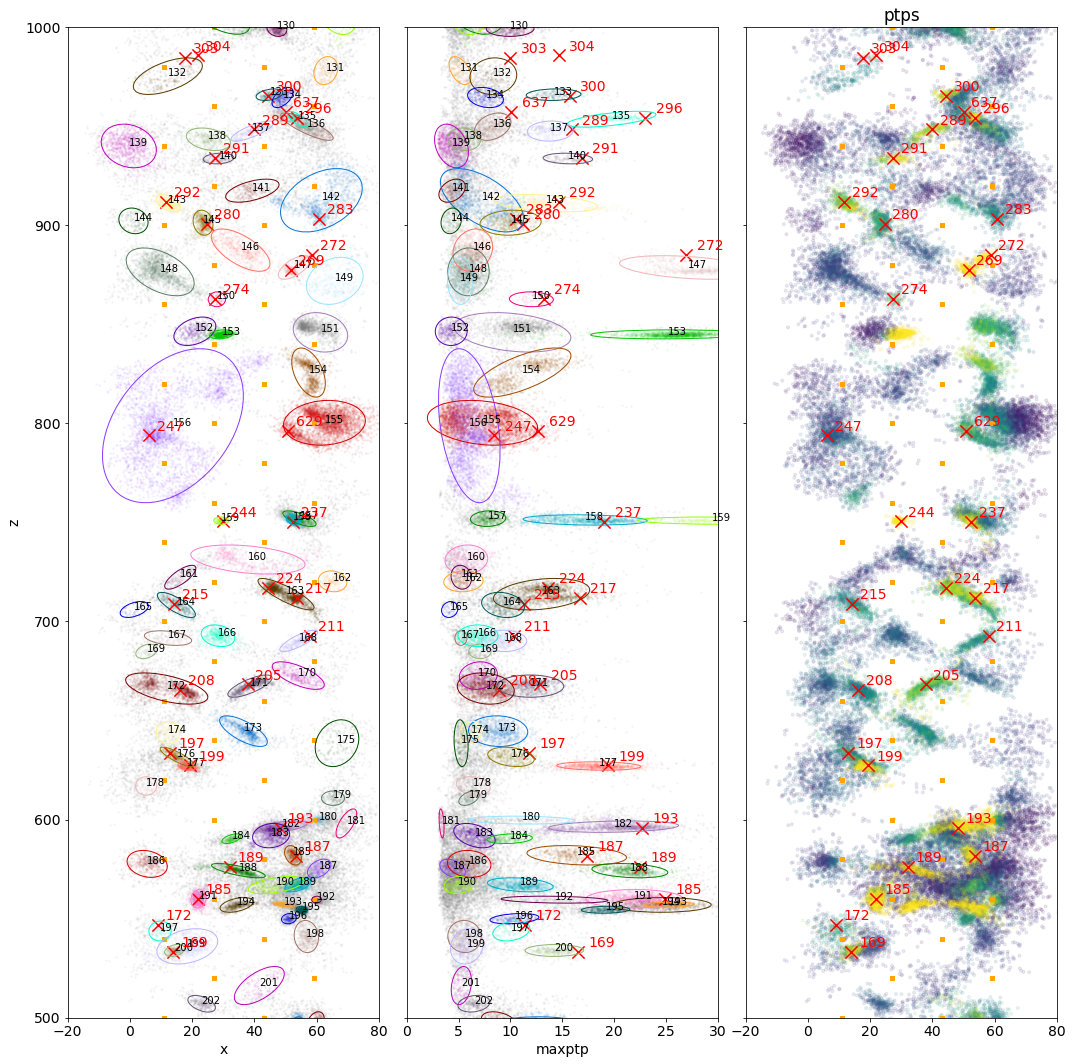

In [20]:
# z_cutoffs= [(0,550), (500,1050), (1000,1550), (1500,2050), (2000,2550), (2500,3050), (3000,3550), (3500,4050)]
z_cutoffs= [(500,1000)]#, (1000,1550), (1500,2050), (2000,2550), (2500,3050), (3000,3550), (3500,4050)]
matplotlib.rcParams.update({'font.size': 14})
for z_cutoff in z_cutoffs:
    fig, axes = cluster_viz_index.array_scatter(
            labels_original[idx_keep_full], geom, tx, tz, tmaxptps, 
            zlim=z_cutoff,
    )
    for cluster_id in good_kilo_sort_clusters:
        # axes[0].scatter(-25, kilo_cluster_depth_means[cluster_id], marker='x', color='blue')
        if len(sorting_kilo.get_unit_spike_train(cluster_id)) > 5:
            axes[0].scatter(kilo_cluster_locations[cluster_id][0], kilo_cluster_locations[cluster_id][1], marker='x', color='red', s=150)
            axes[0].annotate(f"{cluster_id}", (kilo_cluster_locations[cluster_id][0]+2.5, kilo_cluster_locations[cluster_id][1]+2.5), color='red')
            axes[1].scatter(np.max(kilo_cluster_templates[cluster_id].ptp(0)), kilo_cluster_locations[cluster_id][1], marker='x', color='red', s=150)
            axes[1].annotate(f"{cluster_id}", (np.max(kilo_cluster_templates[cluster_id].ptp(0))+1, kilo_cluster_locations[cluster_id][1]+2.5), color='red')
            # axes[2].scatter(-25, kilo_cluster_depth_means[cluster_id], marker='x', color='blue')
            axes[2].scatter(kilo_cluster_locations[cluster_id][0], kilo_cluster_locations[cluster_id][1], marker='x', color='red', s=150)
            axes[2].annotate(f"{cluster_id}", (kilo_cluster_locations[cluster_id][0]+2.5, kilo_cluster_locations[cluster_id][1]+2.5), color='red')
            axes[0].set_xlim(-20, 80)
            axes[1].set_xlim(0, 30)
            axes[2].set_xlim(-20, 80)
    # for go
    # fig.savefig(f"{save_dir_path}/full_scatter_{z_cutoff[0]}_{z_cutoff[1]}", dpi=200)
    # plt.close(fig)
    plt.show()

In [21]:
templates = merge_split_cleaned.get_templates(
    raw_bin, geom, clusterer.labels_.max()+1, spike_index[idx_keep_full], clusterer.labels_
)

template_shifts, template_maxchans, shifted_triaged_spike_index, idx_not_aligned = merge_split_cleaned.align_spikes_by_templates(
    clusterer.labels_, templates, spike_index[idx_keep_full]
)

shifted_full_spike_index = spike_index.copy()
shifted_full_spike_index[idx_keep_full] = shifted_triaged_spike_index

get templates:   0%|          | 0/285 [00:00<?, ?it/s]

In [22]:
# split
with h5py.File(sub_h5, "r") as h5:
    labels_split = merge_split_cleaned.split_clusters(
        residual_bin, 
        h5["subtracted_waveforms"], 
        firstchans, 
        shifted_full_spike_index,
        template_maxchans,
        template_shifts,
        labels_original, 
        x, 
        z_reg, 
        # maxptps, 
        geom, 
        denoiser, 
        device,
        tpca,
        n_channels=10,
        pca_n_channels=4,
        nn_denoise=False,
        threshold_diptest=.5,
    )    

# re-order again
clusterer.labels_ = labels_split[idx_keep_full]
cluster_centers = cluster_utils.compute_cluster_centers(clusterer)
clusterer = cluster_utils.relabel_by_depth(clusterer, cluster_centers)
cluster_centers = cluster_utils.compute_cluster_centers(clusterer)
labels = np.full(x.shape, -1)
labels[idx_keep_full] = clusterer.labels_

  0%|          | 0/285 [00:00<?, ?it/s]

splitting unit 0
splitting unit 1
splitting unit 2
splitting unit 3
splitting unit 4
splitting unit 5
splitting unit 6
splitting unit 7
dip test 0.0 -0.5361856310420279
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
splitting unit 8
splitting unit 9
splitting unit 10
splitting unit 11
splitting unit 12
splitting unit 13
splitting unit 14
splitting unit 15
splitting unit 16
splitting unit 17
splitting unit 18
splitting unit 19
splitting unit 20
dip test 0.0 0.31977138462305266
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
splitting unit 21
dip test 0.15003582203370822 0.6114285988037083
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

splitting unit 116
splitting unit 117
splitting unit 118
splitting unit 119
splitting unit 120
splitting unit 121
dip test 0.04899436561478255 -1.2983721697252086
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
splitting unit 122
splitting unit 123
splitting unit 124
splitting unit 125
dip test 7.569439599172468e-17 -2.3366142727050416
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

splitting unit 167
dip test 0.0 -1.9832356818435453
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
splitting unit 168
dip test 0.005507413807922421 -0.6093214837913346
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
splitting unit 169
dip test 1.7554167342883506e-16 -1.6160605711125768
[0 0 0 0 0 0 0 

splitting unit 199
splitting unit 200
splitting unit 201
splitting unit 202
splitting unit 203
splitting unit 204
splitting unit 205
splitting unit 206
splitting unit 207
splitting unit 208
splitting unit 209
splitting unit 210
splitting unit 211
splitting unit 212
splitting unit 213
splitting unit 214
splitting unit 215
dip test 0.23819434336289919 -0.8063750630695636
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

splitting unit 260
splitting unit 261
splitting unit 262
splitting unit 263
dip test 9.309503074677274e-17 -12.738345197476066
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
splitting unit 264
splitting unit 265
splitting unit 266
splitting unit 267
splitting unit 268
splitting unit 269
dip test 0.1980797390606978 0.07870205390849483
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [23]:
np.unique(clusterer.labels_).shape

(353,)

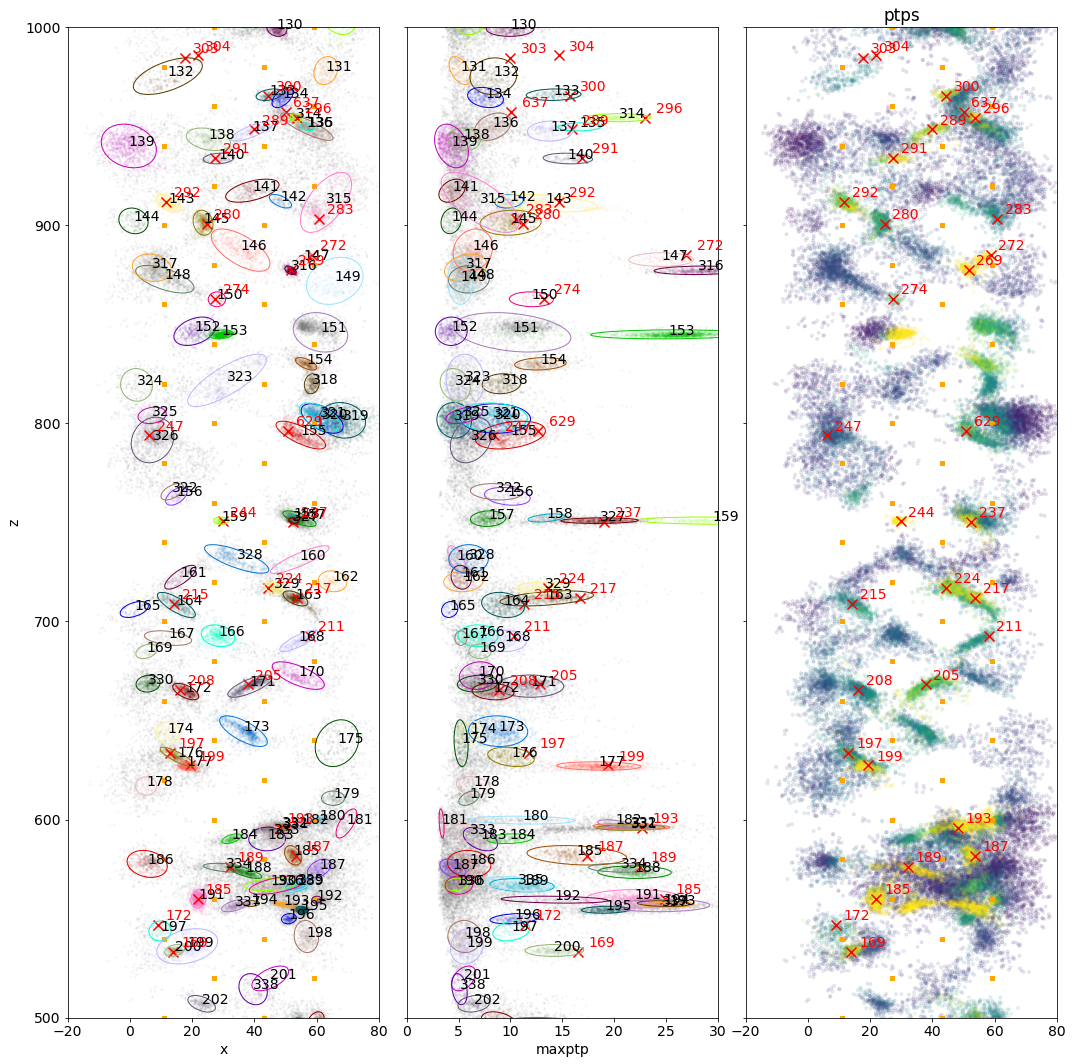

In [24]:
# z_cutoffs= [(0,550), (500,1050), (1000,1550), (1500,2050), (2000,2550), (2500,3050), (3000,3550), (3500,4050)]
z_cutoffs= [(500,1000)]#, (1000,1550), (1500,2050), (2000,2550), (2500,3050), (3000,3550), (3500,4050)]
matplotlib.rcParams.update({'font.size': 14})
for z_cutoff in z_cutoffs:
    fig, axes = cluster_viz.array_scatter(
            labels_split[idx_keep_full], geom, tx, tz, tmaxptps, 
            zlim=z_cutoff,
    )
    for cluster_id in sorting_kilo.get_unit_ids():
        if len(sorting_kilo.get_unit_spike_train(cluster_id)) > 25:
            if cluster_id in good_kilo_sort_clusters:
                color = 'red'
                alpha = 1
            else:
                color = 'blue'
                alpha = .4
            if cluster_id in good_kilo_sort_clusters:
                axes[0].scatter(kilo_cluster_locations[cluster_id][0], kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_0 = axes[0].annotate(f"{cluster_id}", (kilo_cluster_locations[cluster_id][0]+2.5, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                axes[1].scatter(np.max(kilo_cluster_templates[cluster_id].ptp(0)), kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_1 = axes[1].annotate(f"{cluster_id}", (np.max(kilo_cluster_templates[cluster_id].ptp(0))+1, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                axes[2].scatter(kilo_cluster_locations[cluster_id][0], kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_2 = axes[2].annotate(f"{cluster_id}", (kilo_cluster_locations[cluster_id][0]+2.5, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                text_0.set_alpha(alpha)
                text_1.set_alpha(alpha)
                text_2.set_alpha(alpha)
                axes[0].set_xlim(-20, 80)
                axes[1].set_xlim(0, 30)
                axes[2].set_xlim(-20, 80)
            # axes[0].set_xlim(-25, 120)
            # axes[2].set_xlim(-25, 120)
            # axes[2].set_ylim(200, 500)
            # axes[2].set_ylim(200, 500)
    # for go
    # fig.savefig(f"{save_dir_path}/full_scatter_{z_cutoff[0]}_{z_cutoff[1]}", dpi=200)
    # plt.close(fig)
    plt.show()

In [25]:
# get templates
templates = merge_split_cleaned.get_templates(
    raw_bin, geom, clusterer.labels_.max()+1, spike_index[idx_keep_full], clusterer.labels_
)

template_shifts, template_maxchans, shifted_triaged_spike_index, idx_not_aligned  = merge_split_cleaned.align_spikes_by_templates(
    clusterer.labels_, templates, spike_index[idx_keep_full]
)
shifted_full_spike_index = spike_index.copy()
shifted_full_spike_index[idx_keep_full] = shifted_triaged_spike_index

get templates:   0%|          | 0/352 [00:00<?, ?it/s]

In [26]:
# merge
with h5py.File(sub_h5, "r") as h5:
    labels_merged = merge_split_cleaned.get_merged(
        residual_bin,
        h5["subtracted_waveforms"],
        firstchans,
        geom,
        templates,
        template_shifts,
        len(templates),
        shifted_full_spike_index,
        labels,
        x,
        z_reg,
        denoiser,
        device,
        tpca,
        distance_threshold=1.,
        threshold_diptest=.5,
        nn_denoise=False,
    )
    
# re-order again
clusterer.labels_ = labels_merged[idx_keep_full]
cluster_centers = cluster_utils.compute_cluster_centers(clusterer)
clusterer = cluster_utils.relabel_by_depth(clusterer, cluster_centers)
cluster_centers = cluster_utils.compute_cluster_centers(clusterer)
labels = np.full(x.shape, -1)
labels[idx_keep_full] = clusterer.labels_

GET PROPOSED PAIRS


  0%|          | 0/352 [00:00<?, ?it/s]

In [28]:
np.unique(clusterer.labels_).shape

(341,)

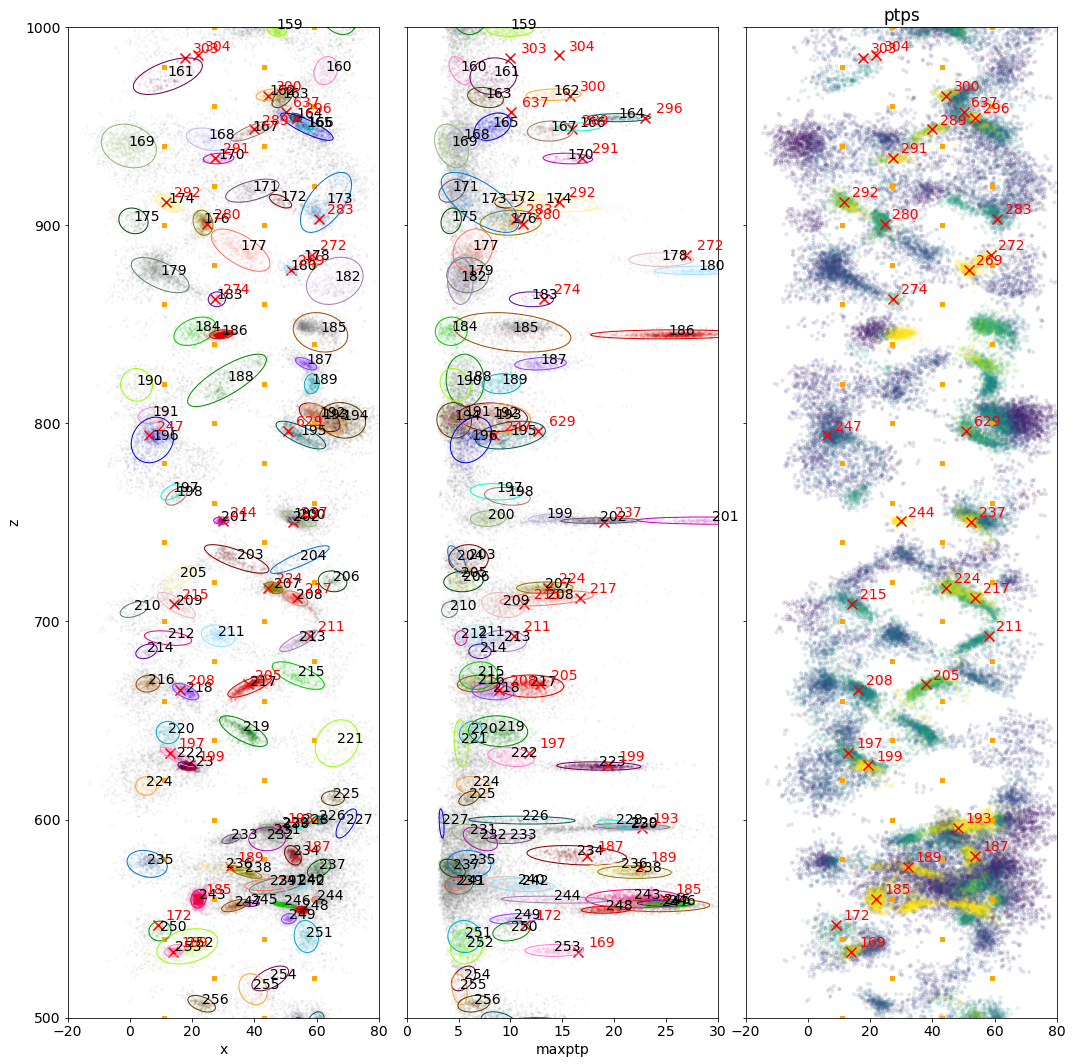

In [27]:
# z_cutoffs= [(0,550), (500,1050), (1000,1550), (1500,2050), (2000,2550), (2500,3050), (3000,3550), (3500,4050)]
z_cutoffs= [(500,1000)]#, (1000,1550), (1500,2050), (2000,2550), (2500,3050), (3000,3550), (3500,4050)]
matplotlib.rcParams.update({'font.size': 14})
for z_cutoff in z_cutoffs:
    fig, axes = cluster_viz.array_scatter(
            labels_merged[idx_keep_full], geom, tx, tz, tmaxptps, 
            zlim=z_cutoff,
    )
    for cluster_id in sorting_kilo.get_unit_ids():
        if len(sorting_kilo.get_unit_spike_train(cluster_id)) > 25:
            if cluster_id in good_kilo_sort_clusters:
                color = 'red'
                alpha = 1
            else:
                color = 'blue'
                alpha = .4
            if cluster_id in good_kilo_sort_clusters:
                axes[0].scatter(kilo_cluster_locations[cluster_id][0], kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_0 = axes[0].annotate(f"{cluster_id}", (kilo_cluster_locations[cluster_id][0]+2.5, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                axes[1].scatter(np.max(kilo_cluster_templates[cluster_id].ptp(0)), kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_1 = axes[1].annotate(f"{cluster_id}", (np.max(kilo_cluster_templates[cluster_id].ptp(0))+1, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                axes[2].scatter(kilo_cluster_locations[cluster_id][0], kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_2 = axes[2].annotate(f"{cluster_id}", (kilo_cluster_locations[cluster_id][0]+2.5, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                text_0.set_alpha(alpha)
                text_1.set_alpha(alpha)
                text_2.set_alpha(alpha)
                axes[0].set_xlim(-20, 80)
                axes[1].set_xlim(0, 30)
                axes[2].set_xlim(-20, 80)
    # fig.savefig(f"{save_dir_path}/full_scatter_{z_cutoff[0]}_{z_cutoff[1]}", dpi=200)
    # plt.close(fig)
    plt.show()

In [29]:
# get templates
templates = merge_split_cleaned.get_templates(
    raw_bin, geom, clusterer.labels_.max()+1, spike_index[idx_keep_full], clusterer.labels_
)

template_shifts, template_maxchans, shifted_triaged_spike_index, idx_not_aligned  = merge_split_cleaned.align_spikes_by_templates(
    clusterer.labels_, templates, spike_index[idx_keep_full]
)
shifted_full_spike_index = spike_index.copy()
shifted_full_spike_index[idx_keep_full] = shifted_triaged_spike_index

get templates:   0%|          | 0/340 [00:00<?, ?it/s]

In [34]:
spike_index[idx_keep_full].shape

(199878, 2)

In [33]:
clusterer.labels_.shape

(199878,)

In [35]:
np.save('/media/cat/data/CSH_ZAD_026_deconv/spike_index_deconv.npy', shifted_full_spike_index[idx_keep_full])
np.save('/media/cat/data/CSH_ZAD_026_deconv/templates_deconv.npy', templates)
np.save('/media/cat/data/CSH_ZAD_026_deconv/labels_deconv.npy', clusterer.labels_)


In [ ]:
###hdbscan
import os
save_dir_path = "clustering_results_split_merge"
if not os.path.exists(save_dir_path):
    os.makedirs(save_dir_path)

In [ ]:
z_cutoffs= [(0,550), (500,1050), (1000,1550), (1500,2050), (2000,2550), (2500,3050), (3000,3550), (3500,4050)]
for z_cutoff in z_cutoffs:
    fig, axes = cluster_viz.array_scatter(
            clusterer.labels_, geom, tx, tz, tmaxptps, 
            zlim=z_cutoff,
    )
    for cluster_id in sorting_kilo.get_unit_ids():
        if len(sorting_kilo.get_unit_spike_train(cluster_id)) > 25:
            if cluster_id in good_kilo_sort_clusters:
                color = 'red'
                alpha = 1
            else:
                color = 'blue'
                alpha = .4
            if cluster_id in good_kilo_sort_clusters:
                axes[0].scatter(kilo_cluster_locations[cluster_id][0], kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_0 = axes[0].annotate(f"{cluster_id}", (kilo_cluster_locations[cluster_id][0]+2.5, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                axes[1].scatter(np.max(kilo_cluster_templates[cluster_id].ptp(0)), kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_1 = axes[1].annotate(f"{cluster_id}", (np.max(kilo_cluster_templates[cluster_id].ptp(0))+1, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                axes[2].scatter(kilo_cluster_locations[cluster_id][0], kilo_cluster_locations[cluster_id][1], marker='x', color=color, s=100, alpha=alpha)
                text_2 = axes[2].annotate(f"{cluster_id}", (kilo_cluster_locations[cluster_id][0]+2.5, kilo_cluster_locations[cluster_id][1]+2.5), color=color)
                text_0.set_alpha(alpha)
                text_1.set_alpha(alpha)
                text_2.set_alpha(alpha)
                axes[0].set_xlim(-20, 80)
                axes[1].set_xlim(0, 30)
                axes[2].set_xlim(-20, 80)
    fig.savefig(f"{save_dir_path}/full_scatter_{z_cutoff[0]}_{z_cutoff[1]}", dpi=200)
    plt.close(fig)

In [ ]:
from joblib import Parallel, delayed

save_dir_parallel = save_dir_path + "/unit_summaries"
###hdbscan###
if not os.path.exists(save_dir_parallel):
    os.makedirs(save_dir_parallel)

for cluster_id in np.setdiff1d(np.unique(clusterer.labels_), [-1]):
    fig = plot_single_unit_summary(
        cluster_id,
        labels,
        spike_index,
        cluster_centers,
        geom,
        x,
        z,
        maxptps,
        firstchans,
        wfs_full_denoise,
        wfs_subtracted,
        raw_bin,
        residual_bin,
        num_spikes_plot=100, 
        num_rows_plot=3, 
        t_range=(30,90), 
        plot_all_points=False, 
        num_channels=40
    )
    save_z_int = int(cluster_centers.loc[cluster_id][1])
    save_str = str(save_z_int).zfill(4)
    fig.savefig(save_dir_parallel + f"/Z{save_str}_cluster{cluster_id}.png", transparent=False, pad_inches=0)
    plt.close(fig)

In [ ]:
num_close_clusters = 50
num_close_clusters_plot=10
num_channels_similarity = 20
shifts_align=np.arange(-8,9)
num_channels = 40
num_spikes_plot = 100

save_dir_similarity = save_dir_path + "/kilo_venns_similarities"
###hdbscan###
if not os.path.exists(save_dir_similarity):
    os.makedirs(save_dir_similarity)
    
for good_cluster_id in good_kilo_sort_clusters:
    cluster_id_kilo = good_cluster_id
    cluster_id = int(cmp_kilo.get_best_unit_match1(cluster_id_kilo))    
    if cluster_id != -1:
        st_1 = spike_index[:,0][np.where(labels==cluster_id)]
        st_2 = sorting_kilo.get_unit_spike_train(cluster_id_kilo)
        sorting1_name = "hdb"
        sorting2_name = "kilo"

        z_uniq, z_ids = np.unique(geom[:, 1], return_inverse=True)
        all_max_ptp = maxptps[labels==cluster_id].max()
        scale = (z_uniq[1] - z_uniq[0]) / max(7, all_max_ptp)

        firstchans_cluster_sorting1 = firstchans[labels == cluster_id]
        mcs_abs_cluster_sorting1 = spike_index[:,1][labels == cluster_id]

        spike_depths = kilo_spike_depths[np.where(kilo_spike_clusters==cluster_id_kilo)]
        mcs_abs_cluster_sorting2 = np.asarray([np.argmin(np.abs(spike_depth - geom[:,1])) for spike_depth in spike_depths])
        firstchans_cluster_sorting2 = (mcs_abs_cluster_sorting2 - 20).clip(min=0)

        fig = plot_agreement_venn(cluster_id, cluster_id_kilo, st_1, st_2, firstchans_cluster_sorting1, mcs_abs_cluster_sorting1, firstchans_cluster_sorting2, mcs_abs_cluster_sorting2,
                                  geom, raw_bin, scale=scale, sorting1_name=sorting1_name, sorting2_name=sorting2_name, num_channels=40, num_spikes_plot=200, t_range=(30,90), num_rows=3, 
                                  alpha=.1);
        
        save_z_int = int(kilo_spike_depths[cluster_id_kilo])
        save_str = str(save_z_int).zfill(4)
        fig.savefig(save_dir_similarity + f"/Z{save_str}_kscluster{cluster_id_kilo}_hdbcluster{cluster_id}.png", transparent=False, pad_inches=0)
        plt.close(fig)
        
    
    else:
        #compute K closest hdbscan clsuters
        closest_clusters = get_closest_clusters_kilosort_hdbscan(cluster_id_kilo, kilo_cluster_depth_means, cluster_centers, num_close_clusters)
        fig = plot_unit_similarities(cluster_id_kilo, closest_clusters, sorting_kilo, sorting_hdbl_t, geom, raw_bin, recording_duration, num_channels, num_spikes_plot, num_channels_similarity=num_channels_similarity, 
                                     num_close_clusters_plot=num_close_clusters_plot, num_close_clusters=num_close_clusters, shifts_align = shifts_align, order_by ='similarity', normalize_agreement_by="both")
        save_z_int = int(kilo_spike_depths[cluster_id_kilo])
        save_str = str(save_z_int).zfill(4)
        fig.savefig(save_dir_similarity + f"/Z{save_str}_kscluster{cluster_id_kilo}.png", transparent=False, pad_inches=0)
        plt.close(fig)